In [1]:
pip install tensorflow-gpu

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib import gridspec
from scipy import stats, interpolate
import os
from tensorflow.keras import backend as K  

import tqdm


import math

os.environ["CUDA_VISIBLE_DEVICES"]="2"
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)

per_process_gpu_memory_fraction: 0.333

In [3]:
original_data=pd.read_hdf("/Users/bolit/OneDrive/Documentos/Tec/7_semestre/investigacion/CWoaLaSimulation/content/events_anomalydetection_v2.features.h5")
features_sig=original_data.query("label == 1")
features_bg=original_data.query("label == 0")


features_bg2=pd.read_hdf("/Users/bolit/OneDrive/Documentos/Tec/7_semestre/investigacion/CWoaLaSimulation/content/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [4]:
features_sig

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
1000000,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635600,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901,1.0
1000001,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801,1.0
1000002,420.975006,-1739.790039,281.553986,93.665802,77.925797,10.605900,6.916510,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300,1.0
1000003,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.179993,102.625000,53.422699,1.0
1000004,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.889999,21.177299,10.582400,9.138600,1.0
1099996,-1286.619995,-86.162498,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502,1.0
1099997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726700,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301,1.0
1099998,1584.699951,-731.156982,-196.348007,114.938004,83.769897,12.898200,9.031230,-1515.079956,783.245972,498.704010,553.737000,366.188995,192.139008,81.398201,1.0


In [5]:
alpha = 0.1

def load_data_J1(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 1
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
       
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    #cada jet
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjOne"] = dataset["pTjOne"]*1000
    print((dataset["mjOne"] == dataset["mj1"])*dataset["pT1"])
    
    #ro
    dataset["rojOne"] = np.log(dataset["mjj"]/dataset["pTjOne"])
    
    print(dataset["rojOne"])
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["tau21jOne", "rojOne", "pTjOne"]]
    return dataset.to_numpy()


In [6]:
grapf_jet1_bg = load_data_J1(features_bg)
grapf_jet1_sig = load_data_J1(features_sig)


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2362063628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2362063628.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

0         1.589568
1         0.000000
2         1.390784
3         1.255513
4         0.000000
            ...   
999995    0.000000
999996    1.322321
999997    0.000000
999998    0.000000
999999    0.000000
Length: 1000000, dtype: float64
0        -6.175110
1        -5.299813
2        -6.137380
3        -5.961866
4        -6.184086
            ...   
999995   -5.827303
999996   -6.081528
999997   -5.398368
999998   -6.100915
999999   -6.103879
Name: rojOne, Length: 1000000, dtype: float64


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2362063628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2362063628.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

1000000    1.914943
1000001    1.684599
1000002    1.789997
1000003    1.672631
1000004    0.000000
             ...   
1099995    0.000000
1099996    1.289502
1099997    0.000000
1099998    1.745241
1099999    1.591161
Length: 100000, dtype: float64
1000000   -6.259376
1000001   -6.152047
1000002   -6.259809
1000003   -6.158879
1000004   -5.755328
             ...   
1099995   -5.775919
1099996   -5.874754
1099997   -5.964639
1099998   -6.181613
1099999   -6.121849
Name: rojOne, Length: 100000, dtype: float64


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2362063628.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]


In [7]:
alpha = 0.1

def load_data_J1_ro(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 1
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
       
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    #cada jet
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjOne"] = dataset["pTjOne"]*1000
    
    #ro
    dataset["rojOne"] = np.log(dataset["mjj"]/(dataset["pTjOne"]**2))
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["tau21jOne", "rojOne", "pTjOne"]]
    return dataset.to_numpy()


In [8]:
grapf_jet1_bg_ro = load_data_J1_ro(features_bg)
grapf_jet1_sig_ro = load_data_J1_ro(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\4224522466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\4224522466.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [9]:
j1rho_bg_ro_pt500 = []
j1rho_bg_t21_pt500 = []

j1rho_bg_ro_pt1000 = []
j1rho_bg_t21_pt1000 = []

j1rho_bg_ro_pt1500 = []
j1rho_bg_t21_pt1500 = []

j1rho_bg_ro_pt2000 = []
j1rho_bg_t21_pt2000 = []

j1rho_bg_ro_pt2500 = []
j1rho_bg_t21_pt2500 = []

j1rho_bg_ro_pt3000 = []
j1rho_bg_t21_pt3000 = []

j1rho_bg_ro_pt3500 = []
j1rho_bg_t21_pt3500 = []

j1rho_bg_ro_pt4000 = []
j1rho_bg_t21_pt4000 = []

for t in range(1000000):
    if grapf_jet1_bg_ro[t][2] <= 500:
        j1rho_bg_ro_pt500.append(grapf_jet1_bg_ro[t][1])
        j1rho_bg_t21_pt500.append(grapf_jet1_bg_ro[t][0])
    
    elif (grapf_jet1_bg_ro[t][2] > 500) and (grapf_jet1_bg_ro[t][2] <= 1000):
        j1rho_bg_ro_pt1000.append(grapf_jet1_bg_ro[t][1])
        j1rho_bg_t21_pt1000.append(grapf_jet1_bg_ro[t][0])
        
    elif (grapf_jet1_bg_ro[t][2] > 1000) and (grapf_jet1_bg_ro[t][2] <= 1500):
        j1rho_bg_ro_pt1500.append(grapf_jet1_bg_ro[t][1])
        j1rho_bg_t21_pt1500.append(grapf_jet1_bg_ro[t][0])
        
    elif (grapf_jet1_bg_ro[t][2] > 1500) and (grapf_jet1_bg_ro[t][2] <= 2000):
        j1rho_bg_ro_pt2000.append(grapf_jet1_bg_ro[t][1])
        j1rho_bg_t21_pt2000.append(grapf_jet1_bg_ro[t][0])
        
    elif (grapf_jet1_bg_ro[t][2] > 2000) and (grapf_jet1_bg_ro[t][2] <= 2500):
        j1rho_bg_ro_pt2500.append(grapf_jet1_bg_ro[t][1])
        j1rho_bg_t21_pt2500.append(grapf_jet1_bg_ro[t][0])
    
    elif (grapf_jet1_bg_ro[t][2] > 2500) and (grapf_jet1_bg_ro[t][2] <= 3000):
        j1rho_bg_ro_pt3000.append(grapf_jet1_bg_ro[t][1])
        j1rho_bg_t21_pt3000.append(grapf_jet1_bg_ro[t][0])
        
    elif (grapf_jet1_bg_ro[t][2] > 3000) and (grapf_jet1_bg_ro[t][2] <= 3500):
        j1rho_bg_ro_pt3500.append(grapf_jet1_bg_ro[t][1])
        j1rho_bg_t21_pt3500.append(grapf_jet1_bg_ro[t][0])
        
    elif (grapf_jet1_bg_ro[t][2] > 3500) and (grapf_jet1_bg_ro[t][2] <= 4000):
        j1rho_bg_ro_pt4000.append(grapf_jet1_bg_ro[t][1])
        j1rho_bg_t21_pt4000.append(grapf_jet1_bg_ro[t][0])
        

        
datarho_j1_T21_ro_500 = pd.DataFrame({'ro': j1rho_bg_ro_pt500, 
                                      'T21': j1rho_bg_t21_pt500})
datarho_j1_T21_ro_1000 = pd.DataFrame({'ro': j1rho_bg_ro_pt1000, 
                                       'T21': j1rho_bg_t21_pt1000})
datarho_j1_T21_ro_1500 = pd.DataFrame({'ro': j1rho_bg_ro_pt1500, 
                                       'T21': j1rho_bg_t21_pt1500})
datarho_j1_T21_ro_2000 = pd.DataFrame({'ro': j1rho_bg_ro_pt2000, 
                                       'T21': j1rho_bg_t21_pt2000})
datarho_j1_T21_ro_2500 = pd.DataFrame({'ro': j1rho_bg_ro_pt2500, 
                                       'T21': j1rho_bg_t21_pt2500})
datarho_j1_T21_ro_3000 = pd.DataFrame({'ro': j1rho_bg_ro_pt3000, 
                                       'T21': j1rho_bg_t21_pt3000})
datarho_j1_T21_ro_3500 = pd.DataFrame({'ro': j1rho_bg_ro_pt3500, 
                                       'T21': j1rho_bg_t21_pt3500})
datarho_j1_T21_ro_4000 = pd.DataFrame({'ro': j1rho_bg_ro_pt4000, 
                                       'T21': j1rho_bg_t21_pt4000})

orderrho_bgJ1_500 = datarho_j1_T21_ro_500.sort_values('ro')
orderrho_bgJ1_1000 = datarho_j1_T21_ro_1000.sort_values('ro')
orderrho_bgJ1_1500 = datarho_j1_T21_ro_1500.sort_values('ro')
orderrho_bgJ1_2000 = datarho_j1_T21_ro_2000.sort_values('ro')
orderrho_bgJ1_2500 = datarho_j1_T21_ro_2500.sort_values('ro')
orderrho_bgJ1_3000 = datarho_j1_T21_ro_3000.sort_values('ro')
orderrho_bgJ1_3500 = datarho_j1_T21_ro_3500.sort_values('ro')
orderrho_bgJ1_4000 = datarho_j1_T21_ro_4000.sort_values('ro')

In [10]:
orderrho_bgJ1_1500

,ro,T21
587293,-14.041873,0.136003
697518,-13.972316,0.590752
204775,-13.968342,0.610012
52186,-13.964064,0.370110
85346,-13.957065,0.447156
...,...,...
162200,-11.874172,0.329339
501203,-11.864843,0.636259
391579,-11.859447,0.716069
477466,-11.840626,0.694668


In [11]:
bgJ1rho_500 = orderrho_bgJ1_500.to_numpy()

avgrho_bgJ1_T21_500 = []
avgrho_bgJ1_ro_500 = []

Nrho_bgJ1_500 = math.ceil(len(orderrho_bgJ1_500['T21'])/15)

i = 0
sumrho_bgJ1_T21_500 = 0
sumrho_bgJ1_ro_500 = 0

for n in range(len(bgJ1rho_500)):
    sumrho_bgJ1_T21_500 = sumrho_bgJ1_T21_500 + bgJ1rho_500[n][1]
    sumrho_bgJ1_ro_500 = sumrho_bgJ1_ro_500 + bgJ1rho_500[n][0]      
    i = i+1
    
    if n == len(bgJ1rho_500)-1:
        avgrho_bgJ1_T21_500.append(sumrho_bgJ1_T21_500/Nrho_bgJ1_500)
        avgrho_bgJ1_ro_500.append(sumrho_bgJ1_ro_500/Nrho_bgJ1_500)
        
    if i >= Nrho_bgJ1_500:
        avgrho_bgJ1_T21_500.append(sumrho_bgJ1_T21_500/Nrho_bgJ1_500)
        avgrho_bgJ1_ro_500.append(sumrho_bgJ1_ro_500/Nrho_bgJ1_500)
        sumrho_bgJ1_T21_500 = 0
        sumrho_bgJ1_ro_500 = 0
        i = 0
        


bgJ1rho_1000 = orderrho_bgJ1_1000.to_numpy()

avgrho_bgJ1_T21_1000 = []
avgrho_bgJ1_ro_1000 = []

Nrho_bgJ1_1000 = math.ceil(len(orderrho_bgJ1_1000['T21'])/15)

i = 0
sumrho_bgJ1_T21_1000 = 0
sumrho_bgJ1_ro_1000 = 0

for n in range(len(bgJ1rho_1000)):
    sumrho_bgJ1_T21_1000 = sumrho_bgJ1_T21_1000 + bgJ1rho_1000[n][1]
    sumrho_bgJ1_ro_1000 = sumrho_bgJ1_ro_1000 + bgJ1rho_1000[n][0]      
    i = i+1
    
    if n == len(bgJ1rho_1000)-1:
        avgrho_bgJ1_T21_1000.append(sumrho_bgJ1_T21_1000/Nrho_bgJ1_1000)
        avgrho_bgJ1_ro_1000.append(sumrho_bgJ1_ro_1000/Nrho_bgJ1_1000)
        
    if i >= Nrho_bgJ1_1000:
        avgrho_bgJ1_T21_1000.append(sumrho_bgJ1_T21_1000/Nrho_bgJ1_1000)
        avgrho_bgJ1_ro_1000.append(sumrho_bgJ1_ro_1000/Nrho_bgJ1_1000)
        sumrho_bgJ1_T21_1000 = 0
        sumrho_bgJ1_ro_1000 = 0
        i = 0
        
        

bgJ1rho_1500 = orderrho_bgJ1_1500.to_numpy()

avgrho_bgJ1_T21_1500 = []
avgrho_bgJ1_ro_1500 = []

Nrho_bgJ1_1500 = math.ceil(len(orderrho_bgJ1_1500['T21'])/15)

i = 0
sumrho_bgJ1_T21_1500 = 0
sumrho_bgJ1_ro_1500 = 0

for n in range(len(bgJ1rho_1500)):
    sumrho_bgJ1_T21_1500 = sumrho_bgJ1_T21_1500 + bgJ1rho_1500[n][1]
    sumrho_bgJ1_ro_1500 = sumrho_bgJ1_ro_1500 + bgJ1rho_1500[n][0]      
    i = i+1
    
    if n == len(bgJ1rho_1500)-1:
        avgrho_bgJ1_T21_1500.append(sumrho_bgJ1_T21_1500/Nrho_bgJ1_1500)
        avgrho_bgJ1_ro_1500.append(sumrho_bgJ1_ro_1500/Nrho_bgJ1_1500)
        
    if i >= Nrho_bgJ1_1500:
        avgrho_bgJ1_T21_1500.append(sumrho_bgJ1_T21_1500/Nrho_bgJ1_1500)
        avgrho_bgJ1_ro_1500.append(sumrho_bgJ1_ro_1500/Nrho_bgJ1_1500)
        sumrho_bgJ1_T21_1500 = 0
        sumrho_bgJ1_ro_1500 = 0
        i = 0



bgJ1rho_2000 = orderrho_bgJ1_2000.to_numpy()

avgrho_bgJ1_T21_2000 = []
avgrho_bgJ1_ro_2000 = []

Nrho_bgJ1_2000 = math.ceil(len(orderrho_bgJ1_2000['T21'])/15)

i = 0
sumrho_bgJ1_T21_2000 = 0
sumrho_bgJ1_ro_2000 = 0

for n in range(len(bgJ1rho_2000)):
    sumrho_bgJ1_T21_2000 = sumrho_bgJ1_T21_2000 + bgJ1rho_2000[n][1]
    sumrho_bgJ1_ro_2000 = sumrho_bgJ1_ro_2000 + bgJ1rho_2000[n][0]      
    i = i+1
    
    if n == len(bgJ1rho_2000)-1:
        avgrho_bgJ1_T21_2000.append(sumrho_bgJ1_T21_2000/Nrho_bgJ1_2000)
        avgrho_bgJ1_ro_2000.append(sumrho_bgJ1_ro_2000/Nrho_bgJ1_2000)
        
    if i >= Nrho_bgJ1_2000:
        avgrho_bgJ1_T21_2000.append(sumrho_bgJ1_T21_2000/Nrho_bgJ1_2000)
        avgrho_bgJ1_ro_2000.append(sumrho_bgJ1_ro_2000/Nrho_bgJ1_2000)
        sumrho_bgJ1_T21_2000 = 0
        sumrho_bgJ1_ro_2000 = 0
        i = 0
        
        

bgJ1rho_2500 = orderrho_bgJ1_2500.to_numpy()

avgrho_bgJ1_T21_2500 = []
avgrho_bgJ1_ro_2500 = []

Nrho_bgJ1_2500 = math.ceil(len(orderrho_bgJ1_2500['T21'])/15)

i = 0
sumrho_bgJ1_T21_2500 = 0
sumrho_bgJ1_ro_2500 = 0

for n in range(len(bgJ1rho_2500)):
    sumrho_bgJ1_T21_2500 = sumrho_bgJ1_T21_2500 + bgJ1rho_2500[n][1]
    sumrho_bgJ1_ro_2500 = sumrho_bgJ1_ro_2500 + bgJ1rho_2500[n][0]      
    i = i+1
    
    if n == len(bgJ1rho_2500)-1:
        avgrho_bgJ1_T21_2500.append(sumrho_bgJ1_T21_2500/Nrho_bgJ1_2500)
        avgrho_bgJ1_ro_2500.append(sumrho_bgJ1_ro_2500/Nrho_bgJ1_2500)
        
    if i >= Nrho_bgJ1_2500:
        avgrho_bgJ1_T21_2500.append(sumrho_bgJ1_T21_2500/Nrho_bgJ1_2500)
        avgrho_bgJ1_ro_2500.append(sumrho_bgJ1_ro_2500/Nrho_bgJ1_2500)
        sumrho_bgJ1_T21_2500 = 0
        sumrho_bgJ1_ro_2500 = 0
        i = 0

        
        
bgJ1rho_3000 = orderrho_bgJ1_3000.to_numpy()

avgrho_bgJ1_T21_3000 = []
avgrho_bgJ1_ro_3000 = []

Nrho_bgJ1_3000 = math.ceil(len(orderrho_bgJ1_3000['T21'])/15)

i = 0
sumrho_bgJ1_T21_3000 = 0
sumrho_bgJ1_ro_3000 = 0

for n in range(len(bgJ1rho_3000)):
    sumrho_bgJ1_T21_3000 = sumrho_bgJ1_T21_3000 + bgJ1rho_3000[n][1]
    sumrho_bgJ1_ro_3000 = sumrho_bgJ1_ro_3000 + bgJ1rho_3000[n][0]      
    i = i+1
    
    if n == len(bgJ1rho_3000)-1:
        avgrho_bgJ1_T21_3000.append(sumrho_bgJ1_T21_3000/Nrho_bgJ1_3000)
        avgrho_bgJ1_ro_3000.append(sumrho_bgJ1_ro_3000/Nrho_bgJ1_3000)
        
    if i >= Nrho_bgJ1_3000:
        avgrho_bgJ1_T21_3000.append(sumrho_bgJ1_T21_3000/Nrho_bgJ1_3000)
        avgrho_bgJ1_ro_3000.append(sumrho_bgJ1_ro_3000/Nrho_bgJ1_3000)
        sumrho_bgJ1_T21_3000 = 0
        sumrho_bgJ1_ro_3000 = 0
        i = 0
        
        
        
bgJ1rho_3500 = orderrho_bgJ1_3500.to_numpy()

avgrho_bgJ1_T21_3500 = []
avgrho_bgJ1_ro_3500 = []

Nrho_bgJ1_3500 = math.ceil(len(orderrho_bgJ1_3500['T21'])/15)

i = 0
sumrho_bgJ1_T21_3500 = 0
sumrho_bgJ1_ro_3500 = 0

for n in range(len(bgJ1rho_3500)):
    sumrho_bgJ1_T21_3500 = sumrho_bgJ1_T21_3500 + bgJ1rho_3500[n][1]
    sumrho_bgJ1_ro_3500 = sumrho_bgJ1_ro_3500 + bgJ1rho_3500[n][0]      
    i = i+1
    
    if n == len(bgJ1rho_3500)-1:
        avgrho_bgJ1_T21_3500.append(sumrho_bgJ1_T21_3500/Nrho_bgJ1_3500)
        avgrho_bgJ1_ro_3500.append(sumrho_bgJ1_ro_3500/Nrho_bgJ1_3500)
        
    if i >= Nrho_bgJ1_3500:
        avgrho_bgJ1_T21_3500.append(sumrho_bgJ1_T21_3500/Nrho_bgJ1_3500)
        avgrho_bgJ1_ro_3500.append(sumrho_bgJ1_ro_3500/Nrho_bgJ1_3500)
        sumrho_bgJ1_T21_3500 = 0
        sumrho_bgJ1_ro_3500 = 0
        i = 0
        
        
        
bgJ1rho_4000 = orderrho_bgJ1_4000.to_numpy()

avgrho_bgJ1_T21_4000 = []
avgrho_bgJ1_ro_4000 = []

Nrho_bgJ1_4000 = math.ceil(len(orderrho_bgJ1_4000['T21'])/15)

i = 0
sumrho_bgJ1_T21_4000 = 0
sumrho_bgJ1_ro_4000 = 0

for n in range(len(bgJ1rho_4000)):
    sumrho_bgJ1_T21_4000 = sumrho_bgJ1_T21_4000 + bgJ1rho_4000[n][1]
    sumrho_bgJ1_ro_4000 = sumrho_bgJ1_ro_4000 + bgJ1rho_4000[n][0]      
    i = i+1
    
    if n == len(bgJ1rho_4000)-1:
        avgrho_bgJ1_T21_4000.append(sumrho_bgJ1_T21_4000/Nrho_bgJ1_4000)
        avgrho_bgJ1_ro_4000.append(sumrho_bgJ1_ro_4000/Nrho_bgJ1_4000)
        
    if i >= Nrho_bgJ1_4000:
        avgrho_bgJ1_T21_4000.append(sumrho_bgJ1_T21_4000/Nrho_bgJ1_4000)
        avgrho_bgJ1_ro_4000.append(sumrho_bgJ1_ro_4000/Nrho_bgJ1_4000)
        sumrho_bgJ1_T21_4000 = 0
        sumrho_bgJ1_ro_4000 = 0
        i = 0

In [12]:
j1rho_sig_ro_pt500 = []
j1rho_sig_t21_pt500 = []

j1rho_sig_ro_pt1000 = []
j1rho_sig_t21_pt1000 = []

j1rho_sig_ro_pt1500 = []
j1rho_sig_t21_pt1500 = []

j1rho_sig_ro_pt2000 = []
j1rho_sig_t21_pt2000 = []

j1rho_sig_ro_pt2500 = []
j1rho_sig_t21_pt2500 = []

j1rho_sig_ro_pt3000 = []
j1rho_sig_t21_pt3000 = []

j1rho_sig_ro_pt3500 = []
j1rho_sig_t21_pt3500 = []

j1rho_sig_ro_pt4000 = []
j1rho_sig_t21_pt4000 = []

for t in range(100000):
    if grapf_jet1_sig_ro[t][2] <= 500:
        j1rho_sig_ro_pt500.append(grapf_jet1_sig_ro[t][1])
        j1rho_sig_t21_pt500.append(grapf_jet1_sig_ro[t][0])
    
    elif (grapf_jet1_sig_ro[t][2] > 500) and (grapf_jet1_sig_ro[t][2] <= 1000):
        j1rho_sig_ro_pt1000.append(grapf_jet1_sig_ro[t][1])
        j1rho_sig_t21_pt1000.append(grapf_jet1_sig_ro[t][0])
        
    elif (grapf_jet1_sig_ro[t][2] > 1000) and (grapf_jet1_sig_ro[t][2] <= 1500):
        j1rho_sig_ro_pt1500.append(grapf_jet1_sig_ro[t][1])
        j1rho_sig_t21_pt1500.append(grapf_jet1_sig_ro[t][0])
        
    elif (grapf_jet1_sig_ro[t][2] > 1500) and (grapf_jet1_sig_ro[t][2] <= 2000):
        j1rho_sig_ro_pt2000.append(grapf_jet1_sig_ro[t][1])
        j1rho_sig_t21_pt2000.append(grapf_jet1_sig_ro[t][0])
        
    elif (grapf_jet1_sig_ro[t][2] > 2000) and (grapf_jet1_sig_ro[t][2] <= 2500):
        j1rho_sig_ro_pt2500.append(grapf_jet1_sig_ro[t][1])
        j1rho_sig_t21_pt2500.append(grapf_jet1_sig_ro[t][0])
    
    elif (grapf_jet1_sig_ro[t][2] > 2500) and (grapf_jet1_sig_ro[t][2] <= 3000):
        j1rho_sig_ro_pt3000.append(grapf_jet1_sig_ro[t][1])
        j1rho_sig_t21_pt3000.append(grapf_jet1_sig_ro[t][0])
        
    elif (grapf_jet1_sig_ro[t][2] > 3000) and (grapf_jet1_sig_ro[t][2] <= 3500):
        j1rho_sig_ro_pt3500.append(grapf_jet1_sig_ro[t][1])
        j1rho_sig_t21_pt3500.append(grapf_jet1_sig_ro[t][0])
        
    elif (grapf_jet1_sig_ro[t][2] > 3500) and (grapf_jet1_sig_ro[t][2] <= 4000):
        j1rho_sig_ro_pt4000.append(grapf_jet1_sig_ro[t][1])
        j1rho_sig_t21_pt4000.append(grapf_jet1_sig_ro[t][0])
        

        
datarho_j1sig_T21_ro_500 = pd.DataFrame({'ro': j1rho_sig_ro_pt500, 
                                      'T21': j1rho_sig_t21_pt500})
datarho_j1sig_T21_ro_1000 = pd.DataFrame({'ro': j1rho_sig_ro_pt1000, 
                                       'T21': j1rho_sig_t21_pt1000})
datarho_j1sig_T21_ro_1500 = pd.DataFrame({'ro': j1rho_sig_ro_pt1500, 
                                       'T21': j1rho_sig_t21_pt1500})
datarho_j1sig_T21_ro_2000 = pd.DataFrame({'ro': j1rho_sig_ro_pt2000, 
                                       'T21': j1rho_sig_t21_pt2000})
datarho_j1sig_T21_ro_2500 = pd.DataFrame({'ro': j1rho_sig_ro_pt2500, 
                                       'T21': j1rho_sig_t21_pt2500})
datarho_j1sig_T21_ro_3000 = pd.DataFrame({'ro': j1rho_sig_ro_pt3000, 
                                       'T21': j1rho_sig_t21_pt3000})
datarho_j1sig_T21_ro_3500 = pd.DataFrame({'ro': j1rho_sig_ro_pt3500, 
                                       'T21': j1rho_sig_t21_pt3500})
datarho_j1sig_T21_ro_4000 = pd.DataFrame({'ro': j1rho_sig_ro_pt4000, 
                                       'T21': j1rho_sig_t21_pt4000})

orderrho_sigJ1_500 = datarho_j1sig_T21_ro_500.sort_values('ro')
orderrho_sigJ1_1000 = datarho_j1sig_T21_ro_1000.sort_values('ro')
orderrho_sigJ1_1500 = datarho_j1sig_T21_ro_1500.sort_values('ro')
orderrho_sigJ1_2000 = datarho_j1sig_T21_ro_2000.sort_values('ro')
orderrho_sigJ1_2500 = datarho_j1sig_T21_ro_2500.sort_values('ro')
orderrho_sigJ1_3000 = datarho_j1sig_T21_ro_3000.sort_values('ro')
orderrho_sigJ1_3500 = datarho_j1sig_T21_ro_3500.sort_values('ro')
orderrho_sigJ1_4000 = datarho_j1sig_T21_ro_4000.sort_values('ro')

In [13]:
sigJ1rho_500 = orderrho_sigJ1_500.to_numpy()

avgrho_sigJ1_T21_500 = []
avgrho_sigJ1_ro_500 = []

Nrho_sigJ1_500 = math.ceil(len(orderrho_sigJ1_500['T21'])/15)

i = 0
sumrho_sigJ1_T21_500 = 0
sumrho_sigJ1_ro_500 = 0

for n in range(len(sigJ1rho_500)):
    sumrho_sigJ1_T21_500 = sumrho_sigJ1_T21_500 + sigJ1rho_500[n][1]
    sumrho_sigJ1_ro_500 = sumrho_sigJ1_ro_500 + sigJ1rho_500[n][0]      
    i = i+1
    
    if n == len(sigJ1rho_500)-1:
        avgrho_sigJ1_T21_500.append(sumrho_sigJ1_T21_500/Nrho_sigJ1_500)
        avgrho_sigJ1_ro_500.append(sumrho_sigJ1_ro_500/Nrho_sigJ1_500)
        
    if i >= Nrho_sigJ1_500:
        avgrho_sigJ1_T21_500.append(sumrho_sigJ1_T21_500/Nrho_sigJ1_500)
        avgrho_sigJ1_ro_500.append(sumrho_sigJ1_ro_500/Nrho_sigJ1_500)
        sumrho_sigJ1_T21_500 = 0
        sumrho_sigJ1_ro_500 = 0
        i = 0
        


sigJ1rho_1000 = orderrho_sigJ1_1000.to_numpy()

avgrho_sigJ1_T21_1000 = []
avgrho_sigJ1_ro_1000 = []

Nrho_sigJ1_1000 = math.ceil(len(orderrho_sigJ1_1000['T21'])/15)

i = 0
sumrho_sigJ1_T21_1000 = 0
sumrho_sigJ1_ro_1000 = 0

for n in range(len(sigJ1rho_1000)):
    sumrho_sigJ1_T21_1000 = sumrho_sigJ1_T21_1000 + sigJ1rho_1000[n][1]
    sumrho_sigJ1_ro_1000 = sumrho_sigJ1_ro_1000 + sigJ1rho_1000[n][0]      
    i = i+1
    
    if n == len(sigJ1rho_1000)-1:
        avgrho_sigJ1_T21_1000.append(sumrho_sigJ1_T21_1000/Nrho_sigJ1_1000)
        avgrho_sigJ1_ro_1000.append(sumrho_sigJ1_ro_1000/Nrho_sigJ1_1000)
        
    if i >= Nrho_sigJ1_1000:
        avgrho_sigJ1_T21_1000.append(sumrho_sigJ1_T21_1000/Nrho_sigJ1_1000)
        avgrho_sigJ1_ro_1000.append(sumrho_sigJ1_ro_1000/Nrho_sigJ1_1000)
        sumrho_sigJ1_T21_1000 = 0
        sumrho_sigJ1_ro_1000 = 0
        i = 0
        
        

sigJ1rho_1500 = orderrho_sigJ1_1500.to_numpy()

avgrho_sigJ1_T21_1500 = []
avgrho_sigJ1_ro_1500 = []

Nrho_sigJ1_1500 = math.ceil(len(orderrho_sigJ1_1500['T21'])/15)

i = 0
sumrho_sigJ1_T21_1500 = 0
sumrho_sigJ1_ro_1500 = 0

for n in range(len(sigJ1rho_1500)):
    sumrho_sigJ1_T21_1500 = sumrho_sigJ1_T21_1500 + sigJ1rho_1500[n][1]
    sumrho_sigJ1_ro_1500 = sumrho_sigJ1_ro_1500 + sigJ1rho_1500[n][0]      
    i = i+1
    
    if n == len(sigJ1rho_1500)-1:
        avgrho_sigJ1_T21_1500.append(sumrho_sigJ1_T21_1500/Nrho_sigJ1_1500)
        avgrho_sigJ1_ro_1500.append(sumrho_sigJ1_ro_1500/Nrho_sigJ1_1500)
        
    if i >= Nrho_sigJ1_1500:
        avgrho_sigJ1_T21_1500.append(sumrho_sigJ1_T21_1500/Nrho_sigJ1_1500)
        avgrho_sigJ1_ro_1500.append(sumrho_sigJ1_ro_1500/Nrho_sigJ1_1500)
        sumrho_sigJ1_T21_1500 = 0
        sumrho_sigJ1_ro_1500 = 0
        i = 0



sigJ1rho_2000 = orderrho_sigJ1_2000.to_numpy()

avgrho_sigJ1_T21_2000 = []
avgrho_sigJ1_ro_2000 = []

Nrho_sigJ1_2000 = math.ceil(len(orderrho_sigJ1_2000['T21'])/15)

i = 0
sumrho_sigJ1_T21_2000 = 0
sumrho_sigJ1_ro_2000 = 0

for n in range(len(sigJ1rho_2000)):
    sumrho_sigJ1_T21_2000 = sumrho_sigJ1_T21_2000 + sigJ1rho_2000[n][1]
    sumrho_sigJ1_ro_2000 = sumrho_sigJ1_ro_2000 + sigJ1rho_2000[n][0]      
    i = i+1
    
    if n == len(sigJ1rho_2000)-1:
        avgrho_sigJ1_T21_2000.append(sumrho_sigJ1_T21_2000/Nrho_sigJ1_2000)
        avgrho_sigJ1_ro_2000.append(sumrho_sigJ1_ro_2000/Nrho_sigJ1_2000)
        
    if i >= Nrho_sigJ1_2000:
        avgrho_sigJ1_T21_2000.append(sumrho_sigJ1_T21_2000/Nrho_sigJ1_2000)
        avgrho_sigJ1_ro_2000.append(sumrho_sigJ1_ro_2000/Nrho_sigJ1_2000)
        sumrho_sigJ1_T21_2000 = 0
        sumrho_sigJ1_ro_2000 = 0
        i = 0
        
        

sigJ1rho_2500 = orderrho_sigJ1_2500.to_numpy()

avgrho_sigJ1_T21_2500 = []
avgrho_sigJ1_ro_2500 = []

Nrho_sigJ1_2500 = math.ceil(len(orderrho_sigJ1_2500['T21'])/15)

i = 0
sumrho_sigJ1_T21_2500 = 0
sumrho_sigJ1_ro_2500 = 0

for n in range(len(sigJ1rho_2500)):
    sumrho_sigJ1_T21_2500 = sumrho_sigJ1_T21_2500 + sigJ1rho_2500[n][1]
    sumrho_sigJ1_ro_2500 = sumrho_sigJ1_ro_2500 + sigJ1rho_2500[n][0]      
    i = i+1
    
    if n == len(sigJ1rho_2500)-1:
        avgrho_sigJ1_T21_2500.append(sumrho_sigJ1_T21_2500/Nrho_sigJ1_2500)
        avgrho_sigJ1_ro_2500.append(sumrho_sigJ1_ro_2500/Nrho_sigJ1_2500)
        
    if i >= Nrho_sigJ1_2500:
        avgrho_sigJ1_T21_2500.append(sumrho_sigJ1_T21_2500/Nrho_sigJ1_2500)
        avgrho_sigJ1_ro_2500.append(sumrho_sigJ1_ro_2500/Nrho_sigJ1_2500)
        sumrho_sigJ1_T21_2500 = 0
        sumrho_sigJ1_ro_2500 = 0
        i = 0

        
        
sigJ1rho_3000 = orderrho_sigJ1_3000.to_numpy()

avgrho_sigJ1_T21_3000 = []
avgrho_sigJ1_ro_3000 = []

Nrho_sigJ1_3000 = math.ceil(len(orderrho_sigJ1_3000['T21'])/15)

i = 0
sumrho_sigJ1_T21_3000 = 0
sumrho_sigJ1_ro_3000 = 0

for n in range(len(sigJ1rho_3000)):
    sumrho_sigJ1_T21_3000 = sumrho_sigJ1_T21_3000 + sigJ1rho_3000[n][1]
    sumrho_sigJ1_ro_3000 = sumrho_sigJ1_ro_3000 + sigJ1rho_3000[n][0]      
    i = i+1
    
    if n == len(sigJ1rho_3000)-1:
        avgrho_sigJ1_T21_3000.append(sumrho_sigJ1_T21_3000/Nrho_sigJ1_3000)
        avgrho_sigJ1_ro_3000.append(sumrho_sigJ1_ro_3000/Nrho_sigJ1_3000)
        
    if i >= Nrho_sigJ1_3000:
        avgrho_sigJ1_T21_3000.append(sumrho_sigJ1_T21_3000/Nrho_sigJ1_3000)
        avgrho_sigJ1_ro_3000.append(sumrho_sigJ1_ro_3000/Nrho_sigJ1_3000)
        sumrho_sigJ1_T21_3000 = 0
        sumrho_sigJ1_ro_3000 = 0
        i = 0
        
        
        
sigJ1rho_3500 = orderrho_sigJ1_3500.to_numpy()

avgrho_sigJ1_T21_3500 = []
avgrho_sigJ1_ro_3500 = []

Nrho_sigJ1_3500 = math.ceil(len(orderrho_sigJ1_3500['T21'])/15)

i = 0
sumrho_sigJ1_T21_3500 = 0
sumrho_sigJ1_ro_3500 = 0

for n in range(len(sigJ1rho_3500)):
    sumrho_sigJ1_T21_3500 = sumrho_sigJ1_T21_3500 + sigJ1rho_3500[n][1]
    sumrho_sigJ1_ro_3500 = sumrho_sigJ1_ro_3500 + sigJ1rho_3500[n][0]      
    i = i+1
    
    if n == len(sigJ1rho_3500)-1:
        avgrho_sigJ1_T21_3500.append(sumrho_sigJ1_T21_3500/Nrho_sigJ1_3500)
        avgrho_sigJ1_ro_3500.append(sumrho_sigJ1_ro_3500/Nrho_sigJ1_3500)
        
    if i >= Nrho_sigJ1_3500:
        avgrho_sigJ1_T21_3500.append(sumrho_sigJ1_T21_3500/Nrho_sigJ1_3500)
        avgrho_sigJ1_ro_3500.append(sumrho_sigJ1_ro_3500/Nrho_sigJ1_3500)
        sumrho_sigJ1_T21_3500 = 0
        sumrho_sigJ1_ro_3500 = 0
        i = 0
        
        
        
sigJ1rho_4000 = orderrho_sigJ1_4000.to_numpy()

avgrho_sigJ1_T21_4000 = []
avgrho_sigJ1_ro_4000 = []

Nrho_sigJ1_4000 = math.ceil(len(orderrho_sigJ1_4000['T21'])/15)

i = 0
sumrho_sigJ1_T21_4000 = 0
sumrho_sigJ1_ro_4000 = 0

for n in range(len(sigJ1rho_4000)):
    sumrho_sigJ1_T21_4000 = sumrho_sigJ1_T21_4000 + sigJ1rho_4000[n][1]
    sumrho_sigJ1_ro_4000 = sumrho_sigJ1_ro_4000 + sigJ1rho_4000[n][0]      
    i = i+1
    
    if n == len(sigJ1rho_4000)-1:
        avgrho_sigJ1_T21_4000.append(sumrho_sigJ1_T21_4000/Nrho_sigJ1_4000)
        avgrho_sigJ1_ro_4000.append(sumrho_sigJ1_ro_4000/Nrho_sigJ1_4000)
        
    if i >= Nrho_sigJ1_4000:
        avgrho_sigJ1_T21_4000.append(sumrho_sigJ1_T21_4000/Nrho_sigJ1_4000)
        avgrho_sigJ1_ro_4000.append(sumrho_sigJ1_ro_4000/Nrho_sigJ1_4000)
        sumrho_sigJ1_T21_4000 = 0
        sumrho_sigJ1_ro_4000 = 0
        i = 0

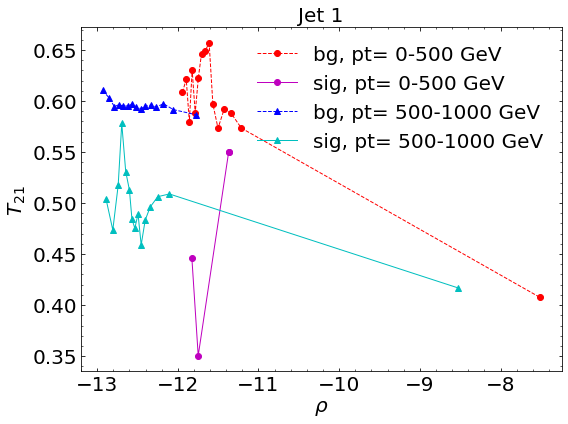

In [14]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.plot(avgrho_bgJ1_ro_500, avgrho_bgJ1_T21_500, 'o--', linewidth=1, color='r', label="bg, pt= 0-500 GeV")
plt.plot(avgrho_sigJ1_ro_500, avgrho_sigJ1_T21_500, 'o-', linewidth=1, color='m', label="sig, pt= 0-500 GeV")
plt.plot(avgrho_bgJ1_ro_1000, avgrho_bgJ1_T21_1000, '^--', linewidth=1, color='b', label="bg, pt= 500-1000 GeV")
plt.plot(avgrho_sigJ1_ro_1000, avgrho_sigJ1_T21_1000, '^-', linewidth=1, color='c', label="sig, pt= 500-1000 GeV")

plt.xlabel(r'${\rho}$',fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.title("Jet 1",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

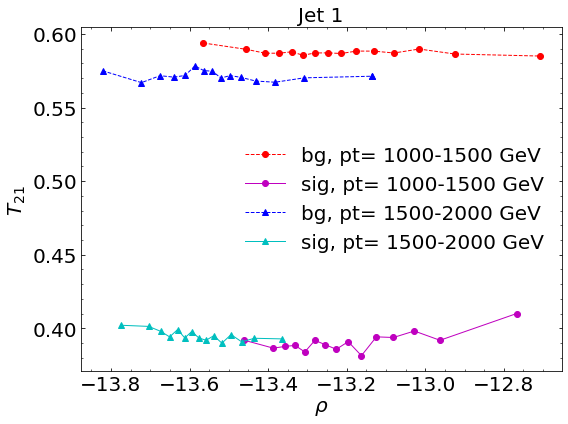

In [15]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.plot(avgrho_bgJ1_ro_1500, avgrho_bgJ1_T21_1500, 'o--', linewidth=1, color='r', label="bg, pt= 1000-1500 GeV")
plt.plot(avgrho_sigJ1_ro_1500, avgrho_sigJ1_T21_1500, 'o-', linewidth=1, color='m', label="sig, pt= 1000-1500 GeV")
plt.plot(avgrho_bgJ1_ro_2000, avgrho_bgJ1_T21_2000, '^--', linewidth=1, color='b', label="bg, pt= 1500-2000 GeV")
plt.plot(avgrho_sigJ1_ro_2000, avgrho_sigJ1_T21_2000, '^-', linewidth=1, color='c', label="sig, pt= 1500-2000 GeV")

plt.xlabel(r'${\rho}$',fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.title("Jet 1",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

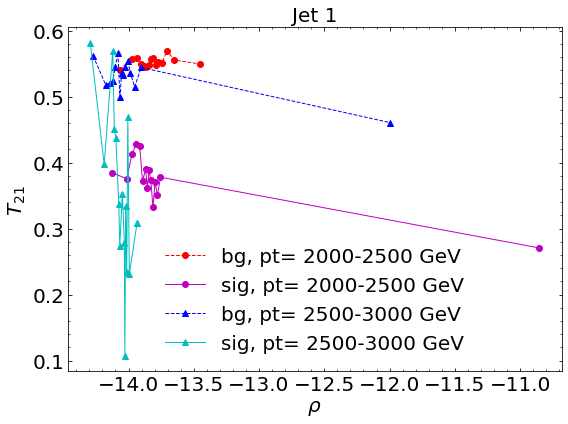

In [16]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.plot(avgrho_bgJ1_ro_2500, avgrho_bgJ1_T21_2500, 'o--', linewidth=1, color='r', label="bg, pt= 2000-2500 GeV")
plt.plot(avgrho_sigJ1_ro_2500, avgrho_sigJ1_T21_2500, 'o-', linewidth=1, color='m', label="sig, pt= 2000-2500 GeV")
plt.plot(avgrho_bgJ1_ro_3000, avgrho_bgJ1_T21_3000, '^--', linewidth=1, color='b', label="bg, pt= 2500-3000 GeV")
plt.plot(avgrho_sigJ1_ro_3000, avgrho_sigJ1_T21_3000, '^-', linewidth=1, color='c', label="sig, pt= 2500-3000 GeV")

plt.xlabel(r'${\rho}$',fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.title("Jet 1",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

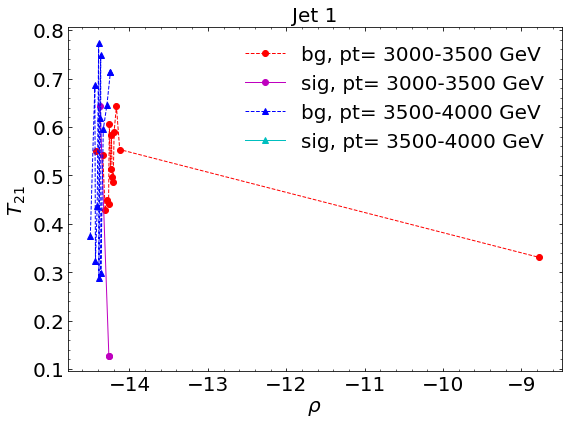

In [17]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.plot(avgrho_bgJ1_ro_3500, avgrho_bgJ1_T21_3500, 'o--', linewidth=1, color='r', label="bg, pt= 3000-3500 GeV")
plt.plot(avgrho_sigJ1_ro_3500, avgrho_sigJ1_T21_3500, 'o-', linewidth=1, color='m', label="sig, pt= 3000-3500 GeV")
plt.plot(avgrho_bgJ1_ro_4000, avgrho_bgJ1_T21_4000, '^--', linewidth=1, color='b', label="bg, pt= 3500-4000 GeV")
plt.plot(avgrho_sigJ1_ro_4000, avgrho_sigJ1_T21_4000, '^-', linewidth=1, color='c', label="sig, pt= 3500-4000 GeV")

plt.xlabel(r'${\rho}$',fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.title("Jet 1",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

In [18]:
alpha = 0.1

def load_data_J2_ro(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 2
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
       
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    #cada jet
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"] 
    dataset["pTjTwo"] = dataset["pTjTwo"]*1000
    
    #ro
    dataset["rojTwo"] = np.log(dataset["mjj"]/(dataset["pTjTwo"]**2))
    

    dataset = dataset.fillna(0)
    dataset = dataset[["tau21jTwo", "rojTwo", "pTjTwo"]]
    return dataset.to_numpy()


In [19]:
grapf_jet2_bg_ro = load_data_J2_ro(features_bg)
grapf_jet2_sig_ro = load_data_J2_ro(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2592972720.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2592972720.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [20]:
j2rho_bg_ro_pt500 = []
j2rho_bg_t21_pt500 = []

j2rho_bg_ro_pt1000 = []
j2rho_bg_t21_pt1000 = []

j2rho_bg_ro_pt1500 = []
j2rho_bg_t21_pt1500 = []

j2rho_bg_ro_pt2000 = []
j2rho_bg_t21_pt2000 = []

j2rho_bg_ro_pt2500 = []
j2rho_bg_t21_pt2500 = []

j2rho_bg_ro_pt3000 = []
j2rho_bg_t21_pt3000 = []

j2rho_bg_ro_pt3500 = []
j2rho_bg_t21_pt3500 = []

j2rho_bg_ro_pt4000 = []
j2rho_bg_t21_pt4000 = []

for t in range(1000000):
    if grapf_jet2_bg_ro[t][2] <= 500:
        j2rho_bg_ro_pt500.append(grapf_jet2_bg_ro[t][1])
        j2rho_bg_t21_pt500.append(grapf_jet2_bg_ro[t][0])
    
    elif (grapf_jet2_bg_ro[t][2] > 500) and (grapf_jet2_bg_ro[t][2] <= 1000):
        j2rho_bg_ro_pt1000.append(grapf_jet2_bg_ro[t][1])
        j2rho_bg_t21_pt1000.append(grapf_jet2_bg_ro[t][0])
        
    elif (grapf_jet2_bg_ro[t][2] > 1000) and (grapf_jet2_bg_ro[t][2] <= 1500):
        j2rho_bg_ro_pt1500.append(grapf_jet2_bg_ro[t][1])
        j2rho_bg_t21_pt1500.append(grapf_jet2_bg_ro[t][0])
        
    elif (grapf_jet2_bg_ro[t][2] > 1500) and (grapf_jet2_bg_ro[t][2] <= 2000):
        j2rho_bg_ro_pt2000.append(grapf_jet2_bg_ro[t][1])
        j2rho_bg_t21_pt2000.append(grapf_jet2_bg_ro[t][0])
        
    elif (grapf_jet2_bg_ro[t][2] > 2000) and (grapf_jet2_bg_ro[t][2] <= 2500):
        j2rho_bg_ro_pt2500.append(grapf_jet2_bg_ro[t][1])
        j2rho_bg_t21_pt2500.append(grapf_jet2_bg_ro[t][0])
    
    elif (grapf_jet2_bg_ro[t][2] > 2500) and (grapf_jet2_bg_ro[t][2] <= 3000):
        j2rho_bg_ro_pt3000.append(grapf_jet2_bg_ro[t][1])
        j2rho_bg_t21_pt3000.append(grapf_jet2_bg_ro[t][0])
        
    elif (grapf_jet2_bg_ro[t][2] > 3000) and (grapf_jet2_bg_ro[t][2] <= 3500):
        j2rho_bg_ro_pt3500.append(grapf_jet2_bg_ro[t][1])
        j2rho_bg_t21_pt3500.append(grapf_jet2_bg_ro[t][0])
        
    elif (grapf_jet2_bg_ro[t][2] > 3500) and (grapf_jet2_bg_ro[t][2] <= 4000):
        j2rho_bg_ro_pt4000.append(grapf_jet2_bg_ro[t][1])
        j2rho_bg_t21_pt4000.append(grapf_jet2_bg_ro[t][0])
        

        
datarho_j2_T21_ro_500 = pd.DataFrame({'ro': j2rho_bg_ro_pt500, 
                                      'T21': j2rho_bg_t21_pt500})
datarho_j2_T21_ro_1000 = pd.DataFrame({'ro': j2rho_bg_ro_pt1000, 
                                       'T21': j2rho_bg_t21_pt1000})
datarho_j2_T21_ro_1500 = pd.DataFrame({'ro': j2rho_bg_ro_pt1500, 
                                       'T21': j2rho_bg_t21_pt1500})
datarho_j2_T21_ro_2000 = pd.DataFrame({'ro': j2rho_bg_ro_pt2000, 
                                       'T21': j2rho_bg_t21_pt2000})
datarho_j2_T21_ro_2500 = pd.DataFrame({'ro': j2rho_bg_ro_pt2500, 
                                       'T21': j2rho_bg_t21_pt2500})
datarho_j2_T21_ro_3000 = pd.DataFrame({'ro': j2rho_bg_ro_pt3000, 
                                       'T21': j2rho_bg_t21_pt3000})
datarho_j2_T21_ro_3500 = pd.DataFrame({'ro': j2rho_bg_ro_pt3500, 
                                       'T21': j2rho_bg_t21_pt3500})
datarho_j2_T21_ro_4000 = pd.DataFrame({'ro': j2rho_bg_ro_pt4000, 
                                       'T21': j2rho_bg_t21_pt4000})

orderrho_bgJ2_500 = datarho_j2_T21_ro_500.sort_values('ro')
orderrho_bgJ2_1000 = datarho_j2_T21_ro_1000.sort_values('ro')
orderrho_bgJ2_1500 = datarho_j2_T21_ro_1500.sort_values('ro')
orderrho_bgJ2_2000 = datarho_j2_T21_ro_2000.sort_values('ro')
orderrho_bgJ2_2500 = datarho_j2_T21_ro_2500.sort_values('ro')
orderrho_bgJ2_3000 = datarho_j2_T21_ro_3000.sort_values('ro')
orderrho_bgJ2_3500 = datarho_j2_T21_ro_3500.sort_values('ro')
orderrho_bgJ2_4000 = datarho_j2_T21_ro_4000.sort_values('ro')

In [21]:
bgJ2rho_500 = orderrho_bgJ2_500.to_numpy()

avgrho_bgJ2_T21_500 = []
avgrho_bgJ2_ro_500 = []

Nrho_bgJ2_500 = math.ceil(len(orderrho_bgJ2_500['T21'])/15)

i = 0
sumrho_bgJ2_T21_500 = 0
sumrho_bgJ2_ro_500 = 0

for n in range(len(bgJ2rho_500)):
    sumrho_bgJ2_T21_500 = sumrho_bgJ2_T21_500 + bgJ2rho_500[n][1]
    sumrho_bgJ2_ro_500 = sumrho_bgJ2_ro_500 + bgJ2rho_500[n][0]      
    i = i+1
    
    if n == len(bgJ2rho_500)-1:
        avgrho_bgJ2_T21_500.append(sumrho_bgJ2_T21_500/Nrho_bgJ2_500)
        avgrho_bgJ2_ro_500.append(sumrho_bgJ2_ro_500/Nrho_bgJ2_500)
        
    if i >= Nrho_bgJ2_500:
        avgrho_bgJ2_T21_500.append(sumrho_bgJ2_T21_500/Nrho_bgJ2_500)
        avgrho_bgJ2_ro_500.append(sumrho_bgJ2_ro_500/Nrho_bgJ2_500)
        sumrho_bgJ2_T21_500 = 0
        sumrho_bgJ2_ro_500 = 0
        i = 0
        


bgJ2rho_1000 = orderrho_bgJ2_1000.to_numpy()

avgrho_bgJ2_T21_1000 = []
avgrho_bgJ2_ro_1000 = []

Nrho_bgJ2_1000 = math.ceil(len(orderrho_bgJ2_1000['T21'])/15)

i = 0
sumrho_bgJ2_T21_1000 = 0
sumrho_bgJ2_ro_1000 = 0

for n in range(len(bgJ2rho_1000)):
    sumrho_bgJ2_T21_1000 = sumrho_bgJ2_T21_1000 + bgJ2rho_1000[n][1]
    sumrho_bgJ2_ro_1000 = sumrho_bgJ2_ro_1000 + bgJ2rho_1000[n][0]      
    i = i+1
    
    if n == len(bgJ2rho_1000)-1:
        avgrho_bgJ2_T21_1000.append(sumrho_bgJ2_T21_1000/Nrho_bgJ2_1000)
        avgrho_bgJ2_ro_1000.append(sumrho_bgJ2_ro_1000/Nrho_bgJ2_1000)
        
    if i >= Nrho_bgJ2_1000:
        avgrho_bgJ2_T21_1000.append(sumrho_bgJ2_T21_1000/Nrho_bgJ2_1000)
        avgrho_bgJ2_ro_1000.append(sumrho_bgJ2_ro_1000/Nrho_bgJ2_1000)
        sumrho_bgJ2_T21_1000 = 0
        sumrho_bgJ2_ro_1000 = 0
        i = 0
        
        

bgJ2rho_1500 = orderrho_bgJ2_1500.to_numpy()

avgrho_bgJ2_T21_1500 = []
avgrho_bgJ2_ro_1500 = []

Nrho_bgJ2_1500 = math.ceil(len(orderrho_bgJ2_1500['T21'])/15)

i = 0
sumrho_bgJ2_T21_1500 = 0
sumrho_bgJ2_ro_1500 = 0

for n in range(len(bgJ2rho_1500)):
    sumrho_bgJ2_T21_1500 = sumrho_bgJ2_T21_1500 + bgJ2rho_1500[n][1]
    sumrho_bgJ2_ro_1500 = sumrho_bgJ2_ro_1500 + bgJ2rho_1500[n][0]      
    i = i+1
    
    if n == len(bgJ2rho_1500)-1:
        avgrho_bgJ2_T21_1500.append(sumrho_bgJ2_T21_1500/Nrho_bgJ2_1500)
        avgrho_bgJ2_ro_1500.append(sumrho_bgJ2_ro_1500/Nrho_bgJ2_1500)
        
    if i >= Nrho_bgJ2_1500:
        avgrho_bgJ2_T21_1500.append(sumrho_bgJ2_T21_1500/Nrho_bgJ2_1500)
        avgrho_bgJ2_ro_1500.append(sumrho_bgJ2_ro_1500/Nrho_bgJ2_1500)
        sumrho_bgJ2_T21_1500 = 0
        sumrho_bgJ2_ro_1500 = 0
        i = 0



bgJ2rho_2000 = orderrho_bgJ2_2000.to_numpy()

avgrho_bgJ2_T21_2000 = []
avgrho_bgJ2_ro_2000 = []

Nrho_bgJ2_2000 = math.ceil(len(orderrho_bgJ2_2000['T21'])/15)

i = 0
sumrho_bgJ2_T21_2000 = 0
sumrho_bgJ2_ro_2000 = 0

for n in range(len(bgJ2rho_2000)):
    sumrho_bgJ2_T21_2000 = sumrho_bgJ2_T21_2000 + bgJ2rho_2000[n][1]
    sumrho_bgJ2_ro_2000 = sumrho_bgJ2_ro_2000 + bgJ2rho_2000[n][0]      
    i = i+1
    
    if n == len(bgJ2rho_2000)-1:
        avgrho_bgJ2_T21_2000.append(sumrho_bgJ2_T21_2000/Nrho_bgJ2_2000)
        avgrho_bgJ2_ro_2000.append(sumrho_bgJ2_ro_2000/Nrho_bgJ2_2000)
        
    if i >= Nrho_bgJ2_2000:
        avgrho_bgJ2_T21_2000.append(sumrho_bgJ2_T21_2000/Nrho_bgJ2_2000)
        avgrho_bgJ2_ro_2000.append(sumrho_bgJ2_ro_2000/Nrho_bgJ2_2000)
        sumrho_bgJ2_T21_2000 = 0
        sumrho_bgJ2_ro_2000 = 0
        i = 0
        
        

bgJ2rho_2500 = orderrho_bgJ2_2500.to_numpy()

avgrho_bgJ2_T21_2500 = []
avgrho_bgJ2_ro_2500 = []

Nrho_bgJ2_2500 = math.ceil(len(orderrho_bgJ2_2500['T21'])/15)

i = 0
sumrho_bgJ2_T21_2500 = 0
sumrho_bgJ2_ro_2500 = 0

for n in range(len(bgJ2rho_2500)):
    sumrho_bgJ2_T21_2500 = sumrho_bgJ2_T21_2500 + bgJ2rho_2500[n][1]
    sumrho_bgJ2_ro_2500 = sumrho_bgJ2_ro_2500 + bgJ2rho_2500[n][0]      
    i = i+1
    
    if n == len(bgJ2rho_2500)-1:
        avgrho_bgJ2_T21_2500.append(sumrho_bgJ2_T21_2500/Nrho_bgJ2_2500)
        avgrho_bgJ2_ro_2500.append(sumrho_bgJ2_ro_2500/Nrho_bgJ2_2500)
        
    if i >= Nrho_bgJ2_2500:
        avgrho_bgJ2_T21_2500.append(sumrho_bgJ2_T21_2500/Nrho_bgJ2_2500)
        avgrho_bgJ2_ro_2500.append(sumrho_bgJ2_ro_2500/Nrho_bgJ2_2500)
        sumrho_bgJ2_T21_2500 = 0
        sumrho_bgJ2_ro_2500 = 0
        i = 0

        
        
bgJ2rho_3000 = orderrho_bgJ2_3000.to_numpy()

avgrho_bgJ2_T21_3000 = []
avgrho_bgJ2_ro_3000 = []

Nrho_bgJ2_3000 = math.ceil(len(orderrho_bgJ2_3000['T21'])/15)

i = 0
sumrho_bgJ2_T21_3000 = 0
sumrho_bgJ2_ro_3000 = 0

for n in range(len(bgJ2rho_3000)):
    sumrho_bgJ2_T21_3000 = sumrho_bgJ2_T21_3000 + bgJ2rho_3000[n][1]
    sumrho_bgJ2_ro_3000 = sumrho_bgJ2_ro_3000 + bgJ2rho_3000[n][0]      
    i = i+1
    
    if n == len(bgJ2rho_3000)-1:
        avgrho_bgJ2_T21_3000.append(sumrho_bgJ2_T21_3000/Nrho_bgJ2_3000)
        avgrho_bgJ2_ro_3000.append(sumrho_bgJ2_ro_3000/Nrho_bgJ2_3000)
        
    if i >= Nrho_bgJ2_3000:
        avgrho_bgJ2_T21_3000.append(sumrho_bgJ2_T21_3000/Nrho_bgJ2_3000)
        avgrho_bgJ2_ro_3000.append(sumrho_bgJ2_ro_3000/Nrho_bgJ2_3000)
        sumrho_bgJ2_T21_3000 = 0
        sumrho_bgJ2_ro_3000 = 0
        i = 0
        
        
        
bgJ2rho_3500 = orderrho_bgJ2_3500.to_numpy()

avgrho_bgJ2_T21_3500 = []
avgrho_bgJ2_ro_3500 = []

Nrho_bgJ2_3500 = math.ceil(len(orderrho_bgJ2_3500['T21'])/15)

i = 0
sumrho_bgJ2_T21_3500 = 0
sumrho_bgJ2_ro_3500 = 0

for n in range(len(bgJ2rho_3500)):
    sumrho_bgJ2_T21_3500 = sumrho_bgJ2_T21_3500 + bgJ2rho_3500[n][1]
    sumrho_bgJ2_ro_3500 = sumrho_bgJ2_ro_3500 + bgJ2rho_3500[n][0]      
    i = i+1
    
    if n == len(bgJ2rho_3500)-1:
        avgrho_bgJ2_T21_3500.append(sumrho_bgJ2_T21_3500/Nrho_bgJ2_3500)
        avgrho_bgJ2_ro_3500.append(sumrho_bgJ2_ro_3500/Nrho_bgJ2_3500)
        
    if i >= Nrho_bgJ2_3500:
        avgrho_bgJ2_T21_3500.append(sumrho_bgJ2_T21_3500/Nrho_bgJ2_3500)
        avgrho_bgJ2_ro_3500.append(sumrho_bgJ2_ro_3500/Nrho_bgJ2_3500)
        sumrho_bgJ2_T21_3500 = 0
        sumrho_bgJ2_ro_3500 = 0
        i = 0
        
        
        
bgJ2rho_4000 = orderrho_bgJ2_4000.to_numpy()

avgrho_bgJ2_T21_4000 = []
avgrho_bgJ2_ro_4000 = []

Nrho_bgJ2_4000 = math.ceil(len(orderrho_bgJ2_4000['T21'])/15)

i = 0
sumrho_bgJ2_T21_4000 = 0
sumrho_bgJ2_ro_4000 = 0

for n in range(len(bgJ2rho_4000)):
    sumrho_bgJ2_T21_4000 = sumrho_bgJ2_T21_4000 + bgJ2rho_4000[n][1]
    sumrho_bgJ2_ro_4000 = sumrho_bgJ2_ro_4000 + bgJ2rho_4000[n][0]      
    i = i+1
    
    if n == len(bgJ2rho_4000)-1:
        avgrho_bgJ2_T21_4000.append(sumrho_bgJ2_T21_4000/Nrho_bgJ2_4000)
        avgrho_bgJ2_ro_4000.append(sumrho_bgJ2_ro_4000/Nrho_bgJ2_4000)
        
    if i >= Nrho_bgJ2_4000:
        avgrho_bgJ2_T21_4000.append(sumrho_bgJ2_T21_4000/Nrho_bgJ2_4000)
        avgrho_bgJ2_ro_4000.append(sumrho_bgJ2_ro_4000/Nrho_bgJ2_4000)
        sumrho_bgJ2_T21_4000 = 0
        sumrho_bgJ2_ro_4000 = 0
        i = 0

In [22]:
j2rho_sig_ro_pt500 = []
j2rho_sig_t21_pt500 = []

j2rho_sig_ro_pt1000 = []
j2rho_sig_t21_pt1000 = []

j2rho_sig_ro_pt1500 = []
j2rho_sig_t21_pt1500 = []

j2rho_sig_ro_pt2000 = []
j2rho_sig_t21_pt2000 = []

j2rho_sig_ro_pt2500 = []
j2rho_sig_t21_pt2500 = []

j2rho_sig_ro_pt3000 = []
j2rho_sig_t21_pt3000 = []

j2rho_sig_ro_pt3500 = []
j2rho_sig_t21_pt3500 = []

j2rho_sig_ro_pt4000 = []
j2rho_sig_t21_pt4000 = []

for t in range(100000):
    if grapf_jet2_sig_ro[t][2] <= 500:
        j2rho_sig_ro_pt500.append(grapf_jet2_sig_ro[t][1])
        j2rho_sig_t21_pt500.append(grapf_jet2_sig_ro[t][0])
    
    elif (grapf_jet2_sig_ro[t][2] > 500) and (grapf_jet2_sig_ro[t][2] <= 1000):
        j2rho_sig_ro_pt1000.append(grapf_jet2_sig_ro[t][1])
        j2rho_sig_t21_pt1000.append(grapf_jet2_sig_ro[t][0])
        
    elif (grapf_jet2_sig_ro[t][2] > 1000) and (grapf_jet2_sig_ro[t][2] <= 1500):
        j2rho_sig_ro_pt1500.append(grapf_jet2_sig_ro[t][1])
        j2rho_sig_t21_pt1500.append(grapf_jet2_sig_ro[t][0])
        
    elif (grapf_jet2_sig_ro[t][2] > 1500) and (grapf_jet2_sig_ro[t][2] <= 2000):
        j2rho_sig_ro_pt2000.append(grapf_jet2_sig_ro[t][1])
        j2rho_sig_t21_pt2000.append(grapf_jet2_sig_ro[t][0])
        
    elif (grapf_jet2_sig_ro[t][2] > 2000) and (grapf_jet2_sig_ro[t][2] <= 2500):
        j2rho_sig_ro_pt2500.append(grapf_jet2_sig_ro[t][1])
        j2rho_sig_t21_pt2500.append(grapf_jet2_sig_ro[t][0])
    
    elif (grapf_jet2_sig_ro[t][2] > 2500) and (grapf_jet2_sig_ro[t][2] <= 3000):
        j2rho_sig_ro_pt3000.append(grapf_jet2_sig_ro[t][1])
        j2rho_sig_t21_pt3000.append(grapf_jet2_sig_ro[t][0])
        
    elif (grapf_jet2_sig_ro[t][2] > 3000) and (grapf_jet2_sig_ro[t][2] <= 3500):
        j2rho_sig_ro_pt3500.append(grapf_jet2_sig_ro[t][1])
        j2rho_sig_t21_pt3500.append(grapf_jet2_sig_ro[t][0])
        
    elif (grapf_jet2_sig_ro[t][2] > 3500) and (grapf_jet2_sig_ro[t][2] <= 4000):
        j2rho_sig_ro_pt4000.append(grapf_jet2_sig_ro[t][1])
        j2rho_sig_t21_pt4000.append(grapf_jet2_sig_ro[t][0])
        

        
datarho_j2sig_T21_ro_500 = pd.DataFrame({'ro': j2rho_sig_ro_pt500, 
                                         'T21': j2rho_sig_t21_pt500})
datarho_j2sig_T21_ro_1000 = pd.DataFrame({'ro': j2rho_sig_ro_pt1000, 
                                          'T21': j2rho_sig_t21_pt1000})
datarho_j2sig_T21_ro_1500 = pd.DataFrame({'ro': j2rho_sig_ro_pt1500, 
                                          'T21': j2rho_sig_t21_pt1500})
datarho_j2sig_T21_ro_2000 = pd.DataFrame({'ro': j2rho_sig_ro_pt2000, 
                                          'T21': j2rho_sig_t21_pt2000})
datarho_j2sig_T21_ro_2500 = pd.DataFrame({'ro': j2rho_sig_ro_pt2500, 
                                          'T21': j2rho_sig_t21_pt2500})
datarho_j2sig_T21_ro_3000 = pd.DataFrame({'ro': j2rho_sig_ro_pt3000, 
                                          'T21': j2rho_sig_t21_pt3000})
datarho_j2sig_T21_ro_3500 = pd.DataFrame({'ro': j2rho_sig_ro_pt3500, 
                                          'T21': j2rho_sig_t21_pt3500})
datarho_j2sig_T21_ro_4000 = pd.DataFrame({'ro': j2rho_sig_ro_pt4000, 
                                          'T21': j2rho_sig_t21_pt4000})

orderrho_sigJ2_500 = datarho_j2sig_T21_ro_500.sort_values('ro')
orderrho_sigJ2_1000 = datarho_j2sig_T21_ro_1000.sort_values('ro')
orderrho_sigJ2_1500 = datarho_j2sig_T21_ro_1500.sort_values('ro')
orderrho_sigJ2_2000 = datarho_j2sig_T21_ro_2000.sort_values('ro')
orderrho_sigJ2_2500 = datarho_j2sig_T21_ro_2500.sort_values('ro')
orderrho_sigJ2_3000 = datarho_j2sig_T21_ro_3000.sort_values('ro')
orderrho_sigJ2_3500 = datarho_j2sig_T21_ro_3500.sort_values('ro')
orderrho_sigJ2_4000 = datarho_j2sig_T21_ro_4000.sort_values('ro')

In [23]:
sigJ2rho_500 = orderrho_sigJ2_500.to_numpy()

avgrho_sigJ2_T21_500 = []
avgrho_sigJ2_ro_500 = []

Nrho_sigJ2_500 = math.ceil(len(orderrho_sigJ2_500['T21'])/15)

i = 0
sumrho_sigJ2_T21_500 = 0
sumrho_sigJ2_ro_500 = 0

for n in range(len(sigJ2rho_500)):
    sumrho_sigJ2_T21_500 = sumrho_sigJ2_T21_500 + sigJ2rho_500[n][1]
    sumrho_sigJ2_ro_500 = sumrho_sigJ2_ro_500 + sigJ2rho_500[n][0]      
    i = i+1
    
    if n == len(sigJ2rho_500)-1:
        avgrho_sigJ2_T21_500.append(sumrho_sigJ2_T21_500/Nrho_sigJ2_500)
        avgrho_sigJ2_ro_500.append(sumrho_sigJ2_ro_500/Nrho_sigJ2_500)
        
    if i >= Nrho_sigJ2_500:
        avgrho_sigJ2_T21_500.append(sumrho_sigJ2_T21_500/Nrho_sigJ2_500)
        avgrho_sigJ2_ro_500.append(sumrho_sigJ2_ro_500/Nrho_sigJ2_500)
        sumrho_sigJ2_T21_500 = 0
        sumrho_sigJ2_ro_500 = 0
        i = 0
        


sigJ2rho_1000 = orderrho_sigJ2_1000.to_numpy()

avgrho_sigJ2_T21_1000 = []
avgrho_sigJ2_ro_1000 = []

Nrho_sigJ2_1000 = math.ceil(len(orderrho_sigJ2_1000['T21'])/15)

i = 0
sumrho_sigJ2_T21_1000 = 0
sumrho_sigJ2_ro_1000 = 0

for n in range(len(sigJ2rho_1000)):
    sumrho_sigJ2_T21_1000 = sumrho_sigJ2_T21_1000 + sigJ2rho_1000[n][1]
    sumrho_sigJ2_ro_1000 = sumrho_sigJ2_ro_1000 + sigJ2rho_1000[n][0]      
    i = i+1
    
    if n == len(sigJ2rho_1000)-1:
        avgrho_sigJ2_T21_1000.append(sumrho_sigJ2_T21_1000/Nrho_sigJ2_1000)
        avgrho_sigJ2_ro_1000.append(sumrho_sigJ2_ro_1000/Nrho_sigJ2_1000)
        
    if i >= Nrho_sigJ2_1000:
        avgrho_sigJ2_T21_1000.append(sumrho_sigJ2_T21_1000/Nrho_sigJ2_1000)
        avgrho_sigJ2_ro_1000.append(sumrho_sigJ2_ro_1000/Nrho_sigJ2_1000)
        sumrho_sigJ2_T21_1000 = 0
        sumrho_sigJ2_ro_1000 = 0
        i = 0
        
        

sigJ2rho_1500 = orderrho_sigJ2_1500.to_numpy()

avgrho_sigJ2_T21_1500 = []
avgrho_sigJ2_ro_1500 = []

Nrho_sigJ2_1500 = math.ceil(len(orderrho_sigJ2_1500['T21'])/15)

i = 0
sumrho_sigJ2_T21_1500 = 0
sumrho_sigJ2_ro_1500 = 0

for n in range(len(sigJ2rho_1500)):
    sumrho_sigJ2_T21_1500 = sumrho_sigJ2_T21_1500 + sigJ2rho_1500[n][1]
    sumrho_sigJ2_ro_1500 = sumrho_sigJ2_ro_1500 + sigJ2rho_1500[n][0]      
    i = i+1
    
    if n == len(sigJ2rho_1500)-1:
        avgrho_sigJ2_T21_1500.append(sumrho_sigJ2_T21_1500/Nrho_sigJ2_1500)
        avgrho_sigJ2_ro_1500.append(sumrho_sigJ2_ro_1500/Nrho_sigJ2_1500)
        
    if i >= Nrho_sigJ2_1500:
        avgrho_sigJ2_T21_1500.append(sumrho_sigJ2_T21_1500/Nrho_sigJ2_1500)
        avgrho_sigJ2_ro_1500.append(sumrho_sigJ2_ro_1500/Nrho_sigJ2_1500)
        sumrho_sigJ2_T21_1500 = 0
        sumrho_sigJ2_ro_1500 = 0
        i = 0



sigJ2rho_2000 = orderrho_sigJ2_2000.to_numpy()

avgrho_sigJ2_T21_2000 = []
avgrho_sigJ2_ro_2000 = []

Nrho_sigJ2_2000 = math.ceil(len(orderrho_sigJ2_2000['T21'])/15)

i = 0
sumrho_sigJ2_T21_2000 = 0
sumrho_sigJ2_ro_2000 = 0

for n in range(len(sigJ2rho_2000)):
    sumrho_sigJ2_T21_2000 = sumrho_sigJ2_T21_2000 + sigJ2rho_2000[n][1]
    sumrho_sigJ2_ro_2000 = sumrho_sigJ2_ro_2000 + sigJ2rho_2000[n][0]      
    i = i+1
    
    if n == len(sigJ2rho_2000)-1:
        avgrho_sigJ2_T21_2000.append(sumrho_sigJ2_T21_2000/Nrho_sigJ2_2000)
        avgrho_sigJ2_ro_2000.append(sumrho_sigJ2_ro_2000/Nrho_sigJ2_2000)
        
    if i >= Nrho_sigJ2_2000:
        avgrho_sigJ2_T21_2000.append(sumrho_sigJ2_T21_2000/Nrho_sigJ2_2000)
        avgrho_sigJ2_ro_2000.append(sumrho_sigJ2_ro_2000/Nrho_sigJ2_2000)
        sumrho_sigJ2_T21_2000 = 0
        sumrho_sigJ2_ro_2000 = 0
        i = 0
        
        

sigJ2rho_2500 = orderrho_sigJ2_2500.to_numpy()

avgrho_sigJ2_T21_2500 = []
avgrho_sigJ2_ro_2500 = []

Nrho_sigJ2_2500 = math.ceil(len(orderrho_sigJ2_2500['T21'])/15)

i = 0
sumrho_sigJ2_T21_2500 = 0
sumrho_sigJ2_ro_2500 = 0

for n in range(len(sigJ2rho_2500)):
    sumrho_sigJ2_T21_2500 = sumrho_sigJ2_T21_2500 + sigJ2rho_2500[n][1]
    sumrho_sigJ2_ro_2500 = sumrho_sigJ2_ro_2500 + sigJ2rho_2500[n][0]      
    i = i+1
    
    if n == len(sigJ2rho_2500)-1:
        avgrho_sigJ2_T21_2500.append(sumrho_sigJ2_T21_2500/Nrho_sigJ2_2500)
        avgrho_sigJ2_ro_2500.append(sumrho_sigJ2_ro_2500/Nrho_sigJ2_2500)
        
    if i >= Nrho_sigJ2_2500:
        avgrho_sigJ2_T21_2500.append(sumrho_sigJ2_T21_2500/Nrho_sigJ2_2500)
        avgrho_sigJ2_ro_2500.append(sumrho_sigJ2_ro_2500/Nrho_sigJ2_2500)
        sumrho_sigJ2_T21_2500 = 0
        sumrho_sigJ2_ro_2500 = 0
        i = 0

        
        
sigJ2rho_3000 = orderrho_sigJ2_3000.to_numpy()

avgrho_sigJ2_T21_3000 = []
avgrho_sigJ2_ro_3000 = []

Nrho_sigJ2_3000 = math.ceil(len(orderrho_sigJ2_3000['T21'])/15)

i = 0
sumrho_sigJ2_T21_3000 = 0
sumrho_sigJ2_ro_3000 = 0

for n in range(len(sigJ2rho_3000)):
    sumrho_sigJ2_T21_3000 = sumrho_sigJ2_T21_3000 + sigJ2rho_3000[n][1]
    sumrho_sigJ2_ro_3000 = sumrho_sigJ2_ro_3000 + sigJ2rho_3000[n][0]      
    i = i+1
    
    if n == len(sigJ2rho_3000)-1:
        avgrho_sigJ2_T21_3000.append(sumrho_sigJ2_T21_3000/Nrho_sigJ2_3000)
        avgrho_sigJ2_ro_3000.append(sumrho_sigJ2_ro_3000/Nrho_sigJ2_3000)
        
    if i >= Nrho_sigJ2_3000:
        avgrho_sigJ2_T21_3000.append(sumrho_sigJ2_T21_3000/Nrho_sigJ2_3000)
        avgrho_sigJ2_ro_3000.append(sumrho_sigJ2_ro_3000/Nrho_sigJ2_3000)
        sumrho_sigJ2_T21_3000 = 0
        sumrho_sigJ2_ro_3000 = 0
        i = 0
        
        
        
sigJ2rho_3500 = orderrho_sigJ2_3500.to_numpy()

avgrho_sigJ2_T21_3500 = []
avgrho_sigJ2_ro_3500 = []

Nrho_sigJ2_3500 = math.ceil(len(orderrho_sigJ2_3500['T21'])/15)

i = 0
sumrho_sigJ2_T21_3500 = 0
sumrho_sigJ2_ro_3500 = 0

for n in range(len(sigJ2rho_3500)):
    sumrho_sigJ2_T21_3500 = sumrho_sigJ2_T21_3500 + sigJ2rho_3500[n][1]
    sumrho_sigJ2_ro_3500 = sumrho_sigJ2_ro_3500 + sigJ2rho_3500[n][0]      
    i = i+1
    
    if n == len(sigJ2rho_3500)-1:
        avgrho_sigJ2_T21_3500.append(sumrho_sigJ2_T21_3500/Nrho_sigJ2_3500)
        avgrho_sigJ2_ro_3500.append(sumrho_sigJ2_ro_3500/Nrho_sigJ2_3500)
        
    if i >= Nrho_sigJ2_3500:
        avgrho_sigJ2_T21_3500.append(sumrho_sigJ2_T21_3500/Nrho_sigJ2_3500)
        avgrho_sigJ2_ro_3500.append(sumrho_sigJ2_ro_3500/Nrho_sigJ2_3500)
        sumrho_sigJ2_T21_3500 = 0
        sumrho_sigJ2_ro_3500 = 0
        i = 0
        
        
        
sigJ2rho_4000 = orderrho_sigJ2_4000.to_numpy()

avgrho_sigJ2_T21_4000 = []
avgrho_sigJ2_ro_4000 = []

Nrho_sigJ2_4000 = math.ceil(len(orderrho_sigJ2_4000['T21'])/15)

i = 0
sumrho_sigJ2_T21_4000 = 0
sumrho_sigJ2_ro_4000 = 0

for n in range(len(sigJ2rho_4000)):
    sumrho_sigJ2_T21_4000 = sumrho_sigJ2_T21_4000 + sigJ2rho_4000[n][1]
    sumrho_sigJ2_ro_4000 = sumrho_sigJ2_ro_4000 + sigJ2rho_4000[n][0]      
    i = i+1
    
    if n == len(sigJ2rho_4000)-1:
        avgrho_sigJ2_T21_4000.append(sumrho_sigJ2_T21_4000/Nrho_sigJ2_4000)
        avgrho_sigJ2_ro_4000.append(sumrho_sigJ2_ro_4000/Nrho_sigJ2_4000)
        
    if i >= Nrho_sigJ2_4000:
        avgrho_sigJ2_T21_4000.append(sumrho_sigJ2_T21_4000/Nrho_sigJ2_4000)
        avgrho_sigJ2_ro_4000.append(sumrho_sigJ2_ro_4000/Nrho_sigJ2_4000)
        sumrho_sigJ2_T21_4000 = 0
        sumrho_sigJ2_ro_4000 = 0
        i = 0

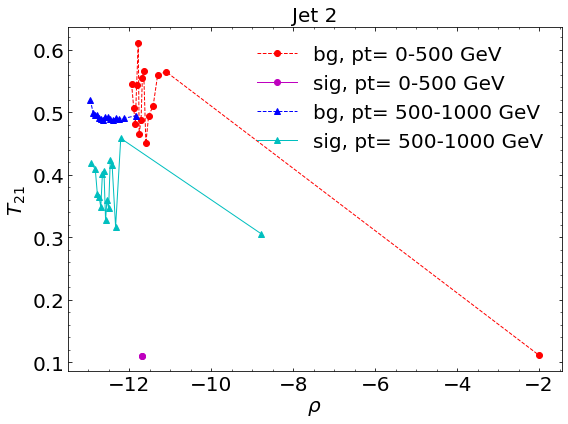

In [24]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.plot(avgrho_bgJ2_ro_500, avgrho_bgJ2_T21_500, 'o--', linewidth=1, color='r', label="bg, pt= 0-500 GeV")
plt.plot(avgrho_sigJ2_ro_500, avgrho_sigJ2_T21_500, 'o-', linewidth=1, color='m', label="sig, pt= 0-500 GeV")
plt.plot(avgrho_bgJ2_ro_1000, avgrho_bgJ2_T21_1000, '^--', linewidth=1, color='b', label="bg, pt= 500-1000 GeV")
plt.plot(avgrho_sigJ2_ro_1000, avgrho_sigJ2_T21_1000, '^-', linewidth=1, color='c', label="sig, pt= 500-1000 GeV")

plt.xlabel(r'${\rho}$',fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.title("Jet 2",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

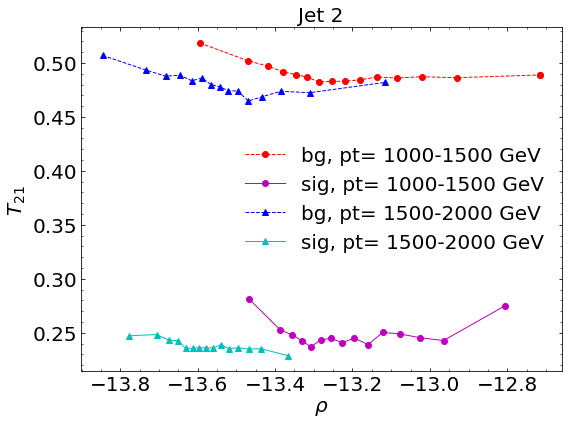

In [25]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.plot(avgrho_bgJ2_ro_1500, avgrho_bgJ2_T21_1500, 'o--', linewidth=1, color='r', label="bg, pt= 1000-1500 GeV")
plt.plot(avgrho_sigJ2_ro_1500, avgrho_sigJ2_T21_1500, 'o-', linewidth=1, color='m', label="sig, pt= 1000-1500 GeV")
plt.plot(avgrho_bgJ2_ro_2000, avgrho_bgJ2_T21_2000, '^--', linewidth=1, color='b', label="bg, pt= 1500-2000 GeV")
plt.plot(avgrho_sigJ2_ro_2000, avgrho_sigJ2_T21_2000, '^-', linewidth=1, color='c', label="sig, pt= 1500-2000 GeV")

plt.xlabel(r'${\rho}$',fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.title("Jet 2",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

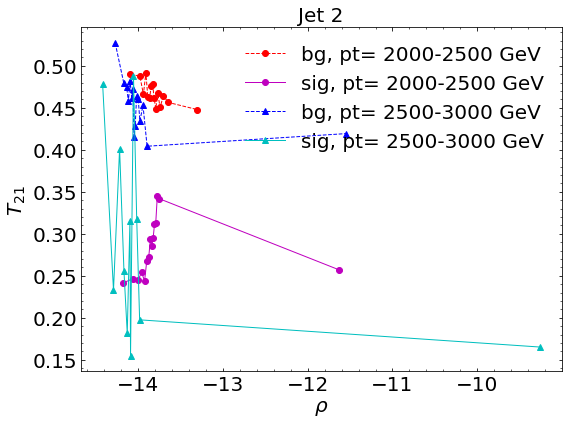

In [26]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.plot(avgrho_bgJ2_ro_2500, avgrho_bgJ2_T21_2500, 'o--', linewidth=1, color='r', label="bg, pt= 2000-2500 GeV")
plt.plot(avgrho_sigJ2_ro_2500, avgrho_sigJ2_T21_2500, 'o-', linewidth=1, color='m', label="sig, pt= 2000-2500 GeV")
plt.plot(avgrho_bgJ2_ro_3000, avgrho_bgJ2_T21_3000, '^--', linewidth=1, color='b', label="bg, pt= 2500-3000 GeV")
plt.plot(avgrho_sigJ2_ro_3000, avgrho_sigJ2_T21_3000, '^-', linewidth=1, color='c', label="sig, pt= 2500-3000 GeV")

plt.xlabel(r'${\rho}$',fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.title("Jet 2",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

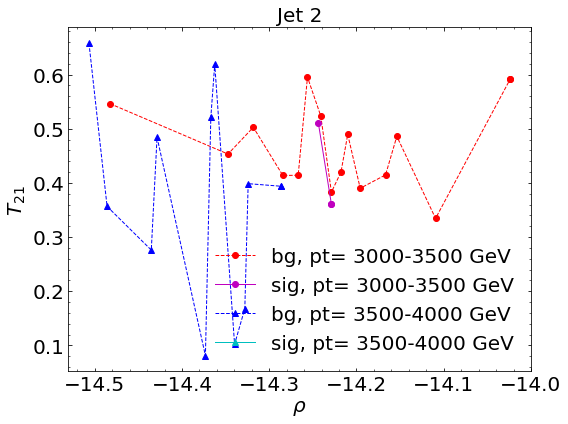

In [27]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.plot(avgrho_bgJ2_ro_3500, avgrho_bgJ2_T21_3500, 'o--', linewidth=1, color='r', label="bg, pt= 3000-3500 GeV")
plt.plot(avgrho_sigJ2_ro_3500, avgrho_sigJ2_T21_3500, 'o-', linewidth=1, color='m', label="sig, pt= 3000-3500 GeV")
plt.plot(avgrho_bgJ2_ro_4000, avgrho_bgJ2_T21_4000, '^--', linewidth=1, color='b', label="bg, pt= 3500-4000 GeV")
plt.plot(avgrho_sigJ2_ro_4000, avgrho_sigJ2_T21_4000, '^-', linewidth=1, color='c', label="sig, pt= 3500-4000 GeV")

plt.xlabel(r'${\rho}$',fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.title("Jet 2",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

In [28]:
grapf_jet1_bg.shape

(1000000, 3)

In [29]:
j1_bg_ro_pt500 = []
j1_bg_t21_pt500 = []

j1_bg_ro_pt1000 = []
j1_bg_t21_pt1000 = []

j1_bg_ro_pt1500 = []
j1_bg_t21_pt1500 = []

j1_bg_ro_pt2000 = []
j1_bg_t21_pt2000 = []

j1_bg_ro_pt2500 = []
j1_bg_t21_pt2500 = []

j1_bg_ro_pt3000 = []
j1_bg_t21_pt3000 = []

j1_bg_ro_pt3500 = []
j1_bg_t21_pt3500 = []

j1_bg_ro_pt4000 = []
j1_bg_t21_pt4000 = []

#1000000
for t in range(1000000):
    if grapf_jet1_bg[t][2] <= 500:
        j1_bg_ro_pt500.append(grapf_jet1_bg[t][1])
        j1_bg_t21_pt500.append(grapf_jet1_bg[t][0])
        
    elif (grapf_jet1_bg[t][2] > 500) and (grapf_jet1_bg[t][2] <= 1000):
        j1_bg_ro_pt1000.append(grapf_jet1_bg[t][1])
        j1_bg_t21_pt1000.append(grapf_jet1_bg[t][0])
        
    elif (grapf_jet1_bg[t][2] > 1000) and (grapf_jet1_bg[t][2] <= 1500):
        j1_bg_ro_pt1500.append(grapf_jet1_bg[t][1])
        j1_bg_t21_pt1500.append(grapf_jet1_bg[t][0])
        
    elif (grapf_jet1_bg[t][2] > 1500) and (grapf_jet1_bg[t][2] <= 2000):
        j1_bg_ro_pt2000.append(grapf_jet1_bg[t][1])
        j1_bg_t21_pt2000.append(grapf_jet1_bg[t][0])
        
    elif (grapf_jet1_bg[t][2] > 2000) and (grapf_jet1_bg[t][2] <= 2500):
        j1_bg_ro_pt2500.append(grapf_jet1_bg[t][1])
        j1_bg_t21_pt2500.append(grapf_jet1_bg[t][0])
    
    elif (grapf_jet1_bg[t][2] > 2500) and (grapf_jet1_bg[t][2] <= 3000):
        j1_bg_ro_pt3000.append(grapf_jet1_bg[t][1])
        j1_bg_t21_pt3000.append(grapf_jet1_bg[t][0])
        
    elif (grapf_jet1_bg[t][2] > 3000) and (grapf_jet1_bg[t][2] <= 3500):
        j1_bg_ro_pt3500.append(grapf_jet1_bg[t][1])
        j1_bg_t21_pt3500.append(grapf_jet1_bg[t][0])
        
    else:
        j1_bg_ro_pt4000.append(grapf_jet1_bg[t][1])
        j1_bg_t21_pt4000.append(grapf_jet1_bg[t][0])


data_j1_T21_ro_500 = pd.DataFrame({'ro': j1_bg_ro_pt500, 
                                   'T21': j1_bg_t21_pt500})
data_j1_T21_ro_1000 = pd.DataFrame({'ro': j1_bg_ro_pt1000, 
                                    'T21': j1_bg_t21_pt1000})
data_j1_T21_ro_1500 = pd.DataFrame({'ro': j1_bg_ro_pt1500, 
                                    'T21': j1_bg_t21_pt1500})
data_j1_T21_ro_2000 = pd.DataFrame({'ro': j1_bg_ro_pt2000, 
                                    'T21': j1_bg_t21_pt2000})
data_j1_T21_ro_2500 = pd.DataFrame({'ro': j1_bg_ro_pt2500, 
                                    'T21': j1_bg_t21_pt2500})
data_j1_T21_ro_3000 = pd.DataFrame({'ro': j1_bg_ro_pt3000, 
                                    'T21': j1_bg_t21_pt3000})
data_j1_T21_ro_3500 = pd.DataFrame({'ro': j1_bg_ro_pt3500, 
                                    'T21': j1_bg_t21_pt3500})
data_j1_T21_ro_4000 = pd.DataFrame({'ro': j1_bg_ro_pt4000, 
                                    'T21': j1_bg_t21_pt4000})




In [30]:
order_bgJ1_500 = data_j1_T21_ro_500.sort_values('ro')
order_bgJ1_1000 = data_j1_T21_ro_1000.sort_values('ro')
order_bgJ1_1500 = data_j1_T21_ro_1500.sort_values('ro')
order_bgJ1_2000 = data_j1_T21_ro_2000.sort_values('ro')
order_bgJ1_2500 = data_j1_T21_ro_2500.sort_values('ro')
order_bgJ1_3000 = data_j1_T21_ro_3000.sort_values('ro')
order_bgJ1_3500 = data_j1_T21_ro_3500.sort_values('ro')
order_bgJ1_4000 = data_j1_T21_ro_4000.sort_values('ro')


In [31]:
order_bgJ1_1000['ro']
order_bgJ1_500 

,ro,T21
436,-5.823467,0.669203
337,-5.812153,0.872772
34,-5.798047,0.745281
212,-5.789614,0.851576
588,-5.783321,0.750797
...,...,...
48,-4.566187,0.560808
41,-4.555739,0.616024
404,-4.540201,0.679240
510,-4.483910,0.436549


In [32]:
import math

N_bgJ1_500 = math.ceil(len(order_bgJ1_500['T21'])/15)
N_bgJ1_500

42

In [33]:
bgJ1_500 = order_bgJ1_500.to_numpy()
bgJ1_1000 = order_bgJ1_1000.to_numpy()
bgJ1_1500 = order_bgJ1_1500.to_numpy()
bgJ1_2000 = order_bgJ1_2000.to_numpy()
bgJ1_2500 = order_bgJ1_2500.to_numpy()
bgJ1_3000 = order_bgJ1_3000.to_numpy()
bgJ1_3500 = order_bgJ1_3500.to_numpy()
bgJ1_4000 = order_bgJ1_4000.to_numpy()

In [34]:
bgJ1_500[1][1]

0.8727720577114336

In [35]:
avg_bgJ1_T21_500 = []
avg_bgJ1_ro_500 = []

N_bgJ1_500 = math.ceil(len(order_bgJ1_500['T21'])/15)

i = 0
sum_bgJ1_T21_500 = 0
sum_bgJ1_ro_500 = 0

for n in range(len(bgJ1_500)):
    sum_bgJ1_T21_500 = sum_bgJ1_T21_500 + bgJ1_500[n][1]
    sum_bgJ1_ro_500 = sum_bgJ1_ro_500 + bgJ1_500[n][0]      
    i = i+1
        
    if i >= N_bgJ1_500:
            
        avg_bgJ1_T21_500.append(sum_bgJ1_T21_500/N_bgJ1_500)
        avg_bgJ1_ro_500.append(sum_bgJ1_ro_500/N_bgJ1_500)
        sum_bgJ1_T21_500 = 0
        sum_bgJ1_ro_500 = 0
        i = 0
        
    """  """ 
    if n == len(bgJ1_500)-1:
        avg_bgJ1_T21_500.append(sum_bgJ1_T21_500/N_bgJ1_500)
        avg_bgJ1_ro_500.append(sum_bgJ1_ro_500/N_bgJ1_500)
         
    
avg_bgJ1_ro_500
    

[-5.75362796526011,
 -5.715527591456306,
 -5.688902047164635,
 -5.661595202371614,
 -5.636189792134983,
 -5.611535814153017,
 -5.574872160645502,
 -5.541729360948798,
 -5.505548958402739,
 -5.451803285088452,
 -5.379049098212856,
 -5.306246981168844,
 -5.214299475647054,
 -5.091595008050461,
 -3.3168502125180446]

In [36]:
avg_bgJ1_T21_1000 = []
avg_bgJ1_ro_1000 = []

N_bgJ1_1000 = math.ceil(len(order_bgJ1_1000['T21'])/15)

i = 0
sum_bgJ1_T21_1000 = 0
sum_bgJ1_ro_1000 = 0

for n in range(len(bgJ1_1000)):
    sum_bgJ1_T21_1000 = sum_bgJ1_T21_1000 + bgJ1_1000[n][1]
    sum_bgJ1_ro_1000 = sum_bgJ1_ro_1000 + bgJ1_1000[n][0]      
    i = i+1
    
    if n == len(bgJ1_1000)-1:
        avg_bgJ1_T21_1000.append(sum_bgJ1_T21_1000/N_bgJ1_1000)
        avg_bgJ1_ro_1000.append(sum_bgJ1_ro_1000/N_bgJ1_1000)
        
    if i >= N_bgJ1_1000:
        avg_bgJ1_T21_1000.append(sum_bgJ1_T21_1000/N_bgJ1_1000)
        avg_bgJ1_ro_1000.append(sum_bgJ1_ro_1000/N_bgJ1_1000)
        sum_bgJ1_T21_1000 = 0
        sum_bgJ1_ro_1000 = 0
        i = 0

        
avg_bgJ1_T21_1500 = []
avg_bgJ1_ro_1500 = []

N_bgJ1_1500 = math.ceil(len(order_bgJ1_1500['T21'])/15)

i = 0
sum_bgJ1_T21_1500 = 0
sum_bgJ1_ro_1500 = 0

for n in range(len(bgJ1_1500)):
    sum_bgJ1_T21_1500 = sum_bgJ1_T21_1500 + bgJ1_1500[n][1]
    sum_bgJ1_ro_1500 = sum_bgJ1_ro_1500 + bgJ1_1500[n][0]      
    i = i+1
    
    if n == len(bgJ1_1500)-1:
        avg_bgJ1_T21_1500.append(sum_bgJ1_T21_1500/N_bgJ1_1500)
        avg_bgJ1_ro_1500.append(sum_bgJ1_ro_1500/N_bgJ1_1500)
        
    if i >= N_bgJ1_1500:
        avg_bgJ1_T21_1500.append(sum_bgJ1_T21_1500/N_bgJ1_1500)
        avg_bgJ1_ro_1500.append(sum_bgJ1_ro_1500/N_bgJ1_1500)
        sum_bgJ1_T21_1500 = 0
        sum_bgJ1_ro_1500 = 0
        i = 0


        
avg_bgJ1_T21_2000 = []
avg_bgJ1_ro_2000 = []

N_bgJ1_2000 = math.ceil(len(order_bgJ1_2000['T21'])/15)

i = 0
sum_bgJ1_T21_2000 = 0
sum_bgJ1_ro_2000 = 0

for n in range(len(bgJ1_2000)):
    sum_bgJ1_T21_2000 = sum_bgJ1_T21_2000 + bgJ1_2000[n][1]
    sum_bgJ1_ro_2000 = sum_bgJ1_ro_2000 + bgJ1_2000[n][0]      
    i = i+1
    
    if n == len(bgJ1_2000)-1:
        avg_bgJ1_T21_2000.append(sum_bgJ1_T21_2000/N_bgJ1_2000)
        avg_bgJ1_ro_2000.append(sum_bgJ1_ro_2000/N_bgJ1_2000)
        
    if i >= N_bgJ1_2000:
        avg_bgJ1_T21_2000.append(sum_bgJ1_T21_2000/N_bgJ1_2000)
        avg_bgJ1_ro_2000.append(sum_bgJ1_ro_2000/N_bgJ1_2000)
        sum_bgJ1_T21_2000 = 0
        sum_bgJ1_ro_2000 = 0
        i = 0

        
avg_bgJ1_T21_2500 = []
avg_bgJ1_ro_2500 = []

N_bgJ1_2500 = math.ceil(len(order_bgJ1_2500['T21'])/15)

i = 0
sum_bgJ1_T21_2500 = 0
sum_bgJ1_ro_2500 = 0

for n in range(len(bgJ1_2500)):
    sum_bgJ1_T21_2500 = sum_bgJ1_T21_2500 + bgJ1_2500[n][1]
    sum_bgJ1_ro_2500 = sum_bgJ1_ro_2500 + bgJ1_2500[n][0]      
    i = i+1
    
    if n == len(bgJ1_2500)-1:
        avg_bgJ1_T21_2500.append(sum_bgJ1_T21_2500/N_bgJ1_2500)
        avg_bgJ1_ro_2500.append(sum_bgJ1_ro_2500/N_bgJ1_2500)
        
    if i >= N_bgJ1_2500:
        avg_bgJ1_T21_2500.append(sum_bgJ1_T21_2500/N_bgJ1_2500)
        avg_bgJ1_ro_2500.append(sum_bgJ1_ro_2500/N_bgJ1_2500)
        sum_bgJ1_T21_2500 = 0
        sum_bgJ1_ro_2500 = 0
        i = 0


avg_bgJ1_T21_3000 = []
avg_bgJ1_ro_3000 = []

N_bgJ1_3000 = math.ceil(len(order_bgJ1_3000['T21'])/15)

i = 0
sum_bgJ1_T21_3000 = 0
sum_bgJ1_ro_3000 = 0

for n in range(len(bgJ1_3000)):
    sum_bgJ1_T21_3000 = sum_bgJ1_T21_3000 + bgJ1_3000[n][1]
    sum_bgJ1_ro_3000 = sum_bgJ1_ro_3000 + bgJ1_3000[n][0]      
    i = i+1
    
    if n == len(bgJ1_3000)-1:
        avg_bgJ1_T21_3000.append(sum_bgJ1_T21_3000/N_bgJ1_3000)
        avg_bgJ1_ro_3000.append(sum_bgJ1_ro_3000/N_bgJ1_3000)
        
    if i >= N_bgJ1_3000:
        avg_bgJ1_T21_3000.append(sum_bgJ1_T21_3000/N_bgJ1_3000)
        avg_bgJ1_ro_3000.append(sum_bgJ1_ro_3000/N_bgJ1_3000)
        sum_bgJ1_T21_3000 = 0
        sum_bgJ1_ro_3000 = 0
        i = 0

        
avg_bgJ1_T21_3500 = []
avg_bgJ1_ro_3500 = []

N_bgJ1_3500 = math.ceil(len(order_bgJ1_3500['T21'])/15)

i = 0
sum_bgJ1_T21_3500 = 0
sum_bgJ1_ro_3500 = 0

for n in range(len(bgJ1_3500)):
    sum_bgJ1_T21_3500 = sum_bgJ1_T21_3500 + bgJ1_3500[n][1]
    sum_bgJ1_ro_3500 = sum_bgJ1_ro_3500 + bgJ1_3500[n][0]      
    i = i+1
    
    if n == len(bgJ1_3500)-1:
        avg_bgJ1_T21_3500.append(sum_bgJ1_T21_3500/N_bgJ1_3500)
        avg_bgJ1_ro_3500.append(sum_bgJ1_ro_3500/N_bgJ1_3500)
        
    if i >= N_bgJ1_3500:
        avg_bgJ1_T21_3500.append(sum_bgJ1_T21_3500/N_bgJ1_3500)
        avg_bgJ1_ro_3500.append(sum_bgJ1_ro_3500/N_bgJ1_3500)
        sum_bgJ1_T21_3500 = 0
        sum_bgJ1_ro_3500 = 0
        i = 0


avg_bgJ1_T21_4000 = []
avg_bgJ1_ro_4000 = []

N_bgJ1_4000 = math.ceil(len(order_bgJ1_4000['T21'])/15)

i = 0
sum_bgJ1_T21_4000 = 0
sum_bgJ1_ro_4000 = 0

for n in range(len(bgJ1_4000)):
    sum_bgJ1_T21_4000 = sum_bgJ1_T21_4000 + bgJ1_4000[n][1]
    sum_bgJ1_ro_4000 = sum_bgJ1_ro_4000 + bgJ1_4000[n][0]      
    i = i+1
    
    if n == len(bgJ1_4000)-1:
        avg_bgJ1_T21_4000.append(sum_bgJ1_T21_4000/N_bgJ1_4000)
        avg_bgJ1_ro_4000.append(sum_bgJ1_ro_4000/N_bgJ1_4000)
        
    if i >= N_bgJ1_4000:
        avg_bgJ1_T21_4000.append(sum_bgJ1_T21_4000/N_bgJ1_4000)
        avg_bgJ1_ro_4000.append(sum_bgJ1_ro_4000/N_bgJ1_4000)
        sum_bgJ1_T21_4000 = 0
        sum_bgJ1_ro_4000 = 0
        i = 0

In [37]:
grapf_jet1_sig.shape

(100000, 3)

In [38]:
j1_sig_ro_pt500 = []
j1_sig_t21_pt500 = []

j1_sig_ro_pt1000 = []
j1_sig_t21_pt1000 = []

j1_sig_ro_pt1500 = []
j1_sig_t21_pt1500 = []

j1_sig_ro_pt2000 = []
j1_sig_t21_pt2000 = []

j1_sig_ro_pt2500 = []
j1_sig_t21_pt2500 = []

j1_sig_ro_pt3000 = []
j1_sig_t21_pt3000 = []

j1_sig_ro_pt3500 = []
j1_sig_t21_pt3500 = []

j1_sig_ro_pt4000 = []
j1_sig_t21_pt4000 = []

#1000000
for t in range(100000):
    if grapf_jet1_sig[t][2] <= 500:
        j1_sig_ro_pt500.append(grapf_jet1_sig[t][1])
        j1_sig_t21_pt500.append(grapf_jet1_sig[t][0])
        
    elif (grapf_jet1_sig[t][2] > 500) and (grapf_jet1_sig[t][2] <= 1000):
        j1_sig_ro_pt1000.append(grapf_jet1_sig[t][1])
        j1_sig_t21_pt1000.append(grapf_jet1_sig[t][0])
        
    elif (grapf_jet1_sig[t][2] > 1000) and (grapf_jet1_sig[t][2] <= 1500):
        j1_sig_ro_pt1500.append(grapf_jet1_sig[t][1])
        j1_sig_t21_pt1500.append(grapf_jet1_sig[t][0])
        
    elif (grapf_jet1_sig[t][2] > 1500) and (grapf_jet1_sig[t][2] <= 2000):
        j1_sig_ro_pt2000.append(grapf_jet1_sig[t][1])
        j1_sig_t21_pt2000.append(grapf_jet1_sig[t][0])
        
    elif (grapf_jet1_sig[t][2] > 2000) and (grapf_jet1_sig[t][2] <= 2500):
        j1_sig_ro_pt2500.append(grapf_jet1_sig[t][1])
        j1_sig_t21_pt2500.append(grapf_jet1_sig[t][0])
    
    elif (grapf_jet1_sig[t][2] > 2500) and (grapf_jet1_sig[t][2] <= 3000):
        j1_sig_ro_pt3000.append(grapf_jet1_sig[t][1])
        j1_sig_t21_pt3000.append(grapf_jet1_sig[t][0])
        
    elif (grapf_jet1_sig[t][2] > 3000) and (grapf_jet1_sig[t][2] <= 3500):
        j1_sig_ro_pt3500.append(grapf_jet1_sig[t][1])
        j1_sig_t21_pt3500.append(grapf_jet1_sig[t][0])
        
    else:
        j1_sig_ro_pt4000.append(grapf_jet1_sig[t][1])
        j1_sig_t21_pt4000.append(grapf_jet1_sig[t][0])


data_j1_sig_T21_ro_500 = pd.DataFrame({'ro': j1_sig_ro_pt500, 
                                       'T21': j1_sig_t21_pt500})
data_j1_sig_T21_ro_1000 = pd.DataFrame({'ro': j1_sig_ro_pt1000, 
                                        'T21': j1_sig_t21_pt1000})
data_j1_sig_T21_ro_1500 = pd.DataFrame({'ro': j1_sig_ro_pt1500, 
                                        'T21': j1_sig_t21_pt1500})
data_j1_sig_T21_ro_2000 = pd.DataFrame({'ro': j1_sig_ro_pt2000, 
                                        'T21': j1_sig_t21_pt2000})
data_j1_sig_T21_ro_2500 = pd.DataFrame({'ro': j1_sig_ro_pt2500, 
                                        'T21': j1_sig_t21_pt2500})
data_j1_sig_T21_ro_3000 = pd.DataFrame({'ro': j1_sig_ro_pt3000, 
                                        'T21': j1_sig_t21_pt3000})
data_j1_sig_T21_ro_3500 = pd.DataFrame({'ro': j1_sig_ro_pt3500, 
                                        'T21': j1_sig_t21_pt3500})
data_j1_sig_T21_ro_4000 = pd.DataFrame({'ro': j1_sig_ro_pt4000, 
                                        'T21': j1_sig_t21_pt4000})




In [39]:
order_sigJ1_500 = data_j1_sig_T21_ro_500.sort_values('ro')
order_sigJ1_1000 = data_j1_sig_T21_ro_1000.sort_values('ro')
order_sigJ1_1500 = data_j1_sig_T21_ro_1500.sort_values('ro')
order_sigJ1_2000 = data_j1_sig_T21_ro_2000.sort_values('ro')
order_sigJ1_2500 = data_j1_sig_T21_ro_2500.sort_values('ro')
order_sigJ1_3000 = data_j1_sig_T21_ro_3000.sort_values('ro')
order_sigJ1_3500 = data_j1_sig_T21_ro_3500.sort_values('ro')
order_sigJ1_4000 = data_j1_sig_T21_ro_4000.sort_values('ro')


In [40]:
sigJ1_500 = order_sigJ1_500.to_numpy()
sigJ1_1000 = order_sigJ1_1000.to_numpy()
sigJ1_1500 = order_sigJ1_1500.to_numpy()
sigJ1_2000 = order_sigJ1_2000.to_numpy()
sigJ1_2500 = order_sigJ1_2500.to_numpy()
sigJ1_3000 = order_sigJ1_3000.to_numpy()
sigJ1_3500 = order_sigJ1_3500.to_numpy()
sigJ1_4000 = order_sigJ1_4000.to_numpy()

In [41]:
avg_sigJ1_T21_500 = []
avg_sigJ1_ro_500 = []

avg_sigJ1_T21_1000 = []
avg_sigJ1_ro_1000 = []

avg_sigJ1_T21_1500 = []
avg_sigJ1_ro_1500 = []

avg_sigJ1_T21_2000 = []
avg_sigJ1_ro_2000 = []

avg_sigJ1_T21_2500 = []
avg_sigJ1_ro_2500 = []

avg_sigJ1_T21_3000 = []
avg_sigJ1_ro_3000 = []

avg_sigJ1_T21_3500 = []
avg_sigJ1_ro_3500 = []

avg_sigJ1_T21_4000 = []
avg_sigJ1_ro_4000 = []



N_sigJ1_500 = math.ceil(len(order_sigJ1_500['T21'])/15)

i = 0
sum_sigJ1_T21_500 = 0
sum_sigJ1_ro_500 = 0

for n in range(len(sigJ1_500)):
    sum_sigJ1_T21_500 = sum_sigJ1_T21_500 + sigJ1_500[n][1]
    sum_sigJ1_ro_500 = sum_sigJ1_ro_500 + sigJ1_500[n][0]      
    i = i+1
        
    if i >= N_sigJ1_500:
            
        avg_sigJ1_T21_500.append(sum_sigJ1_T21_500/N_sigJ1_500)
        avg_sigJ1_ro_500.append(sum_sigJ1_ro_500/N_sigJ1_500)
        sum_sigJ1_T21_500 = 0
        sum_sigJ1_ro_500 = 0
        i = 0
        
    """  """ 
    if n == len(sigJ1_500)-1:
        avg_sigJ1_T21_500.append(sum_sigJ1_T21_500/N_sigJ1_500)
        avg_sigJ1_ro_500.append(sum_sigJ1_ro_500/N_sigJ1_500)
         


N_sigJ1_1000 = math.ceil(len(order_sigJ1_1000['T21'])/15)

i = 0
sum_sigJ1_T21_1000 = 0
sum_sigJ1_ro_1000 = 0

for n in range(len(sigJ1_1000)):
    sum_sigJ1_T21_1000 = sum_sigJ1_T21_1000 + sigJ1_1000[n][1]
    sum_sigJ1_ro_1000 = sum_sigJ1_ro_1000 + sigJ1_1000[n][0]      
    i = i+1
        
    if i >= N_sigJ1_1000:
            
        avg_sigJ1_T21_1000.append(sum_sigJ1_T21_1000/N_sigJ1_1000)
        avg_sigJ1_ro_1000.append(sum_sigJ1_ro_1000/N_sigJ1_1000)
        sum_sigJ1_T21_1000 = 0
        sum_sigJ1_ro_1000 = 0
        i = 0
        
    """  """ 
    if n == len(sigJ1_1000)-1:
        avg_sigJ1_T21_1000.append(sum_sigJ1_T21_1000/N_sigJ1_1000)
        avg_sigJ1_ro_1000.append(sum_sigJ1_ro_1000/N_sigJ1_1000)
        
        
        
N_sigJ1_1500 = math.ceil(len(order_sigJ1_1500['T21'])/15)

i = 0
sum_sigJ1_T21_1500 = 0
sum_sigJ1_ro_1500 = 0

for n in range(len(sigJ1_1500)):
    sum_sigJ1_T21_1500 = sum_sigJ1_T21_1500 + sigJ1_1500[n][1]
    sum_sigJ1_ro_1500 = sum_sigJ1_ro_1500 + sigJ1_1500[n][0]      
    i = i+1
        
    if i >= N_sigJ1_1500:
            
        avg_sigJ1_T21_1500.append(sum_sigJ1_T21_1500/N_sigJ1_1500)
        avg_sigJ1_ro_1500.append(sum_sigJ1_ro_1500/N_sigJ1_1500)
        sum_sigJ1_T21_1500 = 0
        sum_sigJ1_ro_1500 = 0
        i = 0
        
    """  """ 
    if n == len(sigJ1_1500)-1:
        avg_sigJ1_T21_1500.append(sum_sigJ1_T21_1500/N_sigJ1_1500)
        avg_sigJ1_ro_1500.append(sum_sigJ1_ro_1500/N_sigJ1_1500)
        
        
        
N_sigJ1_2000 = math.ceil(len(order_sigJ1_2000['T21'])/15)

i = 0
sum_sigJ1_T21_2000 = 0
sum_sigJ1_ro_2000 = 0

for n in range(len(sigJ1_2000)):
    sum_sigJ1_T21_2000 = sum_sigJ1_T21_2000 + sigJ1_2000[n][1]
    sum_sigJ1_ro_2000 = sum_sigJ1_ro_2000 + sigJ1_2000[n][0]      
    i = i+1
        
    if i >= N_sigJ1_2000:
            
        avg_sigJ1_T21_2000.append(sum_sigJ1_T21_2000/N_sigJ1_2000)
        avg_sigJ1_ro_2000.append(sum_sigJ1_ro_2000/N_sigJ1_2000)
        sum_sigJ1_T21_2000 = 0
        sum_sigJ1_ro_2000 = 0
        i = 0
        
    """  """ 
    if n == len(sigJ1_2000)-1:
        avg_sigJ1_T21_2000.append(sum_sigJ1_T21_2000/N_sigJ1_2000)
        avg_sigJ1_ro_2000.append(sum_sigJ1_ro_2000/N_sigJ1_2000)
        
        
        
N_sigJ1_2500 = math.ceil(len(order_sigJ1_2500['T21'])/15)

i = 0
sum_sigJ1_T21_2500 = 0
sum_sigJ1_ro_2500 = 0

for n in range(len(sigJ1_2500)):
    sum_sigJ1_T21_2500 = sum_sigJ1_T21_2500 + sigJ1_2500[n][1]
    sum_sigJ1_ro_2500 = sum_sigJ1_ro_2500 + sigJ1_2500[n][0]      
    i = i+1
        
    if i >= N_sigJ1_2500:
            
        avg_sigJ1_T21_2500.append(sum_sigJ1_T21_2500/N_sigJ1_2500)
        avg_sigJ1_ro_2500.append(sum_sigJ1_ro_2500/N_sigJ1_2500)
        sum_sigJ1_T21_2500 = 0
        sum_sigJ1_ro_2500 = 0
        i = 0
        
    """  """ 
    if n == len(sigJ1_2500)-1:
        avg_sigJ1_T21_2500.append(sum_sigJ1_T21_2500/N_sigJ1_2500)
        avg_sigJ1_ro_2500.append(sum_sigJ1_ro_2500/N_sigJ1_2500)
        
        

N_sigJ1_3000 = math.ceil(len(order_sigJ1_3000['T21'])/15)

i = 0
sum_sigJ1_T21_3000 = 0
sum_sigJ1_ro_3000 = 0

for n in range(len(sigJ1_3000)):
    sum_sigJ1_T21_3000 = sum_sigJ1_T21_3000 + sigJ1_3000[n][1]
    sum_sigJ1_ro_3000 = sum_sigJ1_ro_3000 + sigJ1_3000[n][0]      
    i = i+1
        
    if i >= N_sigJ1_3000:
            
        avg_sigJ1_T21_3000.append(sum_sigJ1_T21_3000/N_sigJ1_3000)
        avg_sigJ1_ro_3000.append(sum_sigJ1_ro_3000/N_sigJ1_3000)
        sum_sigJ1_T21_3000 = 0
        sum_sigJ1_ro_3000 = 0
        i = 0
        
    """  """ 
    if n == len(sigJ1_3000)-1:
        avg_sigJ1_T21_3000.append(sum_sigJ1_T21_3000/N_sigJ1_3000)
        avg_sigJ1_ro_3000.append(sum_sigJ1_ro_3000/N_sigJ1_3000)
        
        
        
N_sigJ1_3500 = math.ceil(len(order_sigJ1_3500['T21'])/15)

i = 0
sum_sigJ1_T21_3500 = 0
sum_sigJ1_ro_3500 = 0

for n in range(len(sigJ1_3500)):
    sum_sigJ1_T21_3500 = sum_sigJ1_T21_3500 + sigJ1_3500[n][1]
    sum_sigJ1_ro_3500 = sum_sigJ1_ro_3500 + sigJ1_3500[n][0]      
    i = i+1
        
    if i >= N_sigJ1_3500:
            
        avg_sigJ1_T21_3500.append(sum_sigJ1_T21_3500/N_sigJ1_3500)
        avg_sigJ1_ro_3500.append(sum_sigJ1_ro_3500/N_sigJ1_3500)
        sum_sigJ1_T21_3500 = 0
        sum_sigJ1_ro_3500 = 0
        i = 0
        
    """  """ 
    if n == len(sigJ1_3500)-1:
        avg_sigJ1_T21_3500.append(sum_sigJ1_T21_3500/N_sigJ1_3500)
        avg_sigJ1_ro_3500.append(sum_sigJ1_ro_3500/N_sigJ1_3500)
        
        

N_sigJ1_4000 = math.ceil(len(order_sigJ1_4000['T21'])/15)

i = 0
sum_sigJ1_T21_4000 = 0
sum_sigJ1_ro_4000 = 0

for n in range(len(sigJ1_4000)):
    sum_sigJ1_T21_4000 = sum_sigJ1_T21_4000 + sigJ1_4000[n][1]
    sum_sigJ1_ro_4000 = sum_sigJ1_ro_4000 + sigJ1_4000[n][0]      
    i = i+1
        
    if i >= N_sigJ1_4000:
            
        avg_sigJ1_T21_4000.append(sum_sigJ1_T21_4000/N_sigJ1_4000)
        avg_sigJ1_ro_4000.append(sum_sigJ1_ro_4000/N_sigJ1_4000)
        sum_sigJ1_T21_4000 = 0
        sum_sigJ1_ro_4000 = 0
        i = 0
        
    """  """ 
    if n == len(sigJ1_4000)-1:
        avg_sigJ1_T21_4000.append(sum_sigJ1_T21_4000/N_sigJ1_4000)
        avg_sigJ1_ro_4000.append(sum_sigJ1_ro_4000/N_sigJ1_4000)

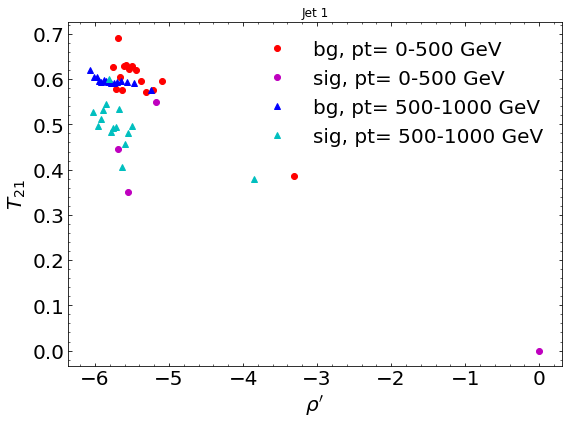

In [42]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ1_ro_500, avg_bgJ1_T21_500, 'o', linewidth=1, color='r', label="bg, pt= 0-500 GeV")
plt.plot(avg_sigJ1_ro_500, avg_sigJ1_T21_500, 'o', linewidth=1, color='m', label="sig, pt= 0-500 GeV")
plt.plot(avg_bgJ1_ro_1000, avg_bgJ1_T21_1000, '^', linewidth=1, color='b', label="bg, pt= 500-1000 GeV")
plt.plot(avg_sigJ1_ro_1000, avg_sigJ1_T21_1000, '^', linewidth=1, color='c', label="sig, pt= 500-1000 GeV")

#plt.plot(avg_sigJ1_ro_1500, avg_sigJ1_T21_1500, 'v-', linewidth=1, color='g', label="sig, pt= 1000-1500")
#plt.plot(avg_sigJ1_ro_2000, avg_sigJ1_T21_2000, '*-', linewidth=1, color='m', label="sig, pt= 1500-2000")

plt.title("Jet 1")
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

(0.0, 1.0)

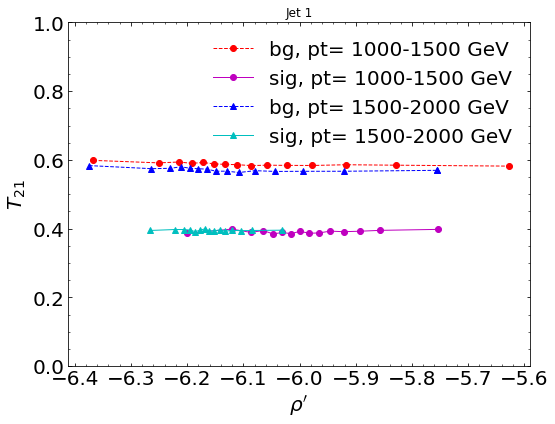

In [43]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ1_ro_1500, avg_bgJ1_T21_1500, 'o--', linewidth=1, color='r', label="bg, pt= 1000-1500 GeV")
plt.plot(avg_sigJ1_ro_1500, avg_sigJ1_T21_1500, 'o-', linewidth=1, color='m', label="sig, pt= 1000-1500 GeV")
plt.plot(avg_bgJ1_ro_2000, avg_bgJ1_T21_2000, '^--', linewidth=1, color='b', label="bg, pt= 1500-2000 GeV")
plt.plot(avg_sigJ1_ro_2000, avg_sigJ1_T21_2000, '^-', linewidth=1, color='c', label="sig, pt= 1500-2000 GeV")


plt.title("Jet 1")
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

(-6.7, -4.5)

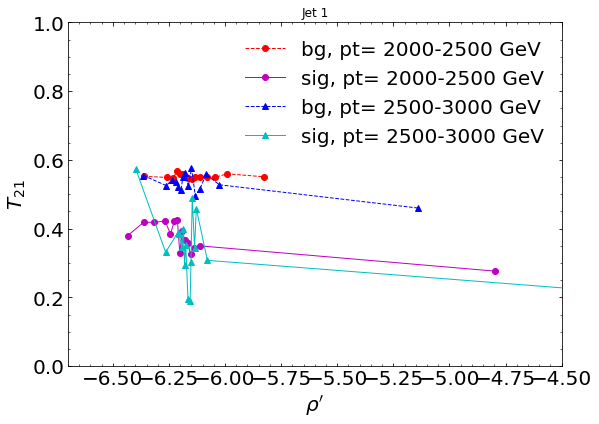

In [44]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ1_ro_2500, avg_bgJ1_T21_2500, 'o--', linewidth=1, color='r', label="bg, pt= 2000-2500 GeV")
plt.plot(avg_sigJ1_ro_2500, avg_sigJ1_T21_2500, 'o-', linewidth=1, color='m', label="sig, pt= 2000-2500 GeV")
plt.plot(avg_bgJ1_ro_3000, avg_bgJ1_T21_3000, '^--', linewidth=1, color='b', label="bg, pt= 2500-3000 GeV")
plt.plot(avg_sigJ1_ro_3000, avg_sigJ1_T21_3000, '^-', linewidth=1, color='c', label="sig, pt= 2500-3000 GeV")


plt.title("Jet 1")
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])
plt.xlim([-6.7,-4.5])

(0.0, 1.0)

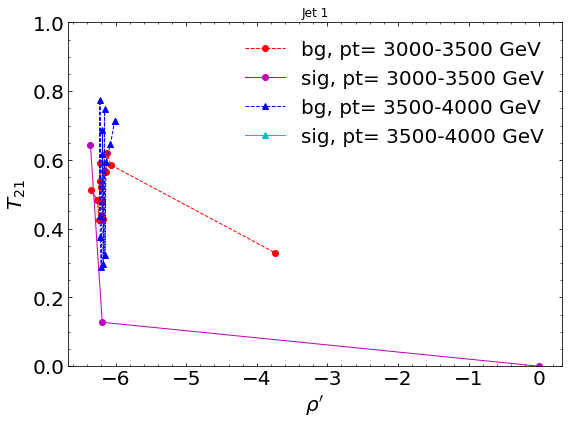

In [45]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ1_ro_3500, avg_bgJ1_T21_3500, 'o--', linewidth=1, color='r', label="bg, pt= 3000-3500 GeV")
plt.plot(avg_sigJ1_ro_3500, avg_sigJ1_T21_3500, 'o-', linewidth=1, color='m', label="sig, pt= 3000-3500 GeV")
plt.plot(avg_bgJ1_ro_4000, avg_bgJ1_T21_4000, '^--', linewidth=1, color='b', label="bg, pt= 3500-4000 GeV")
plt.plot(avg_sigJ1_ro_4000, avg_sigJ1_T21_4000, '^-', linewidth=1, color='c', label="sig, pt= 3500-4000 GeV")


plt.title("Jet 1")
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

In [46]:
alpha = 0.1

def load_data_J2(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 2
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
       
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    #cada jet
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"] 
    dataset["pTjTwo"] = dataset["pTjTwo"]*1000
    
    #ro
    dataset["rojTwo"] = np.log(dataset["mjj"]/dataset["pTjTwo"])
    


    dataset = dataset.fillna(0)
    dataset = dataset[["tau21jTwo", "rojTwo", "pTjTwo"]]
    return dataset.to_numpy()


In [47]:
grapf_jet2_bg = load_data_J2(features_bg)
grapf_jet2_sig = load_data_J2(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2440632181.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2440632181.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [48]:
grapf_jet2_bg.shape

(1000000, 3)

In [49]:
j2_bg_ro_pt500 = []
j2_bg_t21_pt500 = []

j2_bg_ro_pt1000 = []
j2_bg_t21_pt1000 = []

j2_bg_ro_pt1500 = []
j2_bg_t21_pt1500 = []

j2_bg_ro_pt2000 = []
j2_bg_t21_pt2000 = []

j2_bg_ro_pt2500 = []
j2_bg_t21_pt2500 = []

j2_bg_ro_pt3000 = []
j2_bg_t21_pt3000 = []

j2_bg_ro_pt3500 = []
j2_bg_t21_pt3500 = []

j2_bg_ro_pt4000 = []
j2_bg_t21_pt4000 = []

#1000000
for t in range(1000000):
    if grapf_jet2_bg[t][2] <= 500:
        j2_bg_ro_pt500.append(grapf_jet2_bg[t][1])
        j2_bg_t21_pt500.append(grapf_jet2_bg[t][0])
        
    elif (grapf_jet2_bg[t][2] > 500) and (grapf_jet2_bg[t][2] <= 1000):
        j2_bg_ro_pt1000.append(grapf_jet2_bg[t][1])
        j2_bg_t21_pt1000.append(grapf_jet2_bg[t][0])
        
    elif (grapf_jet2_bg[t][2] > 1000) and (grapf_jet2_bg[t][2] <= 1500):
        j2_bg_ro_pt1500.append(grapf_jet2_bg[t][1])
        j2_bg_t21_pt1500.append(grapf_jet2_bg[t][0])
        
    elif (grapf_jet2_bg[t][2] > 1500) and (grapf_jet2_bg[t][2] <= 2000):
        j2_bg_ro_pt2000.append(grapf_jet2_bg[t][1])
        j2_bg_t21_pt2000.append(grapf_jet2_bg[t][0])
        
    elif (grapf_jet2_bg[t][2] > 2000) and (grapf_jet2_bg[t][2] <= 2500):
        j2_bg_ro_pt2500.append(grapf_jet2_bg[t][1])
        j2_bg_t21_pt2500.append(grapf_jet2_bg[t][0])
    
    elif (grapf_jet2_bg[t][2] > 2500) and (grapf_jet2_bg[t][2] <= 3000):
        j2_bg_ro_pt3000.append(grapf_jet2_bg[t][1])
        j2_bg_t21_pt3000.append(grapf_jet2_bg[t][0])
        
    elif (grapf_jet2_bg[t][2] > 3000) and (grapf_jet2_bg[t][2] <= 3500):
        j2_bg_ro_pt3500.append(grapf_jet2_bg[t][1])
        j2_bg_t21_pt3500.append(grapf_jet2_bg[t][0])
        
    else:
        j2_bg_ro_pt4000.append(grapf_jet2_bg[t][1])
        j2_bg_t21_pt4000.append(grapf_jet2_bg[t][0])


data_j2_T21_ro_500 = pd.DataFrame({'ro': j2_bg_ro_pt500, 
                                   'T21': j2_bg_t21_pt500})
data_j2_T21_ro_1000 = pd.DataFrame({'ro': j2_bg_ro_pt1000, 
                                    'T21': j2_bg_t21_pt1000})
data_j2_T21_ro_1500 = pd.DataFrame({'ro': j2_bg_ro_pt1500, 
                                    'T21': j2_bg_t21_pt1500})
data_j2_T21_ro_2000 = pd.DataFrame({'ro': j2_bg_ro_pt2000, 
                                    'T21': j2_bg_t21_pt2000})
data_j2_T21_ro_2500 = pd.DataFrame({'ro': j2_bg_ro_pt2500, 
                                    'T21': j2_bg_t21_pt2500})
data_j2_T21_ro_3000 = pd.DataFrame({'ro': j2_bg_ro_pt3000, 
                                    'T21': j2_bg_t21_pt3000})
data_j2_T21_ro_3500 = pd.DataFrame({'ro': j2_bg_ro_pt3500, 
                                    'T21': j2_bg_t21_pt3500})
data_j2_T21_ro_4000 = pd.DataFrame({'ro': j2_bg_ro_pt4000, 
                                    'T21': j2_bg_t21_pt4000})




In [50]:
order_bgJ2_500 = data_j2_T21_ro_500.sort_values('ro')
order_bgJ2_1000 = data_j2_T21_ro_1000.sort_values('ro')
order_bgJ2_1500 = data_j2_T21_ro_1500.sort_values('ro')
order_bgJ2_2000 = data_j2_T21_ro_2000.sort_values('ro')
order_bgJ2_2500 = data_j2_T21_ro_2500.sort_values('ro')
order_bgJ2_3000 = data_j2_T21_ro_3000.sort_values('ro')
order_bgJ2_3500 = data_j2_T21_ro_3500.sort_values('ro')
order_bgJ2_4000 = data_j2_T21_ro_4000.sort_values('ro')

In [51]:
bgJ2_500 = order_bgJ2_500.to_numpy()
bgJ2_1000 = order_bgJ2_1000.to_numpy()
bgJ2_1500 = order_bgJ2_1500.to_numpy()
bgJ2_2000 = order_bgJ2_2000.to_numpy()
bgJ2_2500 = order_bgJ2_2500.to_numpy()
bgJ2_3000 = order_bgJ2_3000.to_numpy()
bgJ2_3500 = order_bgJ2_3500.to_numpy()
bgJ2_4000 = order_bgJ2_4000.to_numpy()

In [52]:
avg_bgJ2_T21_500 = []
avg_bgJ2_ro_500 = []

N_bgJ2_500 = math.ceil(len(order_bgJ2_500['T21'])/15)

i = 0
sum_bgJ2_T21_500 = 0
sum_bgJ2_ro_500 = 0

for n in range(len(bgJ2_500)):
    sum_bgJ2_T21_500 = sum_bgJ2_T21_500 + bgJ2_500[n][1]
    sum_bgJ2_ro_500 = sum_bgJ2_ro_500 + bgJ2_500[n][0]      
    i = i+1
        
    if i >= N_bgJ2_500:
            
        avg_bgJ2_T21_500.append(sum_bgJ2_T21_500/N_bgJ2_500)
        avg_bgJ2_ro_500.append(sum_bgJ2_ro_500/N_bgJ2_500)
        sum_bgJ2_T21_500 = 0
        sum_bgJ2_ro_500 = 0
        i = 0
        
    """  """ 
    if n == len(bgJ2_500)-1:
        avg_bgJ2_T21_500.append(sum_bgJ2_T21_500/N_bgJ2_500)
        avg_bgJ2_ro_500.append(sum_bgJ2_ro_500/N_bgJ2_500)
         
    
avg_bgJ2_T21_1000 = []
avg_bgJ2_ro_1000 = []

N_bgJ2_1000 = math.ceil(len(order_bgJ2_1000['T21'])/15)

i = 0
sum_bgJ2_T21_1000 = 0
sum_bgJ2_ro_1000 = 0

for n in range(len(bgJ2_1000)):
    sum_bgJ2_T21_1000 = sum_bgJ2_T21_1000 + bgJ2_1000[n][1]
    sum_bgJ2_ro_1000 = sum_bgJ2_ro_1000 + bgJ2_1000[n][0]      
    i = i+1
    
    if n == len(bgJ2_1000)-1:
        avg_bgJ2_T21_1000.append(sum_bgJ2_T21_1000/N_bgJ2_1000)
        avg_bgJ2_ro_1000.append(sum_bgJ2_ro_1000/N_bgJ2_1000)
        
    if i >= N_bgJ2_1000:
        avg_bgJ2_T21_1000.append(sum_bgJ2_T21_1000/N_bgJ2_1000)
        avg_bgJ2_ro_1000.append(sum_bgJ2_ro_1000/N_bgJ2_1000)
        sum_bgJ2_T21_1000 = 0
        sum_bgJ2_ro_1000 = 0
        i = 0

        
avg_bgJ2_T21_1500 = []
avg_bgJ2_ro_1500 = []

N_bgJ2_1500 = math.ceil(len(order_bgJ2_1500['T21'])/15)

i = 0
sum_bgJ2_T21_1500 = 0
sum_bgJ2_ro_1500 = 0

for n in range(len(bgJ2_1500)):
    sum_bgJ2_T21_1500 = sum_bgJ2_T21_1500 + bgJ2_1500[n][1]
    sum_bgJ2_ro_1500 = sum_bgJ2_ro_1500 + bgJ2_1500[n][0]      
    i = i+1
    
    if n == len(bgJ2_1500)-1:
        avg_bgJ2_T21_1500.append(sum_bgJ2_T21_1500/N_bgJ2_1500)
        avg_bgJ2_ro_1500.append(sum_bgJ2_ro_1500/N_bgJ2_1500)
        
    if i >= N_bgJ2_1500:
        avg_bgJ2_T21_1500.append(sum_bgJ2_T21_1500/N_bgJ2_1500)
        avg_bgJ2_ro_1500.append(sum_bgJ2_ro_1500/N_bgJ2_1500)
        sum_bgJ2_T21_1500 = 0
        sum_bgJ2_ro_1500 = 0
        i = 0


        
avg_bgJ2_T21_2000 = []
avg_bgJ2_ro_2000 = []

N_bgJ2_2000 = math.ceil(len(order_bgJ2_2000['T21'])/15)

i = 0
sum_bgJ2_T21_2000 = 0
sum_bgJ2_ro_2000 = 0

for n in range(len(bgJ2_2000)):
    sum_bgJ2_T21_2000 = sum_bgJ2_T21_2000 + bgJ2_2000[n][1]
    sum_bgJ2_ro_2000 = sum_bgJ2_ro_2000 + bgJ2_2000[n][0]      
    i = i+1
    
    if n == len(bgJ2_2000)-1:
        avg_bgJ2_T21_2000.append(sum_bgJ2_T21_2000/N_bgJ2_2000)
        avg_bgJ2_ro_2000.append(sum_bgJ2_ro_2000/N_bgJ2_2000)
        
    if i >= N_bgJ2_2000:
        avg_bgJ2_T21_2000.append(sum_bgJ2_T21_2000/N_bgJ2_2000)
        avg_bgJ2_ro_2000.append(sum_bgJ2_ro_2000/N_bgJ2_2000)
        sum_bgJ2_T21_2000 = 0
        sum_bgJ2_ro_2000 = 0
        i = 0

        
avg_bgJ2_T21_2500 = []
avg_bgJ2_ro_2500 = []

N_bgJ2_2500 = math.ceil(len(order_bgJ2_2500['T21'])/15)

i = 0
sum_bgJ2_T21_2500 = 0
sum_bgJ2_ro_2500 = 0

for n in range(len(bgJ2_2500)):
    sum_bgJ2_T21_2500 = sum_bgJ2_T21_2500 + bgJ2_2500[n][1]
    sum_bgJ2_ro_2500 = sum_bgJ2_ro_2500 + bgJ2_2500[n][0]      
    i = i+1
    
    if n == len(bgJ2_2500)-1:
        avg_bgJ2_T21_2500.append(sum_bgJ2_T21_2500/N_bgJ2_2500)
        avg_bgJ2_ro_2500.append(sum_bgJ2_ro_2500/N_bgJ2_2500)
        
    if i >= N_bgJ2_2500:
        avg_bgJ2_T21_2500.append(sum_bgJ2_T21_2500/N_bgJ2_2500)
        avg_bgJ2_ro_2500.append(sum_bgJ2_ro_2500/N_bgJ2_2500)
        sum_bgJ2_T21_2500 = 0
        sum_bgJ2_ro_2500 = 0
        i = 0


avg_bgJ2_T21_3000 = []
avg_bgJ2_ro_3000 = []

N_bgJ2_3000 = math.ceil(len(order_bgJ2_3000['T21'])/15)

i = 0
sum_bgJ2_T21_3000 = 0
sum_bgJ2_ro_3000 = 0

for n in range(len(bgJ2_3000)):
    sum_bgJ2_T21_3000 = sum_bgJ2_T21_3000 + bgJ2_3000[n][1]
    sum_bgJ2_ro_3000 = sum_bgJ2_ro_3000 + bgJ2_3000[n][0]      
    i = i+1
    
    if n == len(bgJ2_3000)-1:
        avg_bgJ2_T21_3000.append(sum_bgJ2_T21_3000/N_bgJ2_3000)
        avg_bgJ2_ro_3000.append(sum_bgJ2_ro_3000/N_bgJ2_3000)
        
    if i >= N_bgJ2_3000:
        avg_bgJ2_T21_3000.append(sum_bgJ2_T21_3000/N_bgJ2_3000)
        avg_bgJ2_ro_3000.append(sum_bgJ2_ro_3000/N_bgJ2_3000)
        sum_bgJ2_T21_3000 = 0
        sum_bgJ2_ro_3000 = 0
        i = 0

        
avg_bgJ2_T21_3500 = []
avg_bgJ2_ro_3500 = []

N_bgJ2_3500 = math.ceil(len(order_bgJ2_3500['T21'])/15)

i = 0
sum_bgJ2_T21_3500 = 0
sum_bgJ2_ro_3500 = 0

for n in range(len(bgJ2_3500)):
    sum_bgJ2_T21_3500 = sum_bgJ2_T21_3500 + bgJ2_3500[n][1]
    sum_bgJ2_ro_3500 = sum_bgJ2_ro_3500 + bgJ2_3500[n][0]      
    i = i+1
    
    if n == len(bgJ2_3500)-1:
        avg_bgJ2_T21_3500.append(sum_bgJ2_T21_3500/N_bgJ2_3500)
        avg_bgJ2_ro_3500.append(sum_bgJ2_ro_3500/N_bgJ2_3500)
        
    if i >= N_bgJ2_3500:
        avg_bgJ2_T21_3500.append(sum_bgJ2_T21_3500/N_bgJ2_3500)
        avg_bgJ2_ro_3500.append(sum_bgJ2_ro_3500/N_bgJ2_3500)
        sum_bgJ2_T21_3500 = 0
        sum_bgJ2_ro_3500 = 0
        i = 0


avg_bgJ2_T21_4000 = []
avg_bgJ2_ro_4000 = []

N_bgJ2_4000 = math.ceil(len(order_bgJ2_4000['T21'])/15)

i = 0
sum_bgJ2_T21_4000 = 0
sum_bgJ2_ro_4000 = 0

for n in range(len(bgJ2_4000)):
    sum_bgJ2_T21_4000 = sum_bgJ2_T21_4000 + bgJ2_4000[n][1]
    sum_bgJ2_ro_4000 = sum_bgJ2_ro_4000 + bgJ2_4000[n][0]      
    i = i+1
    
    if n == len(bgJ2_4000)-1:
        avg_bgJ2_T21_4000.append(sum_bgJ2_T21_4000/N_bgJ2_4000)
        avg_bgJ2_ro_4000.append(sum_bgJ2_ro_4000/N_bgJ2_4000)
        
    if i >= N_bgJ2_4000:
        avg_bgJ2_T21_4000.append(sum_bgJ2_T21_4000/N_bgJ2_4000)
        avg_bgJ2_ro_4000.append(sum_bgJ2_ro_4000/N_bgJ2_4000)
        sum_bgJ2_T21_4000 = 0
        sum_bgJ2_ro_4000 = 0
        i = 0
    

In [53]:
j2_sig_ro_pt500 = []
j2_sig_t21_pt500 = []

j2_sig_ro_pt1000 = []
j2_sig_t21_pt1000 = []

j2_sig_ro_pt1500 = []
j2_sig_t21_pt1500 = []

j2_sig_ro_pt2000 = []
j2_sig_t21_pt2000 = []

j2_sig_ro_pt2500 = []
j2_sig_t21_pt2500 = []

j2_sig_ro_pt3000 = []
j2_sig_t21_pt3000 = []

j2_sig_ro_pt3500 = []
j2_sig_t21_pt3500 = []

j2_sig_ro_pt4000 = []
j2_sig_t21_pt4000 = []

#1000000
for t in range(100000):
    if grapf_jet2_sig[t][2] <= 500:
        j2_sig_ro_pt500.append(grapf_jet2_sig[t][1])
        j2_sig_t21_pt500.append(grapf_jet2_sig[t][0])
        
    elif (grapf_jet2_sig[t][2] > 500) and (grapf_jet2_sig[t][2] <= 1000):
        j2_sig_ro_pt1000.append(grapf_jet2_sig[t][1])
        j2_sig_t21_pt1000.append(grapf_jet2_sig[t][0])
        
    elif (grapf_jet2_sig[t][2] > 1000) and (grapf_jet2_sig[t][2] <= 1500):
        j2_sig_ro_pt1500.append(grapf_jet2_sig[t][1])
        j2_sig_t21_pt1500.append(grapf_jet2_sig[t][0])
        
    elif (grapf_jet2_sig[t][2] > 1500) and (grapf_jet2_sig[t][2] <= 2000):
        j2_sig_ro_pt2000.append(grapf_jet2_sig[t][1])
        j2_sig_t21_pt2000.append(grapf_jet2_sig[t][0])
        
    elif (grapf_jet2_sig[t][2] > 2000) and (grapf_jet2_sig[t][2] <= 2500):
        j2_sig_ro_pt2500.append(grapf_jet2_sig[t][1])
        j2_sig_t21_pt2500.append(grapf_jet2_sig[t][0])
    
    elif (grapf_jet2_sig[t][2] > 2500) and (grapf_jet2_sig[t][2] <= 3000):
        j2_sig_ro_pt3000.append(grapf_jet2_sig[t][1])
        j2_sig_t21_pt3000.append(grapf_jet2_sig[t][0])
        
    elif (grapf_jet2_sig[t][2] > 3000) and (grapf_jet2_sig[t][2] <= 3500):
        j2_sig_ro_pt3500.append(grapf_jet2_sig[t][1])
        j2_sig_t21_pt3500.append(grapf_jet2_sig[t][0])
        
    else:
        j2_sig_ro_pt4000.append(grapf_jet2_sig[t][1])
        j2_sig_t21_pt4000.append(grapf_jet2_sig[t][0])


data_j2_sig_T21_ro_500 = pd.DataFrame({'ro': j2_sig_ro_pt500, 
                                       'T21': j2_sig_t21_pt500})
data_j2_sig_T21_ro_1000 = pd.DataFrame({'ro': j2_sig_ro_pt1000, 
                                        'T21': j2_sig_t21_pt1000})
data_j2_sig_T21_ro_1500 = pd.DataFrame({'ro': j2_sig_ro_pt1500, 
                                        'T21': j2_sig_t21_pt1500})
data_j2_sig_T21_ro_2000 = pd.DataFrame({'ro': j2_sig_ro_pt2000, 
                                        'T21': j2_sig_t21_pt2000})
data_j2_sig_T21_ro_2500 = pd.DataFrame({'ro': j2_sig_ro_pt2500, 
                                        'T21': j2_sig_t21_pt2500})
data_j2_sig_T21_ro_3000 = pd.DataFrame({'ro': j2_sig_ro_pt3000, 
                                        'T21': j2_sig_t21_pt3000})
data_j2_sig_T21_ro_3500 = pd.DataFrame({'ro': j2_sig_ro_pt3500, 
                                        'T21': j2_sig_t21_pt3500})
data_j2_sig_T21_ro_4000 = pd.DataFrame({'ro': j2_sig_ro_pt4000, 
                                        'T21': j2_sig_t21_pt4000})


order_bgJ1_500 = data_j1_T21_ro_500.sort_values('ro')
order_bgJ1_1000 = data_j1_T21_ro_1000.sort_values('ro')
order_bgJ1_1500 = data_j1_T21_ro_1500.sort_values('ro')
order_bgJ1_2000 = data_j1_T21_ro_2000.sort_values('ro')
order_bgJ1_2500 = data_j1_T21_ro_2500.sort_values('ro')
order_bgJ1_3000 = data_j1_T21_ro_3000.sort_values('ro')
order_bgJ1_3500 = data_j1_T21_ro_3500.sort_values('ro')
order_bgJ1_4000 = data_j1_T21_ro_4000.sort_values('ro')




In [54]:
order_sigJ2_500 = data_j2_sig_T21_ro_500.sort_values('ro')
order_sigJ2_1000 = data_j2_sig_T21_ro_1000.sort_values('ro')
order_sigJ2_1500 = data_j2_sig_T21_ro_1500.sort_values('ro')
order_sigJ2_2000 = data_j2_sig_T21_ro_2000.sort_values('ro')
order_sigJ2_2500 = data_j2_sig_T21_ro_2500.sort_values('ro')
order_sigJ2_3000 = data_j2_sig_T21_ro_3000.sort_values('ro')
order_sigJ2_3500 = data_j2_sig_T21_ro_3500.sort_values('ro')
order_sigJ2_4000 = data_j2_sig_T21_ro_4000.sort_values('ro')


In [55]:
sigJ2_500 = order_sigJ2_500.to_numpy()
sigJ2_1000 = order_sigJ2_1000.to_numpy()
sigJ2_1500 = order_sigJ2_1500.to_numpy()
sigJ2_2000 = order_sigJ2_2000.to_numpy()
sigJ2_2500 = order_sigJ2_2500.to_numpy()
sigJ2_3000 = order_sigJ2_3000.to_numpy()
sigJ2_3500 = order_sigJ2_3500.to_numpy()
sigJ2_4000 = order_sigJ2_4000.to_numpy()

In [56]:
avg_sigJ2_T21_500 = []
avg_sigJ2_ro_500 = []

avg_sigJ2_T21_1000 = []
avg_sigJ2_ro_1000 = []

avg_sigJ2_T21_1500 = []
avg_sigJ2_ro_1500 = []

avg_sigJ2_T21_2000 = []
avg_sigJ2_ro_2000 = []

avg_sigJ2_T21_2500 = []
avg_sigJ2_ro_2500 = []

avg_sigJ2_T21_3000 = []
avg_sigJ2_ro_3000 = []

avg_sigJ2_T21_3500 = []
avg_sigJ2_ro_3500 = []

avg_sigJ2_T21_4000 = []
avg_sigJ2_ro_4000 = []



N_sigJ2_500 = math.ceil(len(order_sigJ2_500['T21'])/15)

i = 0
sum_sigJ2_T21_500 = 0
sum_sigJ2_ro_500 = 0

for n in range(len(sigJ2_500)):
    sum_sigJ2_T21_500 = sum_sigJ2_T21_500 + sigJ2_500[n][1]
    sum_sigJ2_ro_500 = sum_sigJ2_ro_500 + sigJ2_500[n][0]      
    i = i+1
    
    if n == len(sigJ2_500)-1:
        avg_sigJ2_T21_500.append(sum_sigJ2_T21_500/N_sigJ2_500)
        avg_sigJ2_ro_500.append(sum_sigJ2_ro_500/N_sigJ2_500)
        
    if i >= N_sigJ2_500:
            
        avg_sigJ2_T21_500.append(sum_sigJ2_T21_500/N_sigJ2_500)
        avg_sigJ2_ro_500.append(sum_sigJ2_ro_500/N_sigJ2_500)
        sum_sigJ2_T21_500 = 0
        sum_sigJ2_ro_500 = 0
        i = 0
    
         

N_sigJ2_1000 = math.ceil(len(order_sigJ2_1000['T21'])/15)

i = 0
sum_sigJ2_T21_1000 = 0
sum_sigJ2_ro_1000 = 0

for n in range(len(sigJ2_1000)):
    sum_sigJ2_T21_1000 = sum_sigJ2_T21_1000 + sigJ2_1000[n][1]
    sum_sigJ2_ro_1000 = sum_sigJ2_ro_1000 + sigJ2_1000[n][0]      
    i = i+1
    
    if n == len(sigJ2_1000)-1:
        avg_sigJ2_T21_1000.append(sum_sigJ2_T21_1000/N_sigJ2_1000)
        avg_sigJ2_ro_1000.append(sum_sigJ2_ro_1000/N_sigJ2_1000)
        
    if i >= N_sigJ2_1000:           
        avg_sigJ2_T21_1000.append(sum_sigJ2_T21_1000/N_sigJ2_1000)
        avg_sigJ2_ro_1000.append(sum_sigJ2_ro_1000/N_sigJ2_1000)
        sum_sigJ2_T21_1000 = 0
        sum_sigJ2_ro_1000 = 0
        i = 0
        
    """  """ 

N_sigJ2_1500 = math.ceil(len(order_sigJ2_1500['T21'])/15)

i = 0
sum_sigJ2_T21_1500 = 0
sum_sigJ2_ro_1500 = 0

for n in range(len(sigJ2_1500)):
    sum_sigJ2_T21_1500 = sum_sigJ2_T21_1500 + sigJ2_1500[n][1]
    sum_sigJ2_ro_1500 = sum_sigJ2_ro_1500 + sigJ2_1500[n][0]      
    i = i+1
            
    """  """ 
    if n == len(sigJ2_1500)-1:
        avg_sigJ2_T21_1500.append(sum_sigJ2_T21_1500/N_sigJ2_1500)
        avg_sigJ2_ro_1500.append(sum_sigJ2_ro_1500/N_sigJ2_1500)
        
    if i >= N_sigJ2_1500:
            
        avg_sigJ2_T21_1500.append(sum_sigJ2_T21_1500/N_sigJ2_1500)
        avg_sigJ2_ro_1500.append(sum_sigJ2_ro_1500/N_sigJ2_1500)
        sum_sigJ2_T21_1500 = 0
        sum_sigJ2_ro_1500 = 0
        i = 0
      
        
        
N_sigJ2_2000 = math.ceil(len(order_sigJ2_2000['T21'])/15)

i = 0
sum_sigJ2_T21_2000 = 0
sum_sigJ2_ro_2000 = 0

for n in range(len(sigJ2_2000)):
    sum_sigJ2_T21_2000 = sum_sigJ2_T21_2000 + sigJ2_2000[n][1]
    sum_sigJ2_ro_2000 = sum_sigJ2_ro_2000 + sigJ2_2000[n][0]      
    i = i+1
            
    """  """ 
    if n == len(sigJ2_2000)-1:
        avg_sigJ2_T21_2000.append(sum_sigJ2_T21_2000/N_sigJ2_2000)
        avg_sigJ2_ro_2000.append(sum_sigJ2_ro_2000/N_sigJ2_2000)
        
    if i >= N_sigJ2_2000:
            
        avg_sigJ2_T21_2000.append(sum_sigJ2_T21_2000/N_sigJ2_2000)
        avg_sigJ2_ro_2000.append(sum_sigJ2_ro_2000/N_sigJ2_2000)
        sum_sigJ2_T21_2000 = 0
        sum_sigJ2_ro_2000 = 0
        i = 0
       
        
N_sigJ2_2500 = math.ceil(len(order_sigJ2_2500['T21'])/15)

i = 0
sum_sigJ2_T21_2500 = 0
sum_sigJ2_ro_2500 = 0

for n in range(len(sigJ2_2500)):
    sum_sigJ2_T21_2500 = sum_sigJ2_T21_2500 + sigJ2_2500[n][1]
    sum_sigJ2_ro_2500 = sum_sigJ2_ro_2500 + sigJ2_2500[n][0]      
    i = i+1
            
    """  """ 
    if n == len(sigJ2_2500)-1:
        avg_sigJ2_T21_2500.append(sum_sigJ2_T21_2500/N_sigJ2_2500)
        avg_sigJ2_ro_2500.append(sum_sigJ2_ro_2500/N_sigJ2_2500)

        
    if i >= N_sigJ2_2500:
            
        avg_sigJ2_T21_2500.append(sum_sigJ2_T21_2500/N_sigJ2_2500)
        avg_sigJ2_ro_2500.append(sum_sigJ2_ro_2500/N_sigJ2_2500)
        sum_sigJ2_T21_2500 = 0
        sum_sigJ2_ro_2500 = 0
        i = 0

        
        
N_sigJ2_3000 = math.ceil(len(order_sigJ2_3000['T21'])/15)

i = 0
sum_sigJ2_T21_3000 = 0
sum_sigJ2_ro_3000 = 0

for n in range(len(sigJ2_3000)):
    sum_sigJ2_T21_3000 = sum_sigJ2_T21_3000 + sigJ2_3000[n][1]
    sum_sigJ2_ro_3000 = sum_sigJ2_ro_3000 + sigJ2_3000[n][0]      
    i = i+1
            
    """  """ 
    if n == len(sigJ2_3000)-1:
        avg_sigJ2_T21_3000.append(sum_sigJ2_T21_3000/N_sigJ2_3000)
        avg_sigJ2_ro_3000.append(sum_sigJ2_ro_3000/N_sigJ2_3000)
 
        
    if i >= N_sigJ2_3000:
            
        avg_sigJ2_T21_3000.append(sum_sigJ2_T21_3000/N_sigJ2_3000)
        avg_sigJ2_ro_3000.append(sum_sigJ2_ro_3000/N_sigJ2_3000)
        sum_sigJ2_T21_3000 = 0
        sum_sigJ2_ro_3000 = 0
        i = 0
       
        
        
N_sigJ2_3500 = math.ceil(len(order_sigJ2_3500['T21'])/15)

i = 0
sum_sigJ2_T21_3500 = 0
sum_sigJ2_ro_3500 = 0

for n in range(len(sigJ2_3500)):
    sum_sigJ2_T21_3500 = sum_sigJ2_T21_3500 + sigJ2_3500[n][1]
    sum_sigJ2_ro_3500 = sum_sigJ2_ro_3500 + sigJ2_3500[n][0]      
    i = i+1
            
    """  """ 
    if n == len(sigJ2_3500)-1:
        avg_sigJ2_T21_3500.append(sum_sigJ2_T21_3500/N_sigJ2_3500)
        avg_sigJ2_ro_3500.append(sum_sigJ2_ro_3500/N_sigJ2_3500)
       
        
    if i >= N_sigJ2_3500:
            
        avg_sigJ2_T21_3500.append(sum_sigJ2_T21_3500/N_sigJ2_3500)
        avg_sigJ2_ro_3500.append(sum_sigJ2_ro_3500/N_sigJ2_3500)
        sum_sigJ2_T21_3500 = 0
        sum_sigJ2_ro_3500 = 0
        i = 0
 
        

N_sig2_4000 = math.ceil(len(order_sigJ2_4000['T21'])/15)

i = 0
sum_sigJ2_T21_4000 = 0
sum_sigJ2_ro_4000 = 0

for n in range(len(sigJ2_4000)):
    sum_sigJ2_T21_4000 = sum_sigJ2_T21_4000 + sigJ2_4000[n][1]
    sum_sigJ2_ro_4000 = sum_sigJ2_ro_4000 + sigJ2_4000[n][0]      
    i = i+1
    
    if n == len(sigJ2_4000)-1:
        avg_sigJ2_T21_4000.append(sum_sigJ2_T21_4000/N_sigJ2_4000)
        avg_sigJ2_ro_4000.append(sum_sigJ2_ro_4000/N_sigJ2_4000)
        
    if i >= N_sigJ2_4000:
            
        avg_sigJ2_T21_4000.append(sum_sigJ2_T21_4000/N_sigJ2_4000)
        avg_sigJ2_ro_4000.append(sum_sigJ2_ro_4000/N_sigJ2_4000)
        sum_sigJ2_T21_4000 = 0
        sum_sigJ2_ro_4000 = 0
        i = 0
        
   

(0.0, 1.0)

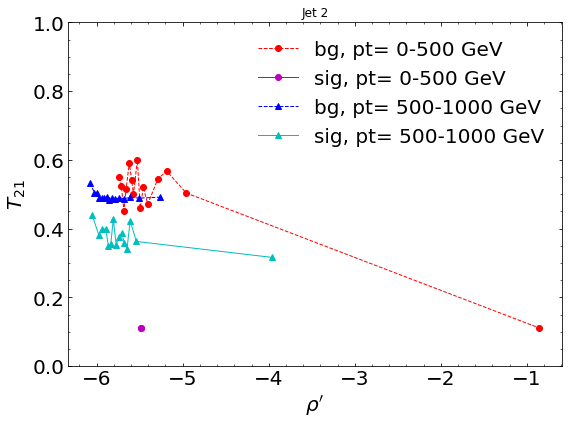

In [57]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ2_ro_500, avg_bgJ2_T21_500, 'o--', linewidth=1, color='r', label="bg, pt= 0-500 GeV")
plt.plot(avg_sigJ2_ro_500, avg_sigJ2_T21_500, 'o-', linewidth=1, color='m', label="sig, pt= 0-500 GeV")
plt.plot(avg_bgJ2_ro_1000, avg_bgJ2_T21_1000, '^--', linewidth=1, color='b', label="bg, pt= 500-1000 GeV")
plt.plot(avg_sigJ2_ro_1000, avg_sigJ2_T21_1000, '^-', linewidth=1, color='c', label="sig, pt= 500-1000 GeV")


plt.title("Jet 2")
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

(0.0, 1.0)

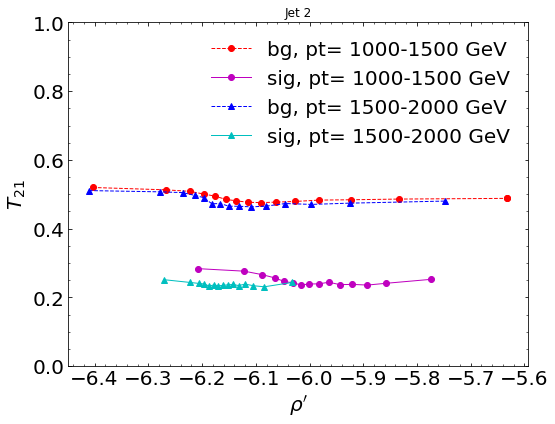

In [58]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ2_ro_1500, avg_bgJ2_T21_1500, 'o--', linewidth=1, color='r', label="bg, pt= 1000-1500 GeV")
plt.plot(avg_sigJ2_ro_1500, avg_sigJ2_T21_1500, 'o-', linewidth=1, color='m', label="sig, pt= 1000-1500 GeV")
plt.plot(avg_bgJ2_ro_2000, avg_bgJ2_T21_2000, '^--', linewidth=1, color='b', label="bg, pt= 1500-2000 GeV")
plt.plot(avg_sigJ2_ro_2000, avg_sigJ2_T21_2000, '^-', linewidth=1, color='c', label="sig, pt= 1500-2000 GeV")


plt.title("Jet 2")
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

(0.0, 1.0)

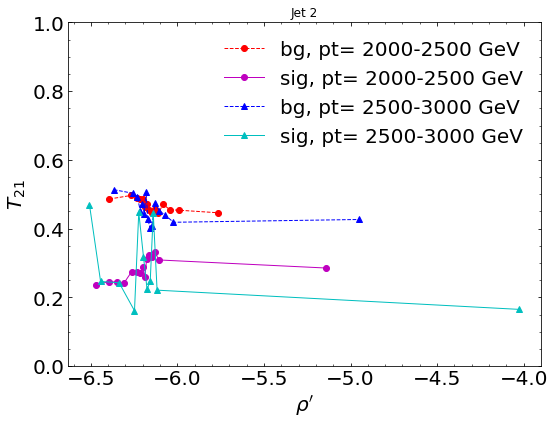

In [59]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ2_ro_2500, avg_bgJ2_T21_2500, 'o--', linewidth=1, color='r', label="bg, pt= 2000-2500 GeV")
plt.plot(avg_sigJ2_ro_2500, avg_sigJ2_T21_2500, 'o-', linewidth=1, color='m', label="sig, pt= 2000-2500 GeV")
plt.plot(avg_bgJ2_ro_3000, avg_bgJ2_T21_3000, '^--', linewidth=1, color='b', label="bg, pt= 2500-3000 GeV")
plt.plot(avg_sigJ2_ro_3000, avg_sigJ2_T21_3000, '^-', linewidth=1, color='c', label="sig, pt= 2500-3000 GeV")


plt.title("Jet 2")
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

(0.0, 1.0)

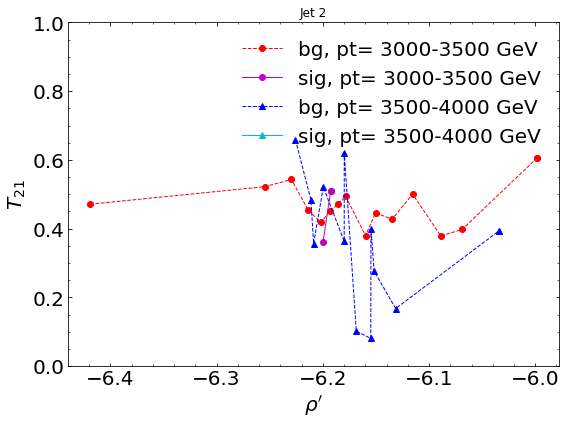

In [60]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ2_ro_3500, avg_bgJ2_T21_3500, 'o--', linewidth=1, color='r', label="bg, pt= 3000-3500 GeV")
plt.plot(avg_sigJ2_ro_3500, avg_sigJ2_T21_3500, 'o-', linewidth=1, color='m', label="sig, pt= 3000-3500 GeV")
plt.plot(avg_bgJ2_ro_4000, avg_bgJ2_T21_4000, '^--', linewidth=1, color='b', label="bg, pt= 3500-4000 GeV")
plt.plot(avg_sigJ2_ro_4000, avg_sigJ2_T21_4000, '^-', linewidth=1, color='c', label="sig, pt= 3500-4000 GeV")


plt.title("Jet 2")
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

In [61]:
from sklearn.linear_model import LinearRegression

reglin_J1_bg_500 = LinearRegression()
ro_J1_bg_500 = np.array(avg_bgJ1_ro_500)
t21_J1_bg_500 = np.array(avg_bgJ1_T21_500)

reglin_J1_bg_500.fit(ro_J1_bg_500.reshape(-1, 1), t21_J1_bg_500)

b_J1_bg_500 = reglin_J1_bg_500.coef_[0]

T21prim_J1_bg_500 = []

for n in range(len(ro_J1_bg_500)):
    T21prim_J1_bg_500.append(t21_J1_bg_500[n]-ro_J1_bg_500[n]*b_J1_bg_500)
    

    
reglin_J1_bg_1000 = LinearRegression()
ro_J1_bg_1000 = np.array(avg_bgJ1_ro_1000)
t21_J1_bg_1000 = np.array(avg_bgJ1_T21_1000)

reglin_J1_bg_1000.fit(ro_J1_bg_1000.reshape(-1, 1), t21_J1_bg_1000)

b_J1_bg_1000 = reglin_J1_bg_1000.coef_[0]

T21prim_J1_bg_1000 = []

for n in range(len(ro_J1_bg_1000)):
    T21prim_J1_bg_1000.append(t21_J1_bg_1000[n]-ro_J1_bg_1000[n]*b_J1_bg_1000)
    

    
reglin_J1_bg_1500 = LinearRegression()
ro_J1_bg_1500 = np.array(avg_bgJ1_ro_1500)
t21_J1_bg_1500 = np.array(avg_bgJ1_T21_1500)

reglin_J1_bg_1500.fit(ro_J1_bg_1500.reshape(-1, 1), t21_J1_bg_1500)

b_J1_bg_1500 = reglin_J1_bg_1500.coef_[0]

T21prim_J1_bg_1500 = []

for n in range(len(ro_J1_bg_1500)):
    T21prim_J1_bg_1500.append(t21_J1_bg_1500[n]-ro_J1_bg_1500[n]*b_J1_bg_1500)
    

    
reglin_J1_bg_2000 = LinearRegression()
ro_J1_bg_2000 = np.array(avg_bgJ1_ro_2000)
t21_J1_bg_2000 = np.array(avg_bgJ1_T21_2000)

reglin_J1_bg_2000.fit(ro_J1_bg_2000.reshape(-1, 1), t21_J1_bg_2000)

b_J1_bg_2000 = reglin_J1_bg_2000.coef_[0]

T21prim_J1_bg_2000 = []

for n in range(len(ro_J1_bg_2000)):
    T21prim_J1_bg_2000.append(t21_J1_bg_2000[n]-ro_J1_bg_2000[n]*b_J1_bg_2000)
    

    
reglin_J1_bg_2500 = LinearRegression()
ro_J1_bg_2500 = np.array(avg_bgJ1_ro_2500)
t21_J1_bg_2500 = np.array(avg_bgJ1_T21_2500)

reglin_J1_bg_2500.fit(ro_J1_bg_2500.reshape(-1, 1), t21_J1_bg_2500)

b_J1_bg_2500 = reglin_J1_bg_2500.coef_[0]

T21prim_J1_bg_2500 = []

for n in range(len(ro_J1_bg_2500)):
    T21prim_J1_bg_2500.append(t21_J1_bg_2500[n]-ro_J1_bg_2500[n]*b_J1_bg_2500)
    

    
reglin_J1_bg_3000 = LinearRegression()
ro_J1_bg_3000 = np.array(avg_bgJ1_ro_3000)
t21_J1_bg_3000 = np.array(avg_bgJ1_T21_3000)

reglin_J1_bg_3000.fit(ro_J1_bg_3000.reshape(-1, 1), t21_J1_bg_3000)

b_J1_bg_3000 = reglin_J1_bg_3000.coef_[0]

T21prim_J1_bg_3000 = []

for n in range(len(ro_J1_bg_3000)):
    T21prim_J1_bg_3000.append(t21_J1_bg_3000[n]-ro_J1_bg_3000[n]*b_J1_bg_3000)
    

    
reglin_J1_bg_3500 = LinearRegression()
ro_J1_bg_3500 = np.array(avg_bgJ1_ro_3500)
t21_J1_bg_3500 = np.array(avg_bgJ1_T21_3500)

reglin_J1_bg_3500.fit(ro_J1_bg_3500.reshape(-1, 1), t21_J1_bg_3500)

b_J1_bg_3500 = reglin_J1_bg_3500.coef_[0]

T21prim_J1_bg_3500 = []

for n in range(len(ro_J1_bg_3500)):
    T21prim_J1_bg_3500.append(t21_J1_bg_3500[n]-ro_J1_bg_3500[n]*b_J1_bg_3500)
    

    
reglin_J1_bg_4000 = LinearRegression()
ro_J1_bg_4000 = np.array(avg_bgJ1_ro_4000)
t21_J1_bg_4000 = np.array(avg_bgJ1_T21_4000)

reglin_J1_bg_4000.fit(ro_J1_bg_4000.reshape(-1, 1), t21_J1_bg_4000)

b_J1_bg_4000 = reglin_J1_bg_4000.coef_[0]

T21prim_J1_bg_4000 = []

for n in range(len(ro_J1_bg_4000)):
    T21prim_J1_bg_4000.append(t21_J1_bg_4000[n]-ro_J1_bg_4000[n]*b_J1_bg_4000)

In [62]:


reglin_J1_sig_500 = LinearRegression()
ro_J1_sig_500 = np.array(avg_sigJ1_ro_500)
t21_J1_sig_500 = np.array(avg_sigJ1_T21_500)

reglin_J1_sig_500.fit(ro_J1_sig_500.reshape(-1, 1), t21_J1_sig_500)

b_J1_sig_500 = reglin_J1_sig_500.coef_[0]

T21prim_J1_sig_500 = []

for n in range(len(ro_J1_sig_500)):
    T21prim_J1_sig_500.append(t21_J1_sig_500[n]-ro_J1_sig_500[n]*b_J1_sig_500)
    

    
reglin_J1_sig_1000 = LinearRegression()
ro_J1_sig_1000 = np.array(avg_sigJ1_ro_1000)
t21_J1_sig_1000 = np.array(avg_sigJ1_T21_1000)

reglin_J1_sig_1000.fit(ro_J1_sig_1000.reshape(-1, 1), t21_J1_sig_1000)

b_J1_sig_1000 = reglin_J1_sig_1000.coef_[0]

T21prim_J1_sig_1000 = []

for n in range(len(ro_J1_sig_1000)):
    T21prim_J1_sig_1000.append(t21_J1_sig_1000[n]-ro_J1_sig_1000[n]*b_J1_sig_1000)
    

    
reglin_J1_sig_1500 = LinearRegression()
ro_J1_sig_1500 = np.array(avg_sigJ1_ro_1500)
t21_J1_sig_1500 = np.array(avg_sigJ1_T21_1500)

reglin_J1_sig_1500.fit(ro_J1_sig_1500.reshape(-1, 1), t21_J1_sig_1500)

b_J1_sig_1500 = reglin_J1_sig_1500.coef_[0]

T21prim_J1_sig_1500 = []

for n in range(len(ro_J1_sig_1500)):
    T21prim_J1_sig_1500.append(t21_J1_sig_1500[n]-ro_J1_sig_1500[n]*b_J1_sig_1500)
    

    
reglin_J1_sig_2000 = LinearRegression()
ro_J1_sig_2000 = np.array(avg_sigJ1_ro_2000)
t21_J1_sig_2000 = np.array(avg_sigJ1_T21_2000)

reglin_J1_sig_2000.fit(ro_J1_sig_2000.reshape(-1, 1), t21_J1_sig_2000)

b_J1_sig_2000 = reglin_J1_sig_2000.coef_[0]

T21prim_J1_sig_2000 = []

for n in range(len(ro_J1_sig_2000)):
    T21prim_J1_sig_2000.append(t21_J1_sig_2000[n]-ro_J1_sig_2000[n]*b_J1_sig_2000)
    

    
reglin_J1_sig_2500 = LinearRegression()
ro_J1_sig_2500 = np.array(avg_sigJ1_ro_2500)
t21_J1_sig_2500 = np.array(avg_sigJ1_T21_2500)

reglin_J1_sig_2500.fit(ro_J1_sig_2500.reshape(-1, 1), t21_J1_sig_2500)

b_J1_sig_2500 = reglin_J1_sig_2500.coef_[0]

T21prim_J1_sig_2500 = []

for n in range(len(ro_J1_sig_2500)):
    T21prim_J1_sig_2500.append(t21_J1_sig_2500[n]-ro_J1_sig_2500[n]*b_J1_sig_2500)
    

    
reglin_J1_sig_3000 = LinearRegression()
ro_J1_sig_3000 = np.array(avg_sigJ1_ro_3000)
t21_J1_sig_3000 = np.array(avg_sigJ1_T21_3000)

reglin_J1_sig_3000.fit(ro_J1_sig_3000.reshape(-1, 1), t21_J1_sig_3000)

b_J1_sig_3000 = reglin_J1_sig_3000.coef_[0]

T21prim_J1_sig_3000 = []

for n in range(len(ro_J1_sig_3000)):
    T21prim_J1_sig_3000.append(t21_J1_sig_3000[n]-ro_J1_sig_3000[n]*b_J1_sig_3000)
    

    
reglin_J1_sig_3500 = LinearRegression()
ro_J1_sig_3500 = np.array(avg_sigJ1_ro_3500)
t21_J1_sig_3500 = np.array(avg_sigJ1_T21_3500)

reglin_J1_sig_3500.fit(ro_J1_sig_3500.reshape(-1, 1), t21_J1_sig_3500)

b_J1_sig_3500 = reglin_J1_sig_3500.coef_[0]

T21prim_J1_sig_3500 = []

for n in range(len(ro_J1_sig_3500)):
    T21prim_J1_sig_3500.append(t21_J1_sig_3500[n]-ro_J1_sig_3500[n]*b_J1_sig_3500)
    

"""    
reglin_J1_sig_4000 = LinearRegression()
ro_J1_sig_4000 = np.array(avg_sigJ1_ro_4000)
t21_J1_sig_4000 = np.array(avg_sigJ1_T21_4000)

reglin_J1_sig_4000.fit(ro_J1_sig_4000.reshape(-1, 1), t21_J1_sig_4000)

b_J1_sig_4000 = reglin_J1_sig_4000.coef_[0]

T21prim_J1_sig_4000 = []

for n in range(len(ro_J1_sig_4000)):
    T21prim_J1_sig_4000.append(t21_J1_sig_4000[n]-ro_J1_sig_4000[n]*b_J1_sig_4000)
"""

'    \nreglin_J1_sig_4000 = LinearRegression()\nro_J1_sig_4000 = np.array(avg_sigJ1_ro_4000)\nt21_J1_sig_4000 = np.array(avg_sigJ1_T21_4000)\n\nreglin_J1_sig_4000.fit(ro_J1_sig_4000.reshape(-1, 1), t21_J1_sig_4000)\n\nb_J1_sig_4000 = reglin_J1_sig_4000.coef_[0]\n\nT21prim_J1_sig_4000 = []\n\nfor n in range(len(ro_J1_sig_4000)):\n    T21prim_J1_sig_4000.append(t21_J1_sig_4000[n]-ro_J1_sig_4000[n]*b_J1_sig_4000)\n'

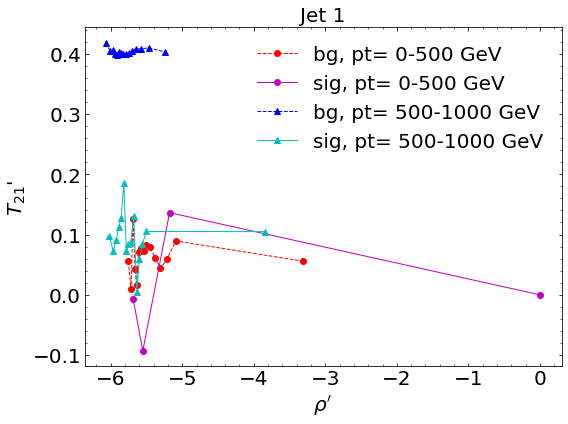

In [63]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ1_ro_500, T21prim_J1_bg_500, 'o--', linewidth=1, color='r', label="bg, pt= 0-500 GeV")
plt.plot(avg_sigJ1_ro_500, T21prim_J1_sig_500, 'o-', linewidth=1, color='m', label="sig, pt= 0-500 GeV")
plt.plot(avg_bgJ1_ro_1000, T21prim_J1_bg_1000, '^--', linewidth=1, color='b', label="bg, pt= 500-1000 GeV")
plt.plot(avg_sigJ1_ro_1000, T21prim_J1_sig_1000, '^-', linewidth=1, color='c', label="sig, pt= 500-1000 GeV")

plt.title("Jet 1",fontsize=20)
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$'",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

(0.0, 1.0)

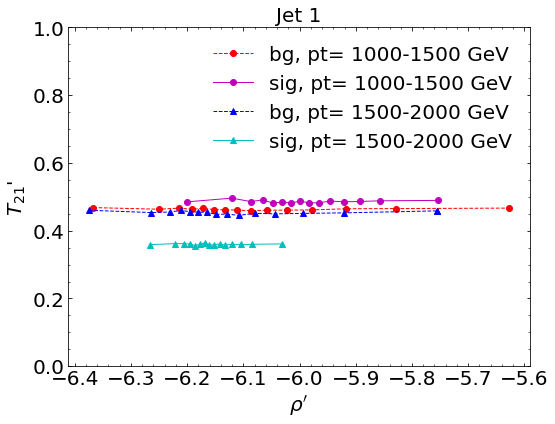

In [64]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ1_ro_1500, T21prim_J1_bg_1500, 'o--', linewidth=1, color='r', label="bg, pt= 1000-1500 GeV")
plt.plot(avg_sigJ1_ro_1500, T21prim_J1_sig_1500, 'o-', linewidth=1, color='m', label="sig, pt= 1000-1500 GeV")
plt.plot(avg_bgJ1_ro_2000, T21prim_J1_bg_2000, '^--', linewidth=1, color='b', label="bg, pt= 1500-2000 GeV")
plt.plot(avg_sigJ1_ro_2000, T21prim_J1_sig_2000, '^-', linewidth=1, color='c', label="sig, pt= 1500-2000 GeV")

plt.title("Jet 1",fontsize=20)
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$'",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

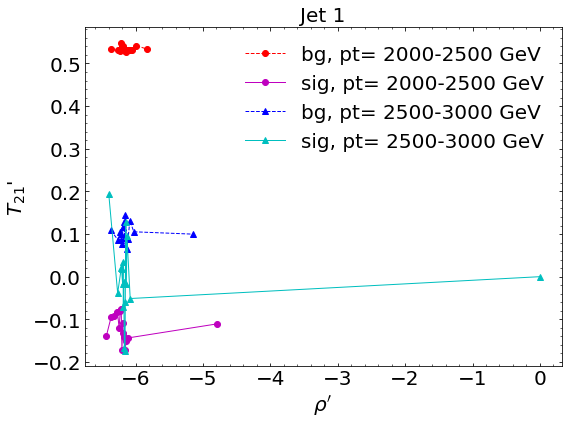

In [65]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ1_ro_2500, T21prim_J1_bg_2500, 'o--', linewidth=1, color='r', label="bg, pt= 2000-2500 GeV")
plt.plot(avg_sigJ1_ro_2500, T21prim_J1_sig_2500, 'o-', linewidth=1, color='m', label="sig, pt= 2000-2500 GeV")
plt.plot(avg_bgJ1_ro_3000, T21prim_J1_bg_3000, '^--', linewidth=1, color='b', label="bg, pt= 2500-3000 GeV")
plt.plot(avg_sigJ1_ro_3000, T21prim_J1_sig_3000, '^-', linewidth=1, color='c', label="sig, pt= 2500-3000 GeV")

plt.title("Jet 1",fontsize=20)
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$'",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

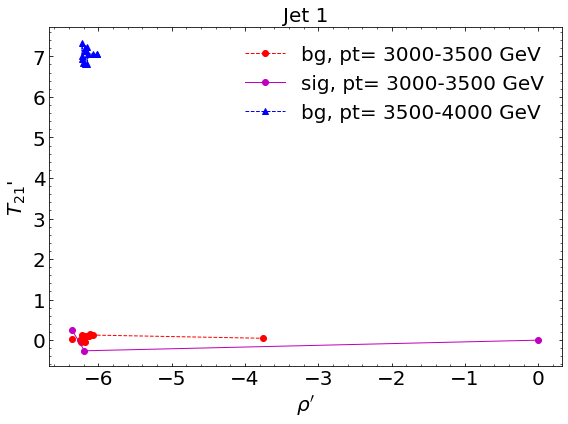

In [66]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ1_ro_3500, T21prim_J1_bg_3500, 'o--', linewidth=1, color='r', label="bg, pt= 3000-3500 GeV")
plt.plot(avg_sigJ1_ro_3500, T21prim_J1_sig_3500, 'o-', linewidth=1, color='m', label="sig, pt= 3000-3500 GeV")
plt.plot(avg_bgJ1_ro_4000, T21prim_J1_bg_4000, '^--', linewidth=1, color='b', label="bg, pt= 3500-4000 GeV")
#plt.plot(avg_sigJ1_ro_2000, T21prim_J1_sig_2000, '^-', linewidth=1, color='c', label="sig, pt= 1500-2000 GeV")

plt.title("Jet 1",fontsize=20)
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$'",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

In [67]:
reglin_J2_bg_500 = LinearRegression()
ro_J2_bg_500 = np.array(avg_bgJ2_ro_500)
t21_J2_bg_500 = np.array(avg_bgJ2_T21_500)

reglin_J2_bg_500.fit(ro_J2_bg_500.reshape(-1, 1), t21_J2_bg_500)

b_J2_bg_500 = reglin_J2_bg_500.coef_[0]

T21prim_J2_bg_500 = []

for n in range(len(ro_J2_bg_500)):
    T21prim_J2_bg_500.append(t21_J2_bg_500[n]-ro_J2_bg_500[n]*b_J2_bg_500)
    

    
reglin_J2_bg_1000 = LinearRegression()
ro_J2_bg_1000 = np.array(avg_bgJ2_ro_1000)
t21_J2_bg_1000 = np.array(avg_bgJ2_T21_1000)

reglin_J2_bg_1000.fit(ro_J2_bg_1000.reshape(-1, 1), t21_J2_bg_1000)

b_J2_bg_1000 = reglin_J2_bg_1000.coef_[0]

T21prim_J2_bg_1000 = []

for n in range(len(ro_J2_bg_1000)):
    T21prim_J2_bg_1000.append(t21_J2_bg_1000[n]-ro_J2_bg_1000[n]*b_J2_bg_1000)
    

    
reglin_J2_bg_1500 = LinearRegression()
ro_J2_bg_1500 = np.array(avg_bgJ2_ro_1500)
t21_J2_bg_1500 = np.array(avg_bgJ2_T21_1500)

reglin_J2_bg_1500.fit(ro_J2_bg_1500.reshape(-1, 1), t21_J2_bg_1500)

b_J2_bg_1500 = reglin_J2_bg_1500.coef_[0]

T21prim_J2_bg_1500 = []

for n in range(len(ro_J2_bg_1500)):
    T21prim_J2_bg_1500.append(t21_J2_bg_1500[n]-ro_J2_bg_1500[n]*b_J2_bg_1500)
    

    
reglin_J2_bg_2000 = LinearRegression()
ro_J2_bg_2000 = np.array(avg_bgJ2_ro_2000)
t21_J2_bg_2000 = np.array(avg_bgJ2_T21_2000)

reglin_J2_bg_2000.fit(ro_J2_bg_2000.reshape(-1, 1), t21_J2_bg_2000)

b_J2_bg_2000 = reglin_J2_bg_2000.coef_[0]

T21prim_J2_bg_2000 = []

for n in range(len(ro_J2_bg_2000)):
    T21prim_J2_bg_2000.append(t21_J2_bg_2000[n]-ro_J2_bg_2000[n]*b_J2_bg_2000)
    

    
reglin_J2_bg_2500 = LinearRegression()
ro_J2_bg_2500 = np.array(avg_bgJ2_ro_2500)
t21_J2_bg_2500 = np.array(avg_bgJ2_T21_2500)

reglin_J2_bg_2500.fit(ro_J2_bg_2500.reshape(-1, 1), t21_J2_bg_2500)

b_J2_bg_2500 = reglin_J2_bg_2500.coef_[0]

T21prim_J2_bg_2500 = []

for n in range(len(ro_J2_bg_2500)):
    T21prim_J2_bg_2500.append(t21_J2_bg_2500[n]-ro_J2_bg_2500[n]*b_J2_bg_2500)
    

    
reglin_J2_bg_3000 = LinearRegression()
ro_J2_bg_3000 = np.array(avg_bgJ2_ro_3000)
t21_J2_bg_3000 = np.array(avg_bgJ2_T21_3000)

reglin_J2_bg_3000.fit(ro_J2_bg_3000.reshape(-1, 1), t21_J2_bg_3000)

b_J2_bg_3000 = reglin_J2_bg_3000.coef_[0]

T21prim_J2_bg_3000 = []

for n in range(len(ro_J2_bg_3000)):
    T21prim_J2_bg_3000.append(t21_J2_bg_3000[n]-ro_J2_bg_3000[n]*b_J2_bg_3000)
    

    
reglin_J2_bg_3500 = LinearRegression()
ro_J2_bg_3500 = np.array(avg_bgJ2_ro_3500)
t21_J2_bg_3500 = np.array(avg_bgJ2_T21_3500)

reglin_J2_bg_3500.fit(ro_J2_bg_3500.reshape(-1, 1), t21_J2_bg_3500)

b_J2_bg_3500 = reglin_J2_bg_3500.coef_[0]

T21prim_J2_bg_3500 = []

for n in range(len(ro_J2_bg_3500)):
    T21prim_J2_bg_3500.append(t21_J2_bg_3500[n]-ro_J2_bg_3500[n]*b_J2_bg_3500)
    

    
reglin_J2_bg_4000 = LinearRegression()
ro_J2_bg_4000 = np.array(avg_bgJ2_ro_4000)
t21_J2_bg_4000 = np.array(avg_bgJ2_T21_4000)

reglin_J2_bg_4000.fit(ro_J2_bg_4000.reshape(-1, 1), t21_J2_bg_4000)

b_J2_bg_4000 = reglin_J2_bg_4000.coef_[0]

T21prim_J2_bg_4000 = []

for n in range(len(ro_J2_bg_4000)):
    T21prim_J2_bg_4000.append(t21_J2_bg_4000[n]-ro_J2_bg_4000[n]*b_J2_bg_4000)

In [68]:


reglin_J2_sig_500 = LinearRegression()
ro_J2_sig_500 = np.array(avg_sigJ2_ro_500)
t21_J2_sig_500 = np.array(avg_sigJ2_T21_500)

reglin_J2_sig_500.fit(ro_J2_sig_500.reshape(-1, 1), t21_J2_sig_500)

b_J2_sig_500 = reglin_J2_sig_500.coef_[0]

T21prim_J2_sig_500 = []

for n in range(len(ro_J2_sig_500)):
    T21prim_J2_sig_500.append(t21_J2_sig_500[n]-ro_J2_sig_500[n]*b_J2_sig_500)
    

    
reglin_J2_sig_1000 = LinearRegression()
ro_J2_sig_1000 = np.array(avg_sigJ2_ro_1000)
t21_J2_sig_1000 = np.array(avg_sigJ2_T21_1000)

reglin_J2_sig_1000.fit(ro_J2_sig_1000.reshape(-1, 1), t21_J2_sig_1000)

b_J2_sig_1000 = reglin_J2_sig_1000.coef_[0]

T21prim_J2_sig_1000 = []

for n in range(len(ro_J2_sig_1000)):
    T21prim_J2_sig_1000.append(t21_J2_sig_1000[n]-ro_J2_sig_1000[n]*b_J2_sig_1000)
    

    
reglin_J2_sig_1500 = LinearRegression()
ro_J2_sig_1500 = np.array(avg_sigJ2_ro_1500)
t21_J2_sig_1500 = np.array(avg_sigJ2_T21_1500)

reglin_J2_sig_1500.fit(ro_J2_sig_1500.reshape(-1, 1), t21_J2_sig_1500)

b_J2_sig_1500 = reglin_J2_sig_1500.coef_[0]

T21prim_J2_sig_1500 = []

for n in range(len(ro_J2_sig_1500)):
    T21prim_J2_sig_1500.append(t21_J2_sig_1500[n]-ro_J2_sig_1500[n]*b_J2_sig_1500)
    

    
reglin_J2_sig_2000 = LinearRegression()
ro_J2_sig_2000 = np.array(avg_sigJ2_ro_2000)
t21_J2_sig_2000 = np.array(avg_sigJ2_T21_2000)

reglin_J2_sig_2000.fit(ro_J2_sig_2000.reshape(-1, 1), t21_J2_sig_2000)

b_J2_sig_2000 = reglin_J2_sig_2000.coef_[0]

T21prim_J2_sig_2000 = []

for n in range(len(ro_J2_sig_2000)):
    T21prim_J2_sig_2000.append(t21_J2_sig_2000[n]-ro_J2_sig_2000[n]*b_J2_sig_2000)
    

    
reglin_J2_sig_2500 = LinearRegression()
ro_J2_sig_2500 = np.array(avg_sigJ2_ro_2500)
t21_J2_sig_2500 = np.array(avg_sigJ2_T21_2500)

reglin_J2_sig_2500.fit(ro_J2_sig_2500.reshape(-1, 1), t21_J2_sig_2500)

b_J2_sig_2500 = reglin_J2_sig_2500.coef_[0]

T21prim_J2_sig_2500 = []

for n in range(len(ro_J2_sig_2500)):
    T21prim_J2_sig_2500.append(t21_J2_sig_2500[n]-ro_J2_sig_2500[n]*b_J2_sig_2500)
    

    
reglin_J2_sig_3000 = LinearRegression()
ro_J2_sig_3000 = np.array(avg_sigJ2_ro_3000)
t21_J2_sig_3000 = np.array(avg_sigJ2_T21_3000)

reglin_J2_sig_3000.fit(ro_J2_sig_3000.reshape(-1, 1), t21_J2_sig_3000)

b_J2_sig_3000 = reglin_J2_sig_3000.coef_[0]

T21prim_J2_sig_3000 = []

for n in range(len(ro_J2_sig_3000)):
    T21prim_J2_sig_3000.append(t21_J2_sig_3000[n]-ro_J2_sig_3000[n]*b_J2_sig_3000)
    

    
reglin_J2_sig_3500 = LinearRegression()
ro_J2_sig_3500 = np.array(avg_sigJ2_ro_3500)
t21_J2_sig_3500 = np.array(avg_sigJ2_T21_3500)

reglin_J2_sig_3500.fit(ro_J2_sig_3500.reshape(-1, 1), t21_J2_sig_3500)

b_J2_sig_3500 = reglin_J2_sig_3500.coef_[0]

T21prim_J2_sig_3500 = []

for n in range(len(ro_J2_sig_3500)):
    T21prim_J2_sig_3500.append(t21_J2_sig_3500[n]-ro_J2_sig_3500[n]*b_J2_sig_3500)

    
"""   
reglin_J2_sig_4000 = LinearRegression()
ro_J2_sig_4000 = np.array(avg_sigJ2_ro_4000)
t21_J2_sig_4000 = np.array(avg_sigJ2_T21_4000)

reglin_J2_sig_4000.fit(ro_J2_sig_4000.reshape(-1, 1), t21_J2_sig_4000)

b_J2_sig_4000 = reglin_J2_sig_4000.coef_[0]

T21prim_J2_sig_4000 = []

for n in range(len(ro_J2_sig_4000)):
    T21prim_J2_sig_4000.append(t21_J2_sig_4000[n]-ro_J2_sig_4000[n]*b_J2_sig_4000)
"""

'   \nreglin_J2_sig_4000 = LinearRegression()\nro_J2_sig_4000 = np.array(avg_sigJ2_ro_4000)\nt21_J2_sig_4000 = np.array(avg_sigJ2_T21_4000)\n\nreglin_J2_sig_4000.fit(ro_J2_sig_4000.reshape(-1, 1), t21_J2_sig_4000)\n\nb_J2_sig_4000 = reglin_J2_sig_4000.coef_[0]\n\nT21prim_J2_sig_4000 = []\n\nfor n in range(len(ro_J2_sig_4000)):\n    T21prim_J2_sig_4000.append(t21_J2_sig_4000[n]-ro_J2_sig_4000[n]*b_J2_sig_4000)\n'

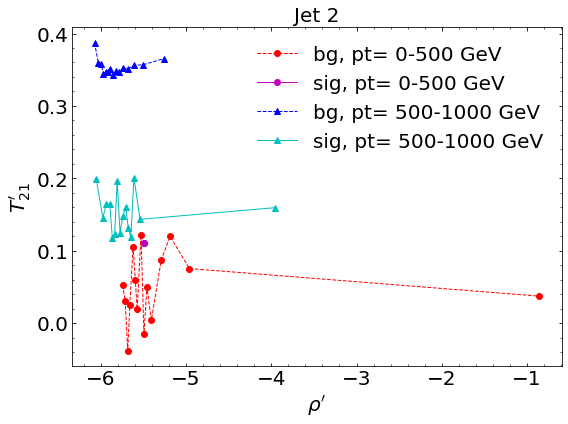

In [69]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ2_ro_500, T21prim_J2_bg_500, 'o--', linewidth=1, color='r', label="bg, pt= 0-500 GeV")
plt.plot(avg_sigJ2_ro_500, T21prim_J2_sig_500, 'o-', linewidth=1, color='m', label="sig, pt= 0-500 GeV")
plt.plot(avg_bgJ2_ro_1000, T21prim_J2_bg_1000, '^--', linewidth=1, color='b', label="bg, pt= 500-1000 GeV")
plt.plot(avg_sigJ2_ro_1000, T21prim_J2_sig_1000, '^-', linewidth=1, color='c', label="sig, pt= 500-1000 GeV")

plt.title("Jet 2",fontsize=20)
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}'$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

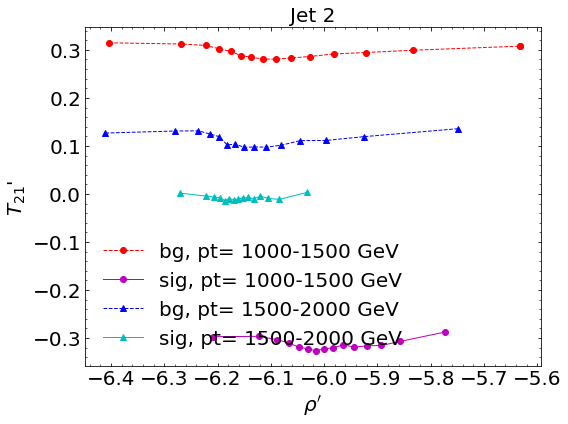

In [70]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ2_ro_1500, T21prim_J2_bg_1500, 'o--', linewidth=1, color='r', label="bg, pt= 1000-1500 GeV")
plt.plot(avg_sigJ2_ro_1500, T21prim_J2_sig_1500, 'o-', linewidth=1, color='m', label="sig, pt= 1000-1500 GeV")
plt.plot(avg_bgJ2_ro_2000, T21prim_J2_bg_2000, '^--', linewidth=1, color='b', label="bg, pt= 1500-2000 GeV")
plt.plot(avg_sigJ2_ro_2000, T21prim_J2_sig_2000, '^-', linewidth=1, color='c', label="sig, pt= 1500-2000 GeV")

plt.title("Jet 2",fontsize=20)
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$'",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

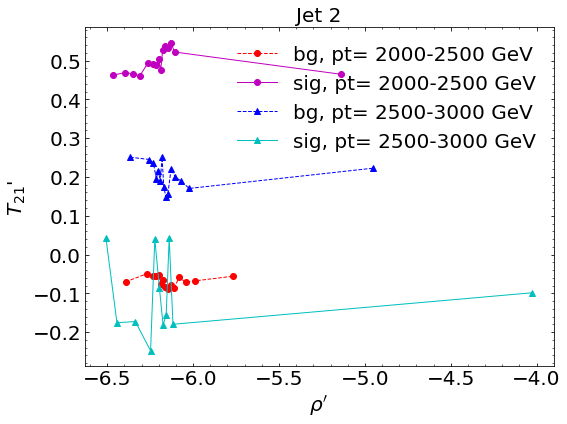

In [71]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ2_ro_2500, T21prim_J2_bg_2500, 'o--', linewidth=1, color='r', label="bg, pt= 2000-2500 GeV")
plt.plot(avg_sigJ2_ro_2500, T21prim_J2_sig_2500, 'o-', linewidth=1, color='m', label="sig, pt= 2000-2500 GeV")
plt.plot(avg_bgJ2_ro_3000, T21prim_J2_bg_3000, '^--', linewidth=1, color='b', label="bg, pt= 2500-3000 GeV")
plt.plot(avg_sigJ2_ro_3000, T21prim_J2_sig_3000, '^-', linewidth=1, color='c', label="sig, pt= 2500-3000 GeV")

plt.title("Jet 2",fontsize=20)
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$'",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

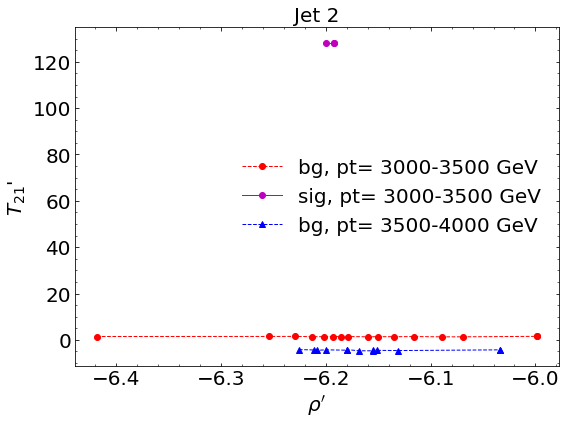

In [72]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(avg_bgJ2_ro_3500, T21prim_J2_bg_3500, 'o--', linewidth=1, color='r', label="bg, pt= 3000-3500 GeV")
plt.plot(avg_sigJ2_ro_3500, T21prim_J2_sig_3500, 'o-', linewidth=1, color='m', label="sig, pt= 3000-3500 GeV")
plt.plot(avg_bgJ2_ro_4000, T21prim_J2_bg_4000, '^--', linewidth=1, color='b', label="bg, pt= 3500-4000 GeV")
#plt.plot(avg_sigJ2_ro_2000, T21prim_J2_sig_2000, '^-', linewidth=1, color='c', label="sig, pt= 1500-2000 GeV")

plt.title("Jet 2",fontsize=20)
plt.xlabel(r"$\rho'$",fontsize=20)
plt.ylabel(r"$T_{21}$'",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
#plt.ylim([0,1])

In [73]:
grapf_jet1_bg2 = load_data_J1(features_bg2)
print(grapf_jet1_bg2.shape)

j1_bg2_ro_pt500 = []
j1_bg2_t21_pt500 = []

j1_bg2_ro_pt1000 = []
j1_bg2_t21_pt1000 = []

j1_bg2_ro_pt1500 = []
j1_bg2_t21_pt1500 = []

j1_bg2_ro_pt2000 = []
j1_bg2_t21_pt2000 = []

j1_bg2_ro_pt2500 = []
j1_bg2_t21_pt2500 = []

j1_bg2_ro_pt3000 = []
j1_bg2_t21_pt3000 = []

j1_bg2_ro_pt3500 = []
j1_bg2_t21_pt3500 = []

j1_bg2_ro_pt4000 = []
j1_bg2_t21_pt4000 = []

#1000000
for t in range(999999):
    if grapf_jet1_bg2[t][2] <= 500:
        j1_bg2_ro_pt500.append(grapf_jet1_bg2[t][1])
        j1_bg2_t21_pt500.append(grapf_jet1_bg2[t][0])
        
    elif (grapf_jet1_bg2[t][2] > 500) and (grapf_jet1_bg2[t][2] <= 1000):
        j1_bg2_ro_pt1000.append(grapf_jet1_bg2[t][1])
        j1_bg2_t21_pt1000.append(grapf_jet1_bg2[t][0])
        
    elif (grapf_jet1_bg2[t][2] > 1000) and (grapf_jet1_bg2[t][2] <= 1500):
        j1_bg2_ro_pt1500.append(grapf_jet1_bg2[t][1])
        j1_bg2_t21_pt1500.append(grapf_jet1_bg2[t][0])
        
    elif (grapf_jet1_bg2[t][2] > 1500) and (grapf_jet1_bg2[t][2] <= 2000):
        j1_bg2_ro_pt2000.append(grapf_jet1_bg[t][1])
        j1_bg2_t21_pt2000.append(grapf_jet1_bg[t][0])
        
    elif (grapf_jet1_bg2[t][2] > 2000) and (grapf_jet1_bg2[t][2] <= 2500):
        j1_bg2_ro_pt2500.append(grapf_jet1_bg2[t][1])
        j1_bg2_t21_pt2500.append(grapf_jet1_bg2[t][0])
    
    elif (grapf_jet1_bg2[t][2] > 2500) and (grapf_jet1_bg2[t][2] <= 3000):
        j1_bg2_ro_pt3000.append(grapf_jet1_bg2[t][1])
        j1_bg2_t21_pt3000.append(grapf_jet1_bg2[t][0])
        
    elif (grapf_jet1_bg2[t][2] > 3000) and (grapf_jet1_bg2[t][2] <= 3500):
        j1_bg2_ro_pt3500.append(grapf_jet1_bg2[t][1])
        j1_bg2_t21_pt3500.append(grapf_jet1_bg2[t][0])
        
    else:
        j1_bg2_ro_pt4000.append(grapf_jet1_bg2[t][1])
        j1_bg2_t21_pt4000.append(grapf_jet1_bg2[t][0])


data_j1_bg2_T21_ro_500 = pd.DataFrame({'ro': j1_bg2_ro_pt500, 
                                       'T21': j1_bg2_t21_pt500})
data_j1_bg2_T21_ro_1000 = pd.DataFrame({'ro': j1_bg2_ro_pt1000, 
                                        'T21': j1_bg2_t21_pt1000})
data_j1_bg2_T21_ro_1500 = pd.DataFrame({'ro': j1_bg2_ro_pt1500, 
                                        'T21': j1_bg2_t21_pt1500})
data_j1_bg2_T21_ro_2000 = pd.DataFrame({'ro': j1_bg2_ro_pt2000, 
                                        'T21': j1_bg2_t21_pt2000})
data_j1_bg2_T21_ro_2500 = pd.DataFrame({'ro': j1_bg2_ro_pt2500, 
                                        'T21': j1_bg2_t21_pt2500})
data_j1_bg2_T21_ro_3000 = pd.DataFrame({'ro': j1_bg2_ro_pt3000, 
                                        'T21': j1_bg2_t21_pt3000})
data_j1_bg2_T21_ro_3500 = pd.DataFrame({'ro': j1_bg2_ro_pt3500, 
                                        'T21': j1_bg2_t21_pt3500})
data_j1_bg2_T21_ro_4000 = pd.DataFrame({'ro': j1_bg2_ro_pt4000, 
                                        'T21': j1_bg2_t21_pt4000})


order_bg2J1_500 = data_j1_bg2_T21_ro_500.sort_values('ro')
order_bg2J1_1000 = data_j1_bg2_T21_ro_1000.sort_values('ro')
order_bg2J1_1500 = data_j1_bg2_T21_ro_1500.sort_values('ro')
order_bg2J1_2000 = data_j1_bg2_T21_ro_2000.sort_values('ro')
order_bg2J1_2500 = data_j1_bg2_T21_ro_2500.sort_values('ro')
order_bg2J1_3000 = data_j1_bg2_T21_ro_3000.sort_values('ro')
order_bg2J1_3500 = data_j1_bg2_T21_ro_3500.sort_values('ro')
order_bg2J1_4000 = data_j1_bg2_T21_ro_4000.sort_values('ro')



bg2J1_500 = order_bg2J1_500.to_numpy()
bg2J1_1000 = order_bg2J1_1000.to_numpy()
bg2J1_1500 = order_bg2J1_1500.to_numpy()
bg2J1_2000 = order_bg2J1_2000.to_numpy()
bg2J1_2500 = order_bg2J1_2500.to_numpy()
bg2J1_3000 = order_bg2J1_3000.to_numpy()
bg2J1_3500 = order_bg2J1_3500.to_numpy()
bg2J1_4000 = order_bg2J1_4000.to_numpy()



avg_bg2J1_T21_500 = []
avg_bg2J1_ro_500 = []

N_bg2J1_500 = math.ceil(len(order_bg2J1_500['T21'])/15)

i = 0
sum_bg2J1_T21_500 = 0
sum_bg2J1_ro_500 = 0

for n in range(len(bg2J1_500)):
    sum_bg2J1_T21_500 = sum_bg2J1_T21_500 + bg2J1_500[n][1]
    sum_bg2J1_ro_500 = sum_bg2J1_ro_500 + bg2J1_500[n][0]      
    i = i+1
        
    if i >= N_bg2J1_500:
            
        avg_bg2J1_T21_500.append(sum_bg2J1_T21_500/N_bg2J1_500)
        avg_bg2J1_ro_500.append(sum_bg2J1_ro_500/N_bg2J1_500)
        sum_bg2J1_T21_500 = 0
        sum_bg2J1_ro_500 = 0
        i = 0
        
    """  """ 
    if n == len(bg2J1_500)-1:
        avg_bg2J1_T21_500.append(sum_bg2J1_T21_500/N_bg2J1_500)
        avg_bg2J1_ro_500.append(sum_bg2J1_ro_500/N_bg2J1_500)



avg_bg2J1_T21_1000 = []
avg_bg2J1_ro_1000 = []

N_bg2J1_1000 = math.ceil(len(order_bg2J1_1000['T21'])/15)

i = 0
sum_bg2J1_T21_1000 = 0
sum_bg2J1_ro_1000 = 0

for n in range(len(bg2J1_1000)):
    sum_bg2J1_T21_1000 = sum_bg2J1_T21_1000 + bg2J1_1000[n][1]
    sum_bg2J1_ro_1000 = sum_bg2J1_ro_1000 + bg2J1_1000[n][0]      
    i = i+1
    
    if n == len(bg2J1_1000)-1:
        avg_bg2J1_T21_1000.append(sum_bg2J1_T21_1000/N_bg2J1_1000)
        avg_bg2J1_ro_1000.append(sum_bg2J1_ro_1000/N_bg2J1_1000)
        
    if i >= N_bg2J1_1000:
        avg_bg2J1_T21_1000.append(sum_bg2J1_T21_1000/N_bg2J1_1000)
        avg_bg2J1_ro_1000.append(sum_bg2J1_ro_1000/N_bg2J1_1000)
        sum_bg2J1_T21_1000 = 0
        sum_bg2J1_ro_1000 = 0
        i = 0

        
avg_bg2J1_T21_1500 = []
avg_bg2J1_ro_1500 = []

N_bg2J1_1500 = math.ceil(len(order_bg2J1_1500['T21'])/15)

i = 0
sum_bg2J1_T21_1500 = 0
sum_bg2J1_ro_1500 = 0

for n in range(len(bg2J1_1500)):
    sum_bg2J1_T21_1500 = sum_bg2J1_T21_1500 + bg2J1_1500[n][1]
    sum_bg2J1_ro_1500 = sum_bg2J1_ro_1500 + bg2J1_1500[n][0]      
    i = i+1
    
    if n == len(bg2J1_1500)-1:
        avg_bg2J1_T21_1500.append(sum_bg2J1_T21_1500/N_bg2J1_1500)
        avg_bg2J1_ro_1500.append(sum_bg2J1_ro_1500/N_bg2J1_1500)
        
    if i >= N_bg2J1_1500:
        avg_bg2J1_T21_1500.append(sum_bg2J1_T21_1500/N_bg2J1_1500)
        avg_bg2J1_ro_1500.append(sum_bg2J1_ro_1500/N_bg2J1_1500)
        sum_bg2J1_T21_1500 = 0
        sum_bg2J1_ro_1500 = 0
        i = 0


avg_bg2J1_T21_2000 = []
avg_bg2J1_ro_2000 = []

N_bg2J1_2000 = math.ceil(len(order_bg2J1_2000['T21'])/15)

i = 0
sum_bg2J1_T21_2000 = 0
sum_bg2J1_ro_2000 = 0

for n in range(len(bg2J1_2000)):
    sum_bg2J1_T21_2000 = sum_bg2J1_T21_2000 + bg2J1_2000[n][1]
    sum_bg2J1_ro_2000 = sum_bg2J1_ro_2000 + bg2J1_2000[n][0]      
    i = i+1
    
    if n == len(bg2J1_2000)-1:
        avg_bg2J1_T21_2000.append(sum_bg2J1_T21_2000/N_bg2J1_2000)
        avg_bg2J1_ro_2000.append(sum_bg2J1_ro_2000/N_bg2J1_2000)
        
    if i >= N_bg2J1_2000:
        avg_bg2J1_T21_2000.append(sum_bg2J1_T21_2000/N_bg2J1_2000)
        avg_bg2J1_ro_2000.append(sum_bg2J1_ro_2000/N_bg2J1_2000)
        sum_bg2J1_T21_2000 = 0
        sum_bg2J1_ro_2000 = 0
        i = 0

        
avg_bg2J1_T21_2500 = []
avg_bg2J1_ro_2500 = []

N_bg2J1_2500 = math.ceil(len(order_bg2J1_2500['T21'])/15)

i = 0
sum_bg2J1_T21_2500 = 0
sum_bg2J1_ro_2500 = 0

for n in range(len(bg2J1_2500)):
    sum_bg2J1_T21_2500 = sum_bg2J1_T21_2500 + bg2J1_2500[n][1]
    sum_bg2J1_ro_2500 = sum_bg2J1_ro_2500 + bg2J1_2500[n][0]      
    i = i+1
    
    if n == len(bg2J1_2500)-1:
        avg_bg2J1_T21_2500.append(sum_bg2J1_T21_2500/N_bg2J1_2500)
        avg_bg2J1_ro_2500.append(sum_bg2J1_ro_2500/N_bg2J1_2500)
        
    if i >= N_bg2J1_2500:
        avg_bg2J1_T21_2500.append(sum_bg2J1_T21_2500/N_bg2J1_2500)
        avg_bg2J1_ro_2500.append(sum_bg2J1_ro_2500/N_bg2J1_2500)
        sum_bg2J1_T21_2500 = 0
        sum_bg2J1_ro_2500 = 0
        i = 0


avg_bg2J1_T21_3000 = []
avg_bg2J1_ro_3000 = []

N_bg2J1_3000 = math.ceil(len(order_bg2J1_3000['T21'])/15)

i = 0
sum_bg2J1_T21_3000 = 0
sum_bg2J1_ro_3000 = 0

for n in range(len(bg2J1_3000)):
    sum_bg2J1_T21_3000 = sum_bg2J1_T21_3000 + bg2J1_3000[n][1]
    sum_bg2J1_ro_3000 = sum_bg2J1_ro_3000 + bg2J1_3000[n][0]      
    i = i+1
    
    if n == len(bg2J1_3000)-1:
        avg_bg2J1_T21_3000.append(sum_bg2J1_T21_3000/N_bg2J1_3000)
        avg_bg2J1_ro_3000.append(sum_bg2J1_ro_3000/N_bg2J1_3000)
        
    if i >= N_bg2J1_3000:
        avg_bg2J1_T21_3000.append(sum_bg2J1_T21_3000/N_bg2J1_3000)
        avg_bg2J1_ro_3000.append(sum_bg2J1_ro_3000/N_bg2J1_3000)
        sum_bg2J1_T21_3000 = 0
        sum_bg2J1_ro_3000 = 0
        i = 0

        
avg_bg2J1_T21_3500 = []
avg_bg2J1_ro_3500 = []

N_bg2J1_3500 = math.ceil(len(order_bg2J1_3500['T21'])/15)

i = 0
sum_bg2J1_T21_3500 = 0
sum_bg2J1_ro_3500 = 0

for n in range(len(bg2J1_3500)):
    sum_bg2J1_T21_3500 = sum_bg2J1_T21_3500 + bg2J1_3500[n][1]
    sum_bg2J1_ro_3500 = sum_bg2J1_ro_3500 + bg2J1_3500[n][0]      
    i = i+1
    
    if n == len(bg2J1_3500)-1:
        avg_bg2J1_T21_3500.append(sum_bg2J1_T21_3500/N_bg2J1_3500)
        avg_bg2J1_ro_3500.append(sum_bg2J1_ro_3500/N_bg2J1_3500)
        
    if i >= N_bg2J1_3500:
        avg_bg2J1_T21_3500.append(sum_bg2J1_T21_3500/N_bg2J1_3500)
        avg_bg2J1_ro_3500.append(sum_bg2J1_ro_3500/N_bg2J1_3500)
        sum_bg2J1_T21_3500 = 0
        sum_bg2J1_ro_3500 = 0
        i = 0


avg_bg2J1_T21_4000 = []
avg_bg2J1_ro_4000 = []

N_bg2J1_4000 = math.ceil(len(order_bg2J1_4000['T21'])/15)

i = 0
sum_bg2J1_T21_4000 = 0
sum_bg2J1_ro_4000 = 0

for n in range(len(bg2J1_4000)):
    sum_bg2J1_T21_4000 = sum_bg2J1_T21_4000 + bg2J1_4000[n][1]
    sum_bg2J1_ro_4000 = sum_bg2J1_ro_4000 + bg2J1_4000[n][0]      
    i = i+1
    
    if n == len(bg2J1_4000)-1:
        avg_bg2J1_T21_4000.append(sum_bg2J1_T21_4000/N_bg2J1_4000)
        avg_bg2J1_ro_4000.append(sum_bg2J1_ro_4000/N_bg2J1_4000)
        
    if i >= N_bg2J1_4000:
        avg_bg2J1_T21_4000.append(sum_bg2J1_T21_4000/N_bg2J1_4000)
        avg_bg2J1_ro_4000.append(sum_bg2J1_ro_4000/N_bg2J1_4000)
        sum_bg2J1_T21_4000 = 0
        sum_bg2J1_ro_4000 = 0
        i = 0



        
from sklearn.linear_model import LinearRegression

reglin_J1_bg2_500 = LinearRegression()
ro_J1_bg2_500 = np.array(avg_bg2J1_ro_500)
t21_J1_bg2_500 = np.array(avg_bg2J1_T21_500)

reglin_J1_bg2_500.fit(ro_J1_bg2_500.reshape(-1, 1), t21_J1_bg2_500)

b_J1_bg2_500 = reglin_J1_bg2_500.coef_[0]

T21prim_J1_bg2_500 = []

for n in range(len(ro_J1_bg2_500)):
    T21prim_J1_bg2_500.append(t21_J1_bg2_500[n]-ro_J1_bg2_500[n]*b_J1_bg2_500)
    

    
reglin_J1_bg2_1000 = LinearRegression()
ro_J1_bg2_1000 = np.array(avg_bg2J1_ro_1000)
t21_J1_bg2_1000 = np.array(avg_bg2J1_T21_1000)

reglin_J1_bg2_1000.fit(ro_J1_bg2_1000.reshape(-1, 1), t21_J1_bg2_1000)

b_J1_bg2_1000 = reglin_J1_bg2_1000.coef_[0]

T21prim_J1_bg2_1000 = []

for n in range(len(ro_J1_bg2_1000)):
    T21prim_J1_bg2_1000.append(t21_J1_bg2_1000[n]-ro_J1_bg2_1000[n]*b_J1_bg2_1000)
    

    
reglin_J1_bg2_1500 = LinearRegression()
ro_J1_bg2_1500 = np.array(avg_bg2J1_ro_1500)
t21_J1_bg2_1500 = np.array(avg_bg2J1_T21_1500)

reglin_J1_bg2_1500.fit(ro_J1_bg2_1500.reshape(-1, 1), t21_J1_bg2_1500)

b_J1_bg2_1500 = reglin_J1_bg2_1500.coef_[0]

T21prim_J1_bg2_1500 = []

for n in range(len(ro_J1_bg2_1500)):
    T21prim_J1_bg2_1500.append(t21_J1_bg2_1500[n]-ro_J1_bg2_1500[n]*b_J1_bg2_1500)
    

    
reglin_J1_bg2_2000 = LinearRegression()
ro_J1_bg2_2000 = np.array(avg_bg2J1_ro_2000)
t21_J1_bg2_2000 = np.array(avg_bg2J1_T21_2000)

reglin_J1_bg2_2000.fit(ro_J1_bg2_2000.reshape(-1, 1), t21_J1_bg2_2000)

b_J1_bg2_2000 = reglin_J1_bg2_2000.coef_[0]

T21prim_J1_bg2_2000 = []

for n in range(len(ro_J1_bg2_2000)):
    T21prim_J1_bg2_2000.append(t21_J1_bg2_2000[n]-ro_J1_bg2_2000[n]*b_J1_bg2_2000)
    

    
reglin_J1_bg2_2500 = LinearRegression()
ro_J1_bg2_2500 = np.array(avg_bg2J1_ro_2500)
t21_J1_bg2_2500 = np.array(avg_bg2J1_T21_2500)

reglin_J1_bg2_2500.fit(ro_J1_bg2_2500.reshape(-1, 1), t21_J1_bg2_2500)

b_J1_bg2_2500 = reglin_J1_bg2_2500.coef_[0]

T21prim_J1_bg2_2500 = []

for n in range(len(ro_J1_bg2_2500)):
    T21prim_J1_bg2_2500.append(t21_J1_bg2_2500[n]-ro_J1_bg2_2500[n]*b_J1_bg2_2500)
    

    
reglin_J1_bg2_3000 = LinearRegression()
ro_J1_bg2_3000 = np.array(avg_bg2J1_ro_3000)
t21_J1_bg2_3000 = np.array(avg_bg2J1_T21_3000)

reglin_J1_bg2_3000.fit(ro_J1_bg2_3000.reshape(-1, 1), t21_J1_bg2_3000)

b_J1_bg2_3000 = reglin_J1_bg2_3000.coef_[0]

T21prim_J1_bg2_3000 = []

for n in range(len(ro_J1_bg2_3000)):
    T21prim_J1_bg2_3000.append(t21_J1_bg2_3000[n]-ro_J1_bg2_3000[n]*b_J1_bg2_3000)
    

    
reglin_J1_bg2_3500 = LinearRegression()
ro_J1_bg2_3500 = np.array(avg_bg2J1_ro_3500)
t21_J1_bg2_3500 = np.array(avg_bg2J1_T21_3500)

reglin_J1_bg2_3500.fit(ro_J1_bg2_3500.reshape(-1, 1), t21_J1_bg2_3500)

b_J1_bg2_3500 = reglin_J1_bg2_3500.coef_[0]

T21prim_J1_bg2_3500 = []

for n in range(len(ro_J1_bg2_3500)):
    T21prim_J1_bg2_3500.append(t21_J1_bg2_3500[n]-ro_J1_bg2_3500[n]*b_J1_bg2_3500)
    

    
reglin_J1_bg2_4000 = LinearRegression()
ro_J1_bg2_4000 = np.array(avg_bg2J1_ro_4000)
t21_J1_bg2_4000 = np.array(avg_bg2J1_T21_4000)

reglin_J1_bg2_4000.fit(ro_J1_bg2_4000.reshape(-1, 1), t21_J1_bg2_4000)

b_J1_bg2_4000 = reglin_J1_bg2_4000.coef_[0]

T21prim_J1_bg2_4000 = []

for n in range(len(ro_J1_bg2_4000)):
    T21prim_J1_bg2_4000.append(t21_J1_bg2_4000[n]-ro_J1_bg2_4000[n]*b_J1_bg2_4000)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2362063628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2362063628.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

0         0.000000
1         0.000000
2         1.892549
3         0.000000
4         1.332904
            ...   
999994    0.000000
999995    0.000000
999996    1.445894
999997    0.000000
999998    1.834872
Length: 999999, dtype: float64
0        -6.026688
1        -6.121561
2        -6.235431
3        -5.427333
4        -6.075915
            ...   
999994   -6.032687
999995   -5.787950
999996   -6.168580
999997   -6.131013
999998   -6.223294
Name: rojOne, Length: 999999, dtype: float64
(999999, 3)


In [74]:
grapf_jet2_bg2 = load_data_J2(features_bg2)
print(grapf_jet2_bg2.shape)

j2_bg2_ro_pt500 = []
j2_bg2_t21_pt500 = []

j2_bg2_ro_pt1000 = []
j2_bg2_t21_pt1000 = []

j2_bg2_ro_pt1500 = []
j2_bg2_t21_pt1500 = []

j2_bg2_ro_pt2000 = []
j2_bg2_t21_pt2000 = []

j2_bg2_ro_pt2500 = []
j2_bg2_t21_pt2500 = []

j2_bg2_ro_pt3000 = []
j2_bg2_t21_pt3000 = []

j2_bg2_ro_pt3500 = []
j2_bg2_t21_pt3500 = []

j2_bg2_ro_pt4000 = []
j2_bg2_t21_pt4000 = []

#1000000
for t in range(999999):
    if grapf_jet2_bg2[t][2] <= 500:
        j2_bg2_ro_pt500.append(grapf_jet2_bg2[t][1])
        j2_bg2_t21_pt500.append(grapf_jet2_bg2[t][0])
        
    elif (grapf_jet2_bg2[t][2] > 500) and (grapf_jet2_bg2[t][2] <= 1000):
        j2_bg2_ro_pt1000.append(grapf_jet2_bg2[t][1])
        j2_bg2_t21_pt1000.append(grapf_jet2_bg2[t][0])
        
    elif (grapf_jet2_bg2[t][2] > 1000) and (grapf_jet2_bg2[t][2] <= 1500):
        j2_bg2_ro_pt1500.append(grapf_jet2_bg2[t][1])
        j2_bg2_t21_pt1500.append(grapf_jet2_bg2[t][0])
        
    elif (grapf_jet2_bg2[t][2] > 1500) and (grapf_jet2_bg2[t][2] <= 2000):
        j2_bg2_ro_pt2000.append(grapf_jet2_bg[t][1])
        j2_bg2_t21_pt2000.append(grapf_jet2_bg[t][0])
        
    elif (grapf_jet2_bg2[t][2] > 2000) and (grapf_jet2_bg2[t][2] <= 2500):
        j2_bg2_ro_pt2500.append(grapf_jet2_bg2[t][1])
        j2_bg2_t21_pt2500.append(grapf_jet2_bg2[t][0])
    
    elif (grapf_jet2_bg2[t][2] > 2500) and (grapf_jet2_bg2[t][2] <= 3000):
        j2_bg2_ro_pt3000.append(grapf_jet2_bg2[t][1])
        j2_bg2_t21_pt3000.append(grapf_jet2_bg2[t][0])
        
    elif (grapf_jet2_bg2[t][2] > 3000) and (grapf_jet2_bg2[t][2] <= 3500):
        j2_bg2_ro_pt3500.append(grapf_jet2_bg2[t][1])
        j2_bg2_t21_pt3500.append(grapf_jet2_bg2[t][0])
        
    else:
        j2_bg2_ro_pt4000.append(grapf_jet2_bg2[t][1])
        j2_bg2_t21_pt4000.append(grapf_jet2_bg2[t][0])


data_j2_bg2_T21_ro_500 = pd.DataFrame({'ro': j2_bg2_ro_pt500, 
                                       'T21': j2_bg2_t21_pt500})
data_j2_bg2_T21_ro_1000 = pd.DataFrame({'ro': j2_bg2_ro_pt1000, 
                                        'T21': j2_bg2_t21_pt1000})
data_j2_bg2_T21_ro_1500 = pd.DataFrame({'ro': j2_bg2_ro_pt1500, 
                                        'T21': j2_bg2_t21_pt1500})
data_j2_bg2_T21_ro_2000 = pd.DataFrame({'ro': j2_bg2_ro_pt2000, 
                                        'T21': j2_bg2_t21_pt2000})
data_j2_bg2_T21_ro_2500 = pd.DataFrame({'ro': j2_bg2_ro_pt2500, 
                                        'T21': j2_bg2_t21_pt2500})
data_j2_bg2_T21_ro_3000 = pd.DataFrame({'ro': j2_bg2_ro_pt3000, 
                                        'T21': j2_bg2_t21_pt3000})
data_j2_bg2_T21_ro_3500 = pd.DataFrame({'ro': j2_bg2_ro_pt3500, 
                                        'T21': j2_bg2_t21_pt3500})
data_j2_bg2_T21_ro_4000 = pd.DataFrame({'ro': j2_bg2_ro_pt4000, 
                                        'T21': j2_bg2_t21_pt4000})


order_bg2J2_500 = data_j2_bg2_T21_ro_500.sort_values('ro')
order_bg2J2_1000 = data_j2_bg2_T21_ro_1000.sort_values('ro')
order_bg2J2_1500 = data_j2_bg2_T21_ro_1500.sort_values('ro')
order_bg2J2_2000 = data_j2_bg2_T21_ro_2000.sort_values('ro')
order_bg2J2_2500 = data_j2_bg2_T21_ro_2500.sort_values('ro')
order_bg2J2_3000 = data_j2_bg2_T21_ro_3000.sort_values('ro')
order_bg2J2_3500 = data_j2_bg2_T21_ro_3500.sort_values('ro')
order_bg2J2_4000 = data_j2_bg2_T21_ro_4000.sort_values('ro')



bg2J2_500 = order_bg2J2_500.to_numpy()
bg2J2_1000 = order_bg2J2_1000.to_numpy()
bg2J2_1500 = order_bg2J2_1500.to_numpy()
bg2J2_2000 = order_bg2J2_2000.to_numpy()
bg2J2_2500 = order_bg2J2_2500.to_numpy()
bg2J2_3000 = order_bg2J2_3000.to_numpy()
bg2J2_3500 = order_bg2J2_3500.to_numpy()
bg2J2_4000 = order_bg2J2_4000.to_numpy()



avg_bg2J2_T21_500 = []
avg_bg2J2_ro_500 = []

N_bg2J2_500 = math.ceil(len(order_bg2J2_500['T21'])/15)

i = 0
sum_bg2J2_T21_500 = 0
sum_bg2J2_ro_500 = 0

for n in range(len(bg2J2_500)):
    sum_bg2J2_T21_500 = sum_bg2J2_T21_500 + bg2J2_500[n][1]
    sum_bg2J2_ro_500 = sum_bg2J2_ro_500 + bg2J2_500[n][0]      
    i = i+1
        
    if i >= N_bg2J2_500:
            
        avg_bg2J2_T21_500.append(sum_bg2J2_T21_500/N_bg2J2_500)
        avg_bg2J2_ro_500.append(sum_bg2J2_ro_500/N_bg2J2_500)
        sum_bg2J2_T21_500 = 0
        sum_bg2J2_ro_500 = 0
        i = 0
        
    """  """ 
    if n == len(bg2J2_500)-1:
        avg_bg2J2_T21_500.append(sum_bg2J2_T21_500/N_bg2J2_500)
        avg_bg2J2_ro_500.append(sum_bg2J2_ro_500/N_bg2J2_500)



avg_bg2J2_T21_1000 = []
avg_bg2J2_ro_1000 = []

N_bg2J2_1000 = math.ceil(len(order_bg2J2_1000['T21'])/15)

i = 0
sum_bg2J2_T21_1000 = 0
sum_bg2J2_ro_1000 = 0

for n in range(len(bg2J2_1000)):
    sum_bg2J2_T21_1000 = sum_bg2J2_T21_1000 + bg2J2_1000[n][1]
    sum_bg2J2_ro_1000 = sum_bg2J2_ro_1000 + bg2J2_1000[n][0]      
    i = i+1
    
    if n == len(bg2J2_1000)-1:
        avg_bg2J2_T21_1000.append(sum_bg2J2_T21_1000/N_bg2J2_1000)
        avg_bg2J2_ro_1000.append(sum_bg2J2_ro_1000/N_bg2J2_1000)
        
    if i >= N_bg2J2_1000:
        avg_bg2J2_T21_1000.append(sum_bg2J2_T21_1000/N_bg2J2_1000)
        avg_bg2J2_ro_1000.append(sum_bg2J2_ro_1000/N_bg2J2_1000)
        sum_bg2J2_T21_1000 = 0
        sum_bg2J2_ro_1000 = 0
        i = 0

        
avg_bg2J2_T21_1500 = []
avg_bg2J2_ro_1500 = []

N_bg2J2_1500 = math.ceil(len(order_bg2J2_1500['T21'])/15)

i = 0
sum_bg2J2_T21_1500 = 0
sum_bg2J2_ro_1500 = 0

for n in range(len(bg2J2_1500)):
    sum_bg2J2_T21_1500 = sum_bg2J2_T21_1500 + bg2J2_1500[n][1]
    sum_bg2J2_ro_1500 = sum_bg2J2_ro_1500 + bg2J2_1500[n][0]      
    i = i+1
    
    if n == len(bg2J2_1500)-1:
        avg_bg2J2_T21_1500.append(sum_bg2J2_T21_1500/N_bg2J2_1500)
        avg_bg2J2_ro_1500.append(sum_bg2J2_ro_1500/N_bg2J2_1500)
        
    if i >= N_bg2J2_1500:
        avg_bg2J2_T21_1500.append(sum_bg2J2_T21_1500/N_bg2J2_1500)
        avg_bg2J2_ro_1500.append(sum_bg2J2_ro_1500/N_bg2J2_1500)
        sum_bg2J2_T21_1500 = 0
        sum_bg2J2_ro_1500 = 0
        i = 0


avg_bg2J2_T21_2000 = []
avg_bg2J2_ro_2000 = []

N_bg2J2_2000 = math.ceil(len(order_bg2J2_2000['T21'])/15)

i = 0
sum_bg2J2_T21_2000 = 0
sum_bg2J2_ro_2000 = 0

for n in range(len(bg2J2_2000)):
    sum_bg2J2_T21_2000 = sum_bg2J2_T21_2000 + bg2J2_2000[n][1]
    sum_bg2J2_ro_2000 = sum_bg2J2_ro_2000 + bg2J2_2000[n][0]      
    i = i+1
    
    if n == len(bg2J2_2000)-1:
        avg_bg2J2_T21_2000.append(sum_bg2J2_T21_2000/N_bg2J2_2000)
        avg_bg2J2_ro_2000.append(sum_bg2J2_ro_2000/N_bg2J2_2000)
        
    if i >= N_bg2J2_2000:
        avg_bg2J2_T21_2000.append(sum_bg2J2_T21_2000/N_bg2J2_2000)
        avg_bg2J2_ro_2000.append(sum_bg2J2_ro_2000/N_bg2J2_2000)
        sum_bg2J2_T21_2000 = 0
        sum_bg2J2_ro_2000 = 0
        i = 0

        
avg_bg2J2_T21_2500 = []
avg_bg2J2_ro_2500 = []

N_bg2J2_2500 = math.ceil(len(order_bg2J2_2500['T21'])/15)

i = 0
sum_bg2J2_T21_2500 = 0
sum_bg2J2_ro_2500 = 0

for n in range(len(bg2J2_2500)):
    sum_bg2J2_T21_2500 = sum_bg2J2_T21_2500 + bg2J2_2500[n][1]
    sum_bg2J2_ro_2500 = sum_bg2J2_ro_2500 + bg2J2_2500[n][0]      
    i = i+1
    
    if n == len(bg2J2_2500)-1:
        avg_bg2J2_T21_2500.append(sum_bg2J2_T21_2500/N_bg2J2_2500)
        avg_bg2J2_ro_2500.append(sum_bg2J2_ro_2500/N_bg2J2_2500)
        
    if i >= N_bg2J2_2500:
        avg_bg2J2_T21_2500.append(sum_bg2J2_T21_2500/N_bg2J2_2500)
        avg_bg2J2_ro_2500.append(sum_bg2J2_ro_2500/N_bg2J2_2500)
        sum_bg2J2_T21_2500 = 0
        sum_bg2J2_ro_2500 = 0
        i = 0


avg_bg2J2_T21_3000 = []
avg_bg2J2_ro_3000 = []

N_bg2J2_3000 = math.ceil(len(order_bg2J2_3000['T21'])/15)

i = 0
sum_bg2J2_T21_3000 = 0
sum_bg2J2_ro_3000 = 0

for n in range(len(bg2J2_3000)):
    sum_bg2J2_T21_3000 = sum_bg2J2_T21_3000 + bg2J2_3000[n][1]
    sum_bg2J2_ro_3000 = sum_bg2J2_ro_3000 + bg2J2_3000[n][0]      
    i = i+1
    
    if n == len(bg2J2_3000)-1:
        avg_bg2J2_T21_3000.append(sum_bg2J2_T21_3000/N_bg2J2_3000)
        avg_bg2J2_ro_3000.append(sum_bg2J2_ro_3000/N_bg2J2_3000)
        
    if i >= N_bg2J2_3000:
        avg_bg2J2_T21_3000.append(sum_bg2J2_T21_3000/N_bg2J2_3000)
        avg_bg2J2_ro_3000.append(sum_bg2J2_ro_3000/N_bg2J2_3000)
        sum_bg2J2_T21_3000 = 0
        sum_bg2J2_ro_3000 = 0
        i = 0

        
avg_bg2J2_T21_3500 = []
avg_bg2J2_ro_3500 = []

N_bg2J2_3500 = math.ceil(len(order_bg2J2_3500['T21'])/15)

i = 0
sum_bg2J2_T21_3500 = 0
sum_bg2J2_ro_3500 = 0

for n in range(len(bg2J2_3500)):
    sum_bg2J2_T21_3500 = sum_bg2J2_T21_3500 + bg2J2_3500[n][1]
    sum_bg2J2_ro_3500 = sum_bg2J2_ro_3500 + bg2J2_3500[n][0]      
    i = i+1
    
    if n == len(bg2J2_3500)-1:
        avg_bg2J2_T21_3500.append(sum_bg2J2_T21_3500/N_bg2J2_3500)
        avg_bg2J2_ro_3500.append(sum_bg2J2_ro_3500/N_bg2J2_3500)
        
    if i >= N_bg2J2_3500:
        avg_bg2J2_T21_3500.append(sum_bg2J2_T21_3500/N_bg2J2_3500)
        avg_bg2J2_ro_3500.append(sum_bg2J2_ro_3500/N_bg2J2_3500)
        sum_bg2J2_T21_3500 = 0
        sum_bg2J2_ro_3500 = 0
        i = 0


avg_bg2J2_T21_4000 = []
avg_bg2J2_ro_4000 = []

N_bg2J2_4000 = math.ceil(len(order_bg2J2_4000['T21'])/15)

i = 0
sum_bg2J2_T21_4000 = 0
sum_bg2J2_ro_4000 = 0

for n in range(len(bg2J2_4000)):
    sum_bg2J2_T21_4000 = sum_bg2J2_T21_4000 + bg2J2_4000[n][1]
    sum_bg2J2_ro_4000 = sum_bg2J2_ro_4000 + bg2J2_4000[n][0]      
    i = i+1
    
    if n == len(bg2J2_4000)-1:
        avg_bg2J2_T21_4000.append(sum_bg2J2_T21_4000/N_bg2J2_4000)
        avg_bg2J2_ro_4000.append(sum_bg2J2_ro_4000/N_bg2J2_4000)
        
    if i >= N_bg2J2_4000:
        avg_bg2J2_T21_4000.append(sum_bg2J2_T21_4000/N_bg2J2_4000)
        avg_bg2J2_ro_4000.append(sum_bg2J2_ro_4000/N_bg2J2_4000)
        sum_bg2J2_T21_4000 = 0
        sum_bg2J2_ro_4000 = 0
        i = 0

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2440632181.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2440632181.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

(999999, 3)


In [75]:
alpha = 0.1

def load_dataT21(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

def load_dataT32(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"] 
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau32jOne", "tau32jTwo"]]
    return dataset.to_numpy()

def load_data_more(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    
    #Masa ya al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #tau32
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]   
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"]    
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    return dataset.to_numpy()

column_labelsT21 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{2,1}^{J_1}$", 
    r"$\tau_{2,1}^{J_2}$",
]

column_labelsT32 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{3,2}^{J_1}$", 
    r"$\tau_{3,2}^{J_2}$",
]

In [76]:
dataset_bgT21=load_dataT21(features_bg)
dataset_bg2T21=load_dataT21(features_bg2)
dataset_sigT21=load_dataT21(features_sig)

dataset_bgT32=load_dataT32(features_bg)
dataset_bg2T32=load_dataT32(features_bg2)
dataset_sigT32=load_dataT32(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\259476259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\259476259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\259476259.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\259476259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
C:\Users\bolit\AppData

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\259476259.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\259476259.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]


In [77]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    print((d[:,0] < SR_high) & (d[:,0] >= SR_low))
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbT21, bg2_srsbT21, sig_srsbT21 = sr_crit(dataset_bgT21), sr_crit(dataset_bg2T21), sr_crit(dataset_sigT21)

SR_background_dataT21 = dataset_bgT21[bg_srsbT21]
SB_background_dataT21 = dataset_bgT21[~bg_srsbT21]

SR_background_simT21 = dataset_bg2T21[bg2_srsbT21]
SB_background_simT21 = dataset_bg2T21[~bg2_srsbT21]

SR_signalT21 = dataset_sigT21[sig_srsbT21]
SB_signalT21 = dataset_sigT21[~sig_srsbT21]

N_inputs = len(SR_background_dataT21.T) - 1


((SR_background_dataT21, SR_background_data_fortestT21),
 (SR_background_simT21, SR_background_sim_fortestT21),
 (SB_background_dataT21, SB_background_data_fortestT21),
 (SB_background_simT21, SB_background_sim_fortestT21),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_dataT21, SR_background_simT21,
    SB_background_dataT21, SB_background_simT21,
]]

mn,mx = np.percentile(np.concatenate([SB_background_dataT21, SB_background_simT21, SR_background_dataT21, 
                                      SR_background_simT21]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalT21)*Nsig/len(SR_signalT21)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)**0.5))
print(fmt.format('s/b ratio', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)))

n_injectionsT21 = 20
SR_signals_to_injectT21 = [None] * n_injectionsT21
SB_signals_to_injectT21 = [None] * n_injectionsT21
signals_to_testT21 = [None] * n_injectionsT21

for i in range(n_injectionsT21):
    idx = np.isin(range(len(SR_signalT21)), np.random.choice(SR_signalT21.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectT21[i] = SR_signalT21[idx, :]
    signals_to_testT21[i] = SR_signalT21[~idx, :]
    
    idx = np.isin(range(len(SB_signalT21)), np.random.choice(SB_signalT21.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectT21[i] = SB_signalT21[idx, :]

[ True False False ... False False False]
[False False False ... False False  True]
[ True  True  True ...  True  True  True]
     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


In [78]:
#CWoLa with T21 and relu 
cwola_rocsT21 = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21 = Sequential()
    model_cwolaT21.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwolaT21.add(Dense(64, activation='relu'))
    model_cwolaT21.add(Dense(64, activation='relu'))
    model_cwolaT21.add(Dense(1, activation='sigmoid'))
    model_cwolaT21.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21 = model_cwolaT21.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21 = model_cwolaT21.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21, tpr_cwolaT21, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21)
    cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:29<28:24, 89.73s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:00<27:07, 90.42s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:31<25:43, 90.79s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [06:01<24:03, 90.24s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:30<22:28, 89.89s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [08:59<20:54, 89.62s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [10:28<19:21, 89.33s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [11:58<17:56, 89.69s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [13:34<16:46, 91.51s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [15:05<15:14, 91.46s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [16:36<13:42, 91.41s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:12<12:21, 92.65s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:55<11:11, 95.92s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:37<09:45, 97.61s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [23:09<08:00, 96.02s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:40<06:17, 94.45s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [26:14<04:42, 94.17s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:52<03:10, 95.42s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [29:28<01:35, 95.48s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [31:01<00:00, 93.08s/it]


In [79]:
SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbT32, bg2_srsbT32, sig_srsbT32 = sr_crit(dataset_bgT32), sr_crit(dataset_bg2T32), sr_crit(dataset_sigT32)

SR_background_dataT32 = dataset_bgT32[bg_srsbT32]
SB_background_dataT32 = dataset_bgT32[~bg_srsbT32]

SR_background_simT32 = dataset_bg2T32[bg2_srsbT32]
SB_background_simT32 = dataset_bg2T32[~bg2_srsbT32]

SR_signalT32 = dataset_sigT32[sig_srsbT32]
SB_signalT32 = dataset_sigT32[~sig_srsbT32]

N_inputs = len(SR_background_dataT32.T) - 1


((SR_background_dataT32, SR_background_data_fortestT32),
 (SR_background_simT32, SR_background_sim_fortestT32),
 (SB_background_dataT32, SB_background_data_fortestT32),
 (SB_background_simT32, SB_background_sim_fortestT32),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_dataT32, SR_background_simT32,
    SB_background_dataT32, SB_background_simT32,
]]

mn,mx = np.percentile(np.concatenate([SB_background_dataT32, SB_background_simT32, SR_background_dataT32, 
                                      SR_background_simT32]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalT32)*Nsig/len(SR_signalT32)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalT32[0:Nsig])/len(SR_background_dataT32)**0.5))
print(fmt.format('s/b ratio', len(SR_signalT32[0:Nsig])/len(SR_background_dataT32)))

n_injectionsT32 = 20
SR_signals_to_injectT32 = [None] * n_injectionsT32
SB_signals_to_injectT32 = [None] * n_injectionsT32
signals_to_testT32 = [None] * n_injectionsT32

for i in range(n_injectionsT32):
    idx = np.isin(range(len(SR_signalT32)), np.random.choice(SR_signalT32.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectT32[i] = SR_signalT32[idx, :]
    signals_to_testT32[i] = SR_signalT32[~idx, :]
    
    idx = np.isin(range(len(SB_signalT32)), np.random.choice(SB_signalT32.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectT32[i] = SB_signalT32[idx, :]

     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


In [80]:
#CWoLa with T32 and relu
cwola_rocsT32 = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT32)):
    
    SR_signal_to_injectT32 = SR_signals_to_injectT32[i]
    SB_signal_to_injectT32 = SB_signals_to_injectT32[i]

    signal_to_testT32 = signals_to_testT32[i]
        
    X_cwola_trainT32 = np.concatenate([SR_signal_to_injectT32, SR_background_dataT32, SB_signal_to_injectT32, SB_background_dataT32])
    Y_cwola_trainT32 = np.concatenate([np.ones(len(SR_signal_to_injectT32)), np.ones(len(SR_background_dataT32)),
                                    np.zeros(len(SB_signal_to_injectT32)), np.zeros(len(SB_background_dataT32))])
    
    X_cwola_trainT32, Y_cwola_trainT32 = shuffle(X_cwola_trainT32, Y_cwola_trainT32, )

    sbmjjT32 = X_cwola_trainT32[:,0]
    sb_critT32 = ((sbmjjT32 > SR_low - SB_width)&(sbmjjT32 <= SR_high + SB_width))
    
    X_cwola_trainT32 = X_cwola_trainT32[sb_critT32]
    Y_cwola_trainT32 = Y_cwola_trainT32[sb_critT32]
    
    w_lowT32 = 0.5*(len(SR_signal_to_injectT32) + len(SR_background_dataT32))/((X_cwola_trainT32[:,0] <= SR_low).sum())
    w_highT32 = 0.5*(len(SR_signal_to_injectT32) + len(SR_background_dataT32))/((X_cwola_trainT32[:,0] >= SR_high).sum())

    W_cwola_trainT32 = np.ones_like(Y_cwola_trainT32)
    W_cwola_trainT32[(Y_cwola_trainT32 == 0) & (X_cwola_trainT32[:,0] <= SR_low)] = w_lowT32
    W_cwola_trainT32[(Y_cwola_trainT32 == 0) & (X_cwola_trainT32[:,0] >= SR_high)] = w_highT32
    
    X_cwola_valT32 = np.concatenate([signal_to_testT32,SR_background_data_fortestT32])
    Y_cwola_valT32 = np.concatenate([np.ones(len(signal_to_testT32)),np.zeros(len(SR_background_data_fortestT32))])
    
    K.clear_session()
    model_cwolaT32 = Sequential()
    model_cwolaT32.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwolaT32.add(Dense(64, activation='relu'))
    model_cwolaT32.add(Dense(64, activation='relu'))
    model_cwolaT32.add(Dense(1, activation='sigmoid'))
    model_cwolaT32.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT32 = model_cwolaT32.fit(X_cwola_trainT32[:,1:], Y_cwola_trainT32, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT32)

    scores_cwolaT32 = model_cwolaT32.predict(X_cwola_valT32[:,1:],batch_size=batch_size)
        
    fpr_cwolaT32, tpr_cwolaT32, _ = roc_curve(Y_cwola_valT32, scores_cwolaT32)
    cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:32<29:08, 92.00s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:03<27:35, 91.98s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:41<26:46, 94.48s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [06:13<24:57, 93.58s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:45<23:15, 93.05s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [09:13<21:19, 91.41s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [10:42<19:36, 90.51s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [12:17<18:22, 91.86s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [13:49<16:51, 91.95s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [15:19<15:13, 91.40s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [16:49<13:39, 91.07s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:22<12:11, 91.45s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:53<10:38, 91.27s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:25<09:09, 91.51s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [22:55<07:35, 91.09s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:23<06:00, 90.11s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [25:51<04:28, 89.54s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:32<03:05, 92.91s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [29:10<01:34, 94.46s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [30:46<00:00, 92.35s/it]


In [81]:
#features_bg.head(10)

#t_bg = features_bg.head(1000)
#t_bg2 = features_bg2.head(1000)
#t_sig = features_sig.head(1000)

In [82]:
alpha = 0.1

def load_dataT21p(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 1
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    
    #T_{21} Jet 2
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
       
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    #cada jet
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjOne"] = dataset["pTjOne"]*1000
    
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"] 
    dataset["pTjTwo"] = dataset["pTjTwo"]*1000
    
    
    #print(dataset["pTjOne"])
    #print((dataset["mjOne"] == dataset["mj1"])*dataset["pT1"])
    
    dataset["rhopjOne"] = np.log(dataset["mjj"]/dataset["pTjOne"])
    dataset["rhopjTwo"] = np.log(dataset["mjj"]/dataset["pTjTwo"])
    
    
    #dataset = dataset.sort_values("rhopjOne")
    
    linear_regression = LinearRegression()
    ro_J1 = np.array(dataset["rhopjOne"])
    t21_J1 = np.array(dataset["tau21jOne"])
    
    tau21p_J1 = []
    
    
    #linear_regression.fit(ro_J1.reshape(-1, 1), t21_J1)
    #b_J1 = linear_regression.coef_[0]
    
    for n in range(len(dataset["rhopjOne"])):
        if dataset["pTjOne"][n] <= 500:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg_500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 500) and (dataset["pTjOne"][n] <= 1000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg_1000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1000) and (dataset["pTjOne"][n] <= 1500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg_1500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1500) and (dataset["pTjOne"][n] <= 2000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg_2000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2000) and (dataset["pTjOne"][n] <= 2500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg_2500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2500) and (dataset["pTjOne"][n] <= 3000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg_3000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 3000) and (dataset["pTjOne"][n] <= 3500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg_3500*dataset["rhopjOne"][n])
            
        else:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg_4000*dataset["rhopjOne"][n])
    
    dataset["tau21pjOne"] = tau21p_J1
    
    print(dataset["tau21pjOne"])
    
    
    
    dataset = dataset.sort_values("rhopjTwo")
    linear_regression2 = LinearRegression()
    ro_J2 = np.array(dataset["rhopjTwo"])
    t21_J2 = np.array(dataset["tau21jTwo"])
    
    linear_regression2.fit(ro_J2.reshape(-1, 1), t21_J2)

    b_J2 = linear_regression2.coef_[0]
    
    dataset["tau21pjTwo"] = dataset["tau21jTwo"]-b_J2*dataset["tau21jTwo"]
    
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21pjOne","tau21pjTwo"]]
    dataset = dataset.sort_index()
    print(dataset)
    return dataset.to_numpy()




dataset_bgT21p=load_dataT21p(features_bg)
#dataset_bg2T21p=load_dataT21p(features_bg2)
#dataset_sigT21p=load_dataT21p(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\584539098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\584539098.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

0         0.463959
1         0.611833
2         0.663790
3         0.155759
4         0.462138
            ...   
999995    0.084862
999996    0.724350
999997    0.530966
999998    0.519655
999999    0.511054
Name: tau21pjOne, Length: 1000000, dtype: float64
             mjj     mjOne   mjDelta  tau21pjOne  tau21pjTwo
0       3.307219  0.369618  0.529720    0.463959    0.271660
1       3.107621  0.333761  0.677295    0.611833    0.535696
2       3.004895  0.372645  0.306565    0.663790    0.940985
3       3.233075  0.379105  0.626623    0.155759    0.609631
4       2.919346  0.369441  0.299320    0.462138    0.595775
...          ...       ...       ...         ...         ...
999995  3.283302  0.387100  0.417077    0.084862    0.699689
999996  3.021083  0.334351  0.406255    0.724350    0.723448
999997  4.283545  0.484826  0.767995    0.530966    0.865889
999998  2.784058  0.383593  0.537010    0.519655    0.235260
999999  2.926457  0.342266  0.393240    0.511054    0.946082

[1000000

In [83]:
alpha = 0.1

def load_dataT21p_sig(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 1
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    
    #T_{21} Jet 2
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
       
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    #cada jet
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjOne"] = dataset["pTjOne"]*1000
    
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"] 
    dataset["pTjTwo"] = dataset["pTjTwo"]*1000
    
    
    #print(dataset["pTjOne"])
    #print((dataset["mjOne"] == dataset["mj1"])*dataset["pT1"])
    
    dataset["rhopjOne"] = np.log(dataset["mjj"]/dataset["pTjOne"])
    dataset["rhopjTwo"] = np.log(dataset["mjj"]/dataset["pTjTwo"])
    
    
    #dataset = dataset.sort_values("rhopjOne")
    
    linear_regression = LinearRegression()
    ro_J1 = np.array(dataset["rhopjOne"])
    t21_J1 = np.array(dataset["tau21jOne"])
    
    tau21p_J1 = []
    
    
    #linear_regression.fit(ro_J1.reshape(-1, 1), t21_J1)
    #b_J1 = linear_regression.coef_[0]
    
    print(dataset["pTjOne"][1000000])
    
    for n in range(len(dataset["rhopjOne"])):
        n = n + 1000000
        if dataset["pTjOne"][n] <= 500:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 500) and (dataset["pTjOne"][n] <= 1000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_1000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1000) and (dataset["pTjOne"][n] <= 1500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_1500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1500) and (dataset["pTjOne"][n] <= 2000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_2000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2000) and (dataset["pTjOne"][n] <= 2500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_2500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2500) and (dataset["pTjOne"][n] <= 3000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_3000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 3000) and (dataset["pTjOne"][n] <= 3500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_3500*dataset["rhopjOne"][n])
            
        else:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sigg_4000*dataset["rhopjOne"][n])
    
    dataset["tau21pjOne"] = tau21p_J1
    
    print(dataset["tau21pjOne"])
    
    
    
    dataset = dataset.sort_values("rhopjTwo")
    linear_regression2 = LinearRegression()
    ro_J2 = np.array(dataset["rhopjTwo"])
    t21_J2 = np.array(dataset["tau21jTwo"])
    
    linear_regression2.fit(ro_J2.reshape(-1, 1), t21_J2)

    b_J2 = linear_regression2.coef_[0]
    
    dataset["tau21pjTwo"] = dataset["tau21jTwo"]-b_J2*dataset["tau21jTwo"]
    
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21pjOne","tau21pjTwo"]]
    dataset = dataset.sort_index()
    print(dataset)
    return dataset.to_numpy()




#dataset_bgT21p=load_dataT21p(features_bg)
#dataset_bg2T21p=load_dataT21p_bg2(features_bg2)
dataset_sigT21p=load_dataT21p_sig(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\470164586.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\470164586.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

1914.942975899741
1000000    0.516879
1000001    0.405468
1000002    0.100171
1000003    0.581661
1000004    0.547901
             ...   
1099995    0.591478
1099996    0.364888
1099997    0.682958
1099998    0.118489
1099999    0.762587
Name: tau21pjOne, Length: 100000, dtype: float64
              mjj     mjOne   mjDelta  tau21pjOne  tau21pjTwo
1000000  3.662211  0.471256  0.722760    0.516879    0.119951
1000001  3.586711  0.518537  0.713689    0.405468    0.296519
1000002  3.421777  0.435844  0.723829    0.100171    0.133958
1000003  3.536983  0.470025  0.798607    0.581661    0.291343
1000004  3.481574  0.456910  0.752420    0.547901    0.181030
...           ...       ...       ...         ...         ...
1099995  3.105457  0.419436  0.327840    0.591478    0.222800
1099996  3.622837  0.478003  0.735618    0.364888    0.200656
1099997  3.546809  0.445786  0.771621    0.682958    0.164213
1099998  3.607571  0.475695  0.799556    0.118489    0.518639
1099999  3.491635  0.503274  0.

In [84]:
alpha = 0.1

def load_dataT21p_bg2(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 1
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    
    #T_{21} Jet 2
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
       
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    #cada jet
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjOne"] = dataset["pTjOne"]*1000
    
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"] 
    dataset["pTjTwo"] = dataset["pTjTwo"]*1000
    
    
    #print(dataset["pTjOne"])
    #print((dataset["mjOne"] == dataset["mj1"])*dataset["pT1"])
    
    dataset["rhopjOne"] = np.log(dataset["mjj"]/dataset["pTjOne"])
    dataset["rhopjTwo"] = np.log(dataset["mjj"]/dataset["pTjTwo"])
    
    
    #dataset = dataset.sort_values("rhopjOne")
    
    linear_regression = LinearRegression()
    ro_J1 = np.array(dataset["rhopjOne"])
    t21_J1 = np.array(dataset["tau21jOne"])
    
    tau21p_J1 = []
    
    
    #linear_regression.fit(ro_J1.reshape(-1, 1), t21_J1)
    #b_J1 = linear_regression.coef_[0]
    
    for n in range(len(dataset["rhopjOne"])):
        if dataset["pTjOne"][n] <= 500:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg2_500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 500) and (dataset["pTjOne"][n] <= 1000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg2_1000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1000) and (dataset["pTjOne"][n] <= 1500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg2_1500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1500) and (dataset["pTjOne"][n] <= 2000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg2_2000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2000) and (dataset["pTjOne"][n] <= 2500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg2_2500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2500) and (dataset["pTjOne"][n] <= 3000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg2_3000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 3000) and (dataset["pTjOne"][n] <= 3500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg2_3500*dataset["rhopjOne"][n])
            
        else:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_bg2_4000*dataset["rhopjOne"][n])
    
    dataset["tau21pjOne"] = tau21p_J1
    
    print(dataset["tau21pjOne"])
    
    
    
    dataset = dataset.sort_values("rhopjTwo")
    linear_regression2 = LinearRegression()
    ro_J2 = np.array(dataset["rhopjTwo"])
    t21_J2 = np.array(dataset["tau21jTwo"])
    
    linear_regression2.fit(ro_J2.reshape(-1, 1), t21_J2)

    b_J2 = linear_regression2.coef_[0]
    
    dataset["tau21pjTwo"] = dataset["tau21jTwo"]-b_J2*dataset["tau21jTwo"]
    
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21pjOne","tau21pjTwo"]]
    dataset = dataset.sort_index()
    print(dataset)
    return dataset.to_numpy()




#dataset_bgT21p=load_dataT21p(features_bg)
dataset_bg2T21p=load_dataT21p_bg2(features_bg2)
#dataset_sigT21p=load_dataT21p(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\584400212.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\584400212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

0         0.282037
1         0.699687
2         0.709036
3         0.498769
4         0.047475
            ...   
999994    0.614729
999995    0.148748
999996    0.441618
999997    0.547615
999998    0.254599
Name: tau21pjOne, Length: 999999, dtype: float64
             mjj     mjOne   mjDelta  tau21pjOne  tau21pjTwo
0       2.096182  0.276789  0.365517    0.282037    0.608052
1       2.397091  0.317239  0.404315    0.699687    0.240819
2       3.707095  0.466458  0.858282    0.709036    0.189218
3       4.376528  0.582550  0.733413    0.498769    0.632411
4       3.062404  0.358207  0.370862    0.047475    0.459338
...          ...       ...       ...         ...         ...
999994  2.872773  0.319426  1.051235    0.614729    0.519370
999995  3.933182  0.518312  0.601938    0.148748    0.747665
999996  3.028001  0.380325  0.645534    0.441618    0.203626
999997  3.198573  0.509275  0.763220    0.547615    0.219811
999998  3.638007  0.464279  0.414217    0.254599    0.658422

[999999 r

In [85]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    #print((d[:,0] < SR_high) & (d[:,0] >= SR_low))
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbT21p, bg2_srsbT21p, sig_srsbT21p = sr_crit(dataset_bgT21p), sr_crit(dataset_bg2T21p), sr_crit(dataset_sigT21p)

SR_background_dataT21p = dataset_bgT21p[bg_srsbT21p]
SB_background_dataT21p = dataset_bgT21p[~bg_srsbT21p]

SR_background_simT21p = dataset_bg2T21p[bg2_srsbT21p]
SB_background_simT21p = dataset_bg2T21p[~bg2_srsbT21p]

SR_signalT21p = dataset_sigT21p[sig_srsbT21p]
SB_signalT21p = dataset_sigT21p[~sig_srsbT21p]

N_inputs = len(SR_background_dataT21p.T) - 1


((SR_background_dataT21p, SR_background_data_fortestT21p),
 (SR_background_simT21p, SR_background_sim_fortestT21p),
 (SB_background_dataT21p, SB_background_data_fortestT21p),
 (SB_background_simT21p, SB_background_sim_fortestT21p),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_dataT21p, SR_background_simT21p,
    SB_background_dataT21p, SB_background_simT21p,
]]

mn,mx = np.percentile(np.concatenate([SB_background_dataT21p, SB_background_simT21p, SR_background_dataT21p, 
                                      SR_background_simT21p]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalT21p)*Nsig/len(SR_signalT21p)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalT21p[0:Nsig])/len(SR_background_dataT21p)**0.5))
print(fmt.format('s/b ratio', len(SR_signalT21p[0:Nsig])/len(SR_background_dataT21p)))

n_injectionsT21p = 20
SR_signals_to_injectT21p = [None] * n_injectionsT21p
SB_signals_to_injectT21p = [None] * n_injectionsT21p
signals_to_testT21p = [None] * n_injectionsT21p

for i in range(n_injectionsT21p):
    idx = np.isin(range(len(SR_signalT21p)), np.random.choice(SR_signalT21p.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectT21p[i] = SR_signalT21p[idx, :]
    signals_to_testT21p[i] = SR_signalT21p[~idx, :]
    
    idx = np.isin(range(len(SB_signalT21p)), np.random.choice(SB_signalT21p.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectT21p[i] = SB_signalT21p[idx, :]





#CWoLa with T21 and relu 
cwola_rocsT21p = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21p)):
    
    SR_signal_to_injectT21p = SR_signals_to_injectT21p[i]
    SB_signal_to_injectT21p = SB_signals_to_injectT21p[i]

    signal_to_testT21p = signals_to_testT21p[i]
        
    X_cwola_trainT21p = np.concatenate([SR_signal_to_injectT21p, SR_background_dataT21p, SB_signal_to_injectT21p, SB_background_dataT21p])
    Y_cwola_trainT21p = np.concatenate([np.ones(len(SR_signal_to_injectT21p)), np.ones(len(SR_background_dataT21p)),
                                    np.zeros(len(SB_signal_to_injectT21p)), np.zeros(len(SB_background_dataT21p))])
    
    X_cwola_trainT21p, Y_cwola_trainT21p = shuffle(X_cwola_trainT21p, Y_cwola_trainT21p, )

    sbmjjT21p = X_cwola_trainT21p[:,0]
    sb_critT21p = ((sbmjjT21p > SR_low - SB_width)&(sbmjjT21p <= SR_high + SB_width))
    
    X_cwola_trainT21p = X_cwola_trainT21p[sb_critT21p]
    Y_cwola_trainT21p = Y_cwola_trainT21p[sb_critT21p]
    
    w_lowT21p = 0.5*(len(SR_signal_to_injectT21p) + len(SR_background_dataT21p))/((X_cwola_trainT21p[:,0] <= SR_low).sum())
    w_highT21p = 0.5*(len(SR_signal_to_injectT21p) + len(SR_background_dataT21p))/((X_cwola_trainT21p[:,0] >= SR_high).sum())

    W_cwola_trainT21p = np.ones_like(Y_cwola_trainT21p)
    W_cwola_trainT21p[(Y_cwola_trainT21p == 0) & (X_cwola_trainT21p[:,0] <= SR_low)] = w_lowT21p
    W_cwola_trainT21p[(Y_cwola_trainT21p == 0) & (X_cwola_trainT21p[:,0] >= SR_high)] = w_highT21p
    
    X_cwola_valT21p = np.concatenate([signal_to_testT21p,SR_background_data_fortestT21p])
    Y_cwola_valT21p = np.concatenate([np.ones(len(signal_to_testT21p)),np.zeros(len(SR_background_data_fortestT21p))])
    
    K.clear_session()
    model_cwolaT21p = Sequential()
    model_cwolaT21p.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwolaT21p.add(Dense(64, activation='relu'))
    model_cwolaT21p.add(Dense(64, activation='relu'))
    model_cwolaT21p.add(Dense(1, activation='sigmoid'))
    model_cwolaT21p.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21p = model_cwolaT21p.fit(X_cwola_trainT21p[:,1:], Y_cwola_trainT21p, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21p)

    scores_cwolaT21p = model_cwolaT21p.predict(X_cwola_valT21p[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21p, tpr_cwolaT21p, _ = roc_curve(Y_cwola_valT21p, scores_cwolaT21p)
    cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)

     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:37<30:47, 97.26s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:14<29:13, 97.39s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:53<27:48, 98.14s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [06:31<26:10, 98.13s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [08:07<24:16, 97.11s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [09:40<22:23, 95.96s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [11:16<20:46, 95.90s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [12:51<19:05, 95.50s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 45%|████████████████████████████████████▉                                             | 9/20 [14:42<18:25, 100.52s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [16:14<16:17, 97.72s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [17:44<14:17, 95.26s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [19:11<12:23, 93.00s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [20:42<10:46, 92.41s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [22:18<09:20, 93.45s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [23:54<07:50, 94.12s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [25:25<06:13, 93.27s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [26:56<04:37, 92.53s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [28:33<03:07, 93.90s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [30:09<01:34, 94.61s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19168\2697127688.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21p = cwola_rocsT21p.append({'fpr': fpr_cwolaT21p, 'tpr': tpr_cwolaT21p}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [31:45<00:00, 95.29s/it]


In [86]:
 with np.errstate(divide='ignore'):
    tpr_pts = np.linspace(0, 1, 10000)
    
    # CWoLa T21
    fpr_interp = [None] * len(cwola_rocsT21)

    for i, row in cwola_rocsT21.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21 = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21 = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21 = np.median(fpr_interp, axis=0).data
    cwola_meanT21 = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21 = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21 = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21 = np.nanstd(sig_interp, axis=0).data
    
    
    # CWoLa T32
    fpr_interp = [None] * len(cwola_rocsT32)

    for i, row in cwola_rocsT32.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT32 = np.nanmax(fpr_interp, axis=0).data
    cwola_minT32 = np.nanmin(fpr_interp, axis=0).data
    cwola_medT32 = np.median(fpr_interp, axis=0).data
    cwola_meanT32 = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT32 = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT32 = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT32 = np.nanstd(sig_interp, axis=0).data
    
    
    # CWoLa T21'
    fpr_interp = [None] * len(cwola_rocsT21p)

    for i, row in cwola_rocsT21p.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21p = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21p = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21p = np.median(fpr_interp, axis=0).data
    cwola_meanT21p = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21p = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21p = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21p = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [87]:
bands = {'cwola_T21': (cwola_maxT21, cwola_medT21, cwola_minT21, cwola_meanT21, cwola_stdT21, cwola_smeanT21, cwola_sstdT21, {'label':'$T_{21}$', 'color':'blue'}),
         'cwola_T32': (cwola_maxT32, cwola_medT32, cwola_minT32, cwola_meanT32, cwola_stdT32, cwola_smeanT32, cwola_sstdT32, {'label':'$T_{32}$', 'color':'red'}),}

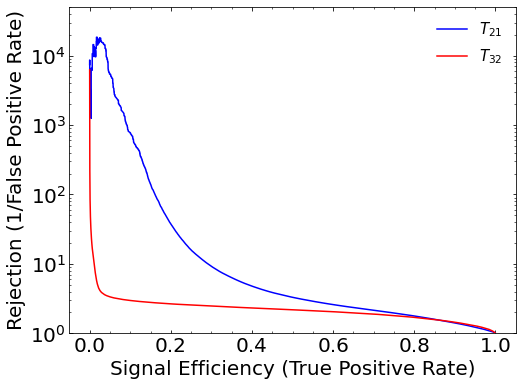

In [88]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
#plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][3:5]

    plt.plot(tpr_pts, mu, **bands[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
#plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

In [89]:
bands2 = {'cwola_T21': (cwola_maxT21, cwola_medT21, cwola_minT21, cwola_meanT21, cwola_stdT21, cwola_smeanT21, cwola_sstdT21, {'label':'$T_{21}$', 'color':'blue'}),
          'cwola_T32': (cwola_maxT32, cwola_medT32, cwola_minT32, cwola_meanT32, cwola_stdT32, cwola_smeanT32, cwola_sstdT32, {'label':'$T_{32}$', 'color':'red'}),
          'cwola_T21p': (cwola_maxT21p, cwola_medT21p, cwola_minT21p, cwola_meanT21p, cwola_stdT21p, cwola_smeanT21p, cwola_sstdT21p, {'label':"$T_{21}$'", 'color':'green'})}

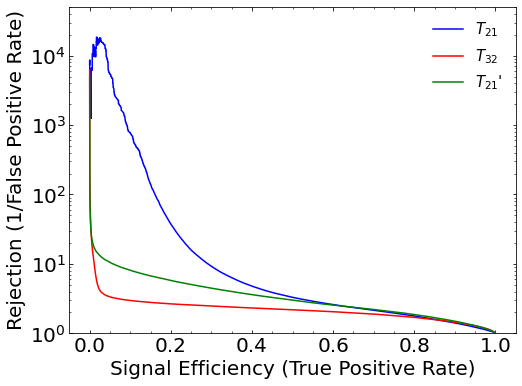

In [90]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
#plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands2:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands2[band][3:5]

    plt.plot(tpr_pts, mu, **bands2[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands2[band][-1]['color'])
#plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")